In [488]:
# ============================================================
# ESPN Fantasy Draft Value Project 
# - Block-by-block, in a logical pipeline
# - Separates: (A) hygiene + load, (B) league-year filtering,
#              (C) enrichment, (D) optimal lineup valid points,
#              (E) autodraft baseline + scoring, (F) plots
# - Adds: scoring-rule filter using anchor players
# ============================================================

from __future__ import annotations

from pathlib import Path
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [489]:
# ============================================================
# BLOCK 0 - CONFIG
# ============================================================

RAW_BASE = Path("data/raw/espn")                  # expects subfolders like 2021/, 2022/, ...
OUT_DIR  = Path("data/preprocessed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

YEARS = range(2021, 2025)                         # your current dataset range
RAW_FILES = ["lineup_data.csv", "draft_data.csv", "transaction_data.csv"]

EXPECTED_STARTERS = {"QB":1,"RB":2,"WR":2,"TE":1,"FLEX":1,"K":1,"D/ST":1,"OP":0,"STARTERS":9}
EXPECTED_DRAFT_LENGTH = 160

# "Anchor players" for scoring-rule detection:
# pick players that appear most seasons + are usually drafted/rostered.
# You can tune these later.
ANCHORS_BY_POS = {
    "QB":  ["Josh Allen", "Patrick Mahomes"],
    "RB":  ["Christian McCaffrey", "Derrick Henry"],
    "WR":  ["Justin Jefferson", "Tyreek Hill"],
    "TE":  ["Travis Kelce", "Mark Andrews"],
    "K":   ["Justin Tucker"],
    "D/ST":["Patriots D/ST", "49ers D/ST", "Cowboys D/ST"],  # depends on naming in your data
}
# If anchor names don't match your dataset strings, add synonyms below.
ANCHOR_SYNONYMS = {
    # "New England Patriots": "Patriots D/ST",
    # "San Francisco 49ers": "49ers D/ST",
}

In [490]:
# ============================================================
# BLOCK 1 - RAW FILE HYGIENE: DROP DUPLICATE ROWS IN EACH YEAR CSV
# ============================================================

def drop_raw_duplicates_in_place(base_dir: Path, years, files) -> None:
    for year in years:
        print(f"\n=== YEAR {year} ===")
        year_dir = base_dir / str(year)

        for fname in files:
            path = year_dir / fname
            if not path.exists():
                print(f"  {fname}: missing")
                continue

            df = pd.read_csv(path)
            before = len(df)
            df2 = df.drop_duplicates()
            after = len(df2)
            dropped = before - after

            if dropped == 0:
                print(f"  {fname}: no duplicates ({before:,} rows)")
            else:
                df2.to_csv(path, index=False)
                print(f"  {fname}: dropped {dropped:,} duplicate rows ({before:,} -> {after:,})")


# Run once (safe to re-run)
drop_raw_duplicates_in_place(RAW_BASE, YEARS, RAW_FILES)


=== YEAR 2021 ===
  lineup_data.csv: no duplicates (664,182 rows)
  draft_data.csv: no duplicates (41,452 rows)
  transaction_data.csv: no duplicates (95,477 rows)

=== YEAR 2022 ===
  lineup_data.csv: no duplicates (862,267 rows)
  draft_data.csv: no duplicates (52,586 rows)
  transaction_data.csv: no duplicates (112,047 rows)

=== YEAR 2023 ===
  lineup_data.csv: no duplicates (984,778 rows)
  draft_data.csv: no duplicates (65,593 rows)
  transaction_data.csv: no duplicates (122,146 rows)

=== YEAR 2024 ===
  lineup_data.csv: no duplicates (1,100,412 rows)
  draft_data.csv: no duplicates (81,805 rows)
  transaction_data.csv: no duplicates (135,866 rows)


In [491]:
# ============================================================
# BLOCK 2 - NORMALIZATION HELPERS
# ============================================================

CORE_POS = {"QB", "RB", "WR", "TE", "K", "D/ST", "DST", "DEF"}

def normalize_player_name(name: str) -> str:
    if pd.isna(name):
        return name
    s = str(name).strip()
    s = re.sub(r"\s+", " ", s)
    s = s.replace(" Jr.", "").replace(" Sr.", "")
    # apply anchor synonyms (optional)
    s = ANCHOR_SYNONYMS.get(s, s)
    return s

def normalize_slot(slot: str) -> str:
    s = str(slot).strip().upper()
    if s in {"DST", "DEF", "D/ST"}:
        return "D/ST"
    if s in {"BE", "BENCH"}:
        return "BE"
    if s in {"IR"}:
        return "IR"
    if s in {"RB/WR/TE", "FLEX"}:
        return "FLEX"
    if s in {"OP", "SUPERFLEX", "QB/RB/WR/TE"}:
        return "OP"
    return s

In [492]:
# ============================================================
# BLOCK 3 - LOADERS (multi-season draft + lineups)
# ============================================================

def load_draft(path: Path, year: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = ["League_ID","Player","Team","Round","Pick","Overall","Is_Autodrafted","Auto_Draft_Type_ID"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{path} draft_data is missing columns: {missing}")

    df = df.copy()
    df["Year"] = int(year)
    df["Player_norm"] = df["Player"].map(normalize_player_name)
    df["League_ID"] = df["League_ID"].astype(int)
    df["Year"] = df["Year"].astype(int)
    df["Overall"] = pd.to_numeric(df["Overall"], errors="coerce")
    df["Is_Autodrafted"] = pd.to_numeric(df["Is_Autodrafted"], errors="coerce").fillna(0).astype(int)
    return df

def load_lineups(path: Path, year: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = ["League_ID","Week","Team","Player","Slot","Points"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{path} lineup_data is missing columns: {missing}")

    df = df.copy()
    df["Year"] = int(year)
    df["Player_norm"] = df["Player"].map(normalize_player_name)
    df["League_ID"] = df["League_ID"].astype(int)
    df["Year"] = df["Year"].astype(int)
    df["Week"] = pd.to_numeric(df["Week"], errors="coerce")
    df["Points"] = pd.to_numeric(df["Points"], errors="coerce")
    df["Slot"] = df["Slot"].astype(str).str.strip()
    if "Is_Starter" in df.columns:
        df["Is_Starter"] = pd.to_numeric(df["Is_Starter"], errors="coerce")
    return df

def load_multi_season(raw_base: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    draft_parts = []
    lineup_parts = []

    for year_dir in sorted([p for p in raw_base.iterdir() if p.is_dir() and p.name.isdigit() and len(p.name) == 4]):
        year = int(year_dir.name)

        dpath = year_dir / "draft_data.csv"
        lpath = year_dir / "lineup_data.csv"

        if dpath.exists():
            draft_parts.append(load_draft(dpath, year))
        else:
            print(f"Skipping {year}: missing {dpath}")

        if lpath.exists():
            lineup_parts.append(load_lineups(lpath, year))
        else:
            print(f"Skipping {year}: missing {lpath}")

    if not draft_parts:
        raise FileNotFoundError(f"No draft_data.csv found under {raw_base}/<YEAR>/draft_data.csv")
    if not lineup_parts:
        raise FileNotFoundError(f"No lineup_data.csv found under {raw_base}/<YEAR>/lineup_data.csv")

    draft_all = pd.concat(draft_parts, ignore_index=True)
    lineups_all = pd.concat(lineup_parts, ignore_index=True)
    return draft_all, lineups_all


draft_raw, lineups_raw = load_multi_season(RAW_BASE)

In [493]:
# ============================================================
# BLOCK 4 - BASIC DRAFT METADATA
# ============================================================

def add_draft_length(draft_df: pd.DataFrame) -> pd.DataFrame:
    out = draft_df.copy()
    out["Draft_Length"] = (
        out.groupby(["League_ID", "Year"], dropna=False)["Overall"]
          .transform("max")
    )
    out["Draft_Length"] = pd.to_numeric(out["Draft_Length"], errors="coerce").fillna(-1).astype(int)
    return out

draft_raw = add_draft_length(draft_raw)

In [494]:
# ============================================================
# BLOCK 5 - FILTER #1: STANDARD STARTER SIGNATURE (league-year)
# ============================================================

def infer_league_starter_signature(lineups: pd.DataFrame) -> pd.DataFrame:
    df = lineups.copy()
    required = {"League_ID","Year","Team","Week","Slot","Is_Starter"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"lineups missing columns for starter signature: {sorted(missing)}")

    df["Slot_norm"] = df["Slot"].map(normalize_slot)
    starters = df[df["Is_Starter"].fillna(0).astype(int) == 1].copy()

    tw = (
        starters.groupby(["League_ID","Year","Team","Week","Slot_norm"])
        .size()
        .reset_index(name="n")
    )

    pivot = (
        tw.pivot_table(
            index=["League_ID","Year","Team","Week"],
            columns="Slot_norm",
            values="n",
            aggfunc="sum",
            fill_value=0,
        )
        .reset_index()
    )

    for col in ["QB","RB","WR","TE","K","D/ST","FLEX","OP"]:
        if col not in pivot.columns:
            pivot[col] = 0

    pivot["Starters_Total"] = pivot[["QB","RB","WR","TE","K","D/ST","FLEX","OP"]].sum(axis=1)

    def mode_int(s: pd.Series) -> int:
        vc = s.value_counts()
        return int(vc.index[0]) if len(vc) else 0

    league_sig = (
        pivot.groupby(["League_ID","Year"], dropna=False)
        .agg(
            QB=("QB", mode_int),
            RB=("RB", mode_int),
            WR=("WR", mode_int),
            TE=("TE", mode_int),
            K=("K", mode_int),
            DST=("D/ST", mode_int),
            FLEX=("FLEX", mode_int),
            OP=("OP", mode_int),
            Starters_Total=("Starters_Total", mode_int),
        )
        .reset_index()
    )

    league_sig["Signature"] = (
        "QB=" + league_sig["QB"].astype(str) +
        ",RB=" + league_sig["RB"].astype(str) +
        ",WR=" + league_sig["WR"].astype(str) +
        ",TE=" + league_sig["TE"].astype(str) +
        ",FLEX=" + league_sig["FLEX"].astype(str) +
        ",K=" + league_sig["K"].astype(str) +
        ",DST=" + league_sig["DST"].astype(str) +
        ",OP=" + league_sig["OP"].astype(str) +
        ",START=" + league_sig["Starters_Total"].astype(str)
    )
    return league_sig

def filter_standard_leagues(
    draft: pd.DataFrame,
    lineups: pd.DataFrame,
    *,
    expected: dict[str, int] | None = None,
    verbose: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if expected is None:
        expected = {"QB":1, "RB":2, "WR":2, "TE":1, "FLEX":1, "K":1, "D/ST":1, "OP":0, "STARTERS":9}

    league_sig = infer_league_starter_signature(lineups)

    keep = (
        (league_sig["QB"] == expected["QB"]) &
        (league_sig["RB"] == expected["RB"]) &
        (league_sig["WR"] == expected["WR"]) &
        (league_sig["TE"] == expected["TE"]) &
        (league_sig["FLEX"] == expected["FLEX"]) &
        (league_sig["K"] == expected["K"]) &
        (league_sig["DST"] == expected["D/ST"]) &
        (league_sig["OP"] == expected["OP"]) &
        (league_sig["Starters_Total"] == expected["STARTERS"])
    )
    league_sig["Keep_Standard"] = keep

    kept = league_sig[league_sig["Keep_Standard"]][["League_ID","Year"]]
    draft_filt  = draft.merge(kept, on=["League_ID","Year"], how="inner")
    lineups_filt = lineups.merge(kept, on=["League_ID","Year"], how="inner")

    if verbose:
        total = len(league_sig)
        k = int(league_sig["Keep_Standard"].sum())
        print(f"[filter_standard_leagues] keeping {k}/{total} league-years ({k/total:.1%})")
        if total - k > 0:
            print("[filter_standard_leagues] top non-standard signatures:")
            print(league_sig.loc[~league_sig["Keep_Standard"], "Signature"].value_counts().head(10))

    return draft_filt, lineups_filt, league_sig


draft_std, lineups_std, league_sig = filter_standard_leagues(
    draft_raw, lineups_raw,
    expected=EXPECTED_STARTERS,
    verbose=True
)

[filter_standard_leagues] keeping 825/1326 league-years (62.2%)
[filter_standard_leagues] top non-standard signatures:
Signature
QB=1,RB=2,WR=2,TE=1,FLEX=2,K=1,DST=1,OP=0,START=10    119
QB=1,RB=2,WR=3,TE=1,FLEX=1,K=1,DST=1,OP=0,START=10     46
QB=1,RB=2,WR=2,TE=1,FLEX=2,K=0,DST=1,OP=0,START=9      41
QB=2,RB=2,WR=2,TE=1,FLEX=1,K=1,DST=1,OP=0,START=10     30
QB=1,RB=2,WR=2,TE=1,FLEX=2,K=1,DST=0,OP=0,START=9      18
QB=1,RB=2,WR=2,TE=1,FLEX=0,K=1,DST=1,OP=0,START=8      17
QB=2,RB=2,WR=2,TE=1,FLEX=2,K=1,DST=1,OP=0,START=11     13
QB=1,RB=2,WR=2,TE=1,FLEX=1,K=1,DST=1,OP=1,START=10     11
QB=1,RB=2,WR=2,TE=1,FLEX=1,K=0,DST=1,OP=1,START=9       9
QB=1,RB=2,WR=2,TE=1,FLEX=1,K=0,DST=1,OP=0,START=8       9
Name: count, dtype: int64


In [495]:
# ============================================================
# BLOCK 6 - FILTER #2: SCORING-RULE FILTER USING ANCHOR PLAYERS (league-year)
# ============================================================

def _season_points_by_league_year(lineups: pd.DataFrame) -> pd.DataFrame:
    df = lineups.copy()
    df["Points"] = pd.to_numeric(df["Points"], errors="coerce")
    return (
        df.groupby(["League_ID","Year","Player_norm"], dropna=False)["Points"]
          .sum(min_count=1)
          .reset_index()
          .rename(columns={"Points":"Season_Total_Points"})
    )

def filter_scoring_rule_outliers(
    draft: pd.DataFrame,
    lineups: pd.DataFrame,
    *,
    anchors_by_pos: dict[str, list[str]] | None = None,
    z_thresh: float = 3.5,
    min_anchors_hit: int = 4,
    verbose: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Goal: remove league-years with strange scoring rules.
    Method:
      - compute Season_Total_Points per (League_ID, Year, Player_norm)
      - for each position group, look at anchor player season totals across league-years
      - compute robust z-score via median/MAD per (Year, anchor)
      - mark league-year as outlier if too many anchors are extreme
    Notes:
      - This is intentionally simple + robust.
      - Works even if you don't have explicit scoring settings.
    """
    if anchors_by_pos is None:
        anchors_by_pos = ANCHORS_BY_POS

    # build season totals
    pts = _season_points_by_league_year(lineups)

    # build anchor table
    anchor_rows = []
    for pos, names in anchors_by_pos.items():
        for n in names:
            anchor_rows.append((pos, normalize_player_name(n)))
    anchors = pd.DataFrame(anchor_rows, columns=["AnchorPos","Player_norm"]).drop_duplicates()

    # join to season totals
    a = pts.merge(anchors, on="Player_norm", how="inner")
    if a.empty:
        meta = pd.DataFrame(columns=["League_ID","Year","Anchors_Hit","Anchors_Outlier","Drop"])
        return draft, lineups, meta

    # robust z per (Year, Player_norm)
    def robust_z(s: pd.Series) -> pd.Series:
        x = s.astype(float)
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med))
        if mad == 0 or np.isnan(mad):
            return (x - med) * 0.0
        return 0.6745 * (x - med) / mad  # ~ std units for normal

    a["rz"] = a.groupby(["Year","Player_norm"], dropna=False)["Season_Total_Points"].transform(robust_z)
    a["Is_Outlier"] = a["rz"].abs() >= z_thresh

    # league-year summary
    meta = (
        a.groupby(["League_ID","Year"], dropna=False)
         .agg(
            Anchors_Hit=("Player_norm","nunique"),
            AnchorRows=("Player_norm","size"),
            Anchors_Outlier=("Is_Outlier","sum"),
            MaxAbsRZ=("rz", lambda s: float(np.nanmax(np.abs(s.to_numpy()))) if len(s) else np.nan),
         )
         .reset_index()
    )

    # drop if: too many outliers OR not enough anchors observed
    meta["Drop"] = (meta["Anchors_Hit"] < min_anchors_hit) | (meta["Anchors_Outlier"] >= 1)

    kept = meta[~meta["Drop"]][["League_ID","Year"]]
    draft_filt = draft.merge(kept, on=["League_ID","Year"], how="inner")
    lineups_filt = lineups.merge(kept, on=["League_ID","Year"], how="inner")

    if verbose:
        total = meta.shape[0]
        kept_n = kept.shape[0]
        print(f"[filter_scoring_rule_outliers] keeping {kept_n}/{total} league-years ({kept_n/total:.1%})")
        if total - kept_n > 0:
            print("[filter_scoring_rule_outliers] examples of dropped league-years:")
            print(meta[meta["Drop"]].sort_values(["Anchors_Hit","Anchors_Outlier","MaxAbsRZ"], ascending=[True,False,False]).head(10))

    return draft_filt, lineups_filt, meta


draft_filt, lineups_filt, scoring_meta = filter_scoring_rule_outliers(
    draft_std, lineups_std,
    z_thresh=3.5,
    min_anchors_hit=4,
    verbose=True
)

[filter_scoring_rule_outliers] keeping 479/825 league-years (58.1%)
[filter_scoring_rule_outliers] examples of dropped league-years:
     League_ID  Year  Anchors_Hit  AnchorRows  Anchors_Outlier   MaxAbsRZ  \
791    1741809  2024            9           9                6  16.371079   
362    1169860  2024            9           9                6  12.526429   
505    1264240  2024           10          10                7  15.031714   
443    1222001  2024           10          10                4   8.340755   
442    1222001  2023           11          11                9  13.279766   
649    1382708  2024           11          11                8  45.210771   
206    1022020  2024           11          11                8  38.639214   
490    1245727  2024           11          11                6  30.448857   
192    1013919  2024           11          11                6  22.065786   
366    1172559  2024           11          11                6  20.504800   

     Drop  
791  Tr

In [496]:
# ============================================================
# BLOCK 7 - OPTIONAL FILTER #3: DRAFT LENGTH (league-year)
# ============================================================

def filter_draft_length(draft: pd.DataFrame, lineups: pd.DataFrame, *, length: int, verbose: bool = True):
    d = draft.copy()
    if "Draft_Length" not in d.columns:
        d = add_draft_length(d)

    kept = (
        d.groupby(["League_ID","Year"], dropna=False)["Draft_Length"]
         .max()
         .reset_index()
    )
    kept = kept[kept["Draft_Length"] == int(length)][["League_ID","Year"]]

    d2 = d.merge(kept, on=["League_ID","Year"], how="inner")
    l2 = lineups.merge(kept, on=["League_ID","Year"], how="inner")

    if verbose:
        total = d.groupby(["League_ID","Year"]).ngroups
        kept_n = kept.shape[0]
        print(f"[filter_draft_length] keeping {kept_n}/{total} league-years ({kept_n/total:.1%}) with Draft_Length={length}")

    return d2, l2


draft_filt, lineups_filt = filter_draft_length(
    draft_filt, lineups_filt,
    length=EXPECTED_DRAFT_LENGTH,
    verbose=True
)

[filter_draft_length] keeping 334/479 league-years (69.7%) with Draft_Length=160


In [497]:
# ============================================================
# BLOCK 8 - ENRICHMENT: POSITION + SEASON TOTAL POINTS (simple)
# ============================================================

def infer_position_from_slots(lineups: pd.DataFrame) -> pd.DataFrame:
    x = lineups.copy()
    x["Slot_norm"] = x["Slot"].map(normalize_slot)
    x["Is_core_pos"] = x["Slot_norm"].isin({"QB","RB","WR","TE","K","D/ST"})

    counts = (
        x.groupby(["League_ID","Year","Player_norm","Slot_norm","Is_core_pos"], dropna=False)
         .size().reset_index(name="n")
         .sort_values(by=["League_ID","Year","Player_norm","Is_core_pos","n"],
                      ascending=[True,True,True,False,False])
    )

    top = (
        counts.drop_duplicates(subset=["League_ID","Year","Player_norm"])
              .rename(columns={"Slot_norm":"Position"})[["League_ID","Year","Player_norm","Position"]]
    )
    return top

def season_points_from_lineups(lineups: pd.DataFrame) -> pd.DataFrame:
    df = lineups.copy()
    df["Points"] = pd.to_numeric(df["Points"], errors="coerce")
    return (
        df.groupby(["League_ID","Year","Player_norm"], dropna=False)["Points"]
          .sum(min_count=1)
          .reset_index()
          .rename(columns={"Points":"Season_Total_Points"})
    )

def build_draft_enriched(draft: pd.DataFrame, lineups: pd.DataFrame) -> pd.DataFrame:
    d = draft.copy()
    d["Player_norm"] = d["Player_norm"].map(normalize_player_name)

    pos = infer_position_from_slots(lineups)
    pts = season_points_from_lineups(lineups)

    out = d.merge(pos, on=["League_ID","Year","Player_norm"], how="left")
    out = out.merge(pts, on=["League_ID","Year","Player_norm"], how="left")

    out["Season_Total_Points"] = pd.to_numeric(out["Season_Total_Points"], errors="coerce").fillna(0.0)

    # keep a clean set of columns
    cols = [
        "League_ID","Year","Team","Player",
        "Round","Pick","Overall",
        "Draft_Length",
        "Position","Season_Total_Points",
        "Is_Autodrafted","Auto_Draft_Type_ID",
        "Player_norm",
    ]
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    return out[cols].copy()


draft_enriched = build_draft_enriched(draft_filt, lineups_filt)
draft_enriched_path = OUT_DIR / "draft_enriched_filtered.csv"
draft_enriched.to_csv(draft_enriched_path, index=False)
print(f"[saved] {draft_enriched_path} ({len(draft_enriched):,} rows)")



[saved] data\preprocessed\draft_enriched_filtered.csv (53,440 rows)


In [498]:
# ============================================================
# BLOCK 9 - OPTIMAL STARTABLE POINTS (VALID POINTS) PIPELINE
#   (points that could count if lineup was always optimized)
# ============================================================

def _normalize_slot_defense(slot: str) -> str:
    slot = str(slot).strip()
    return {"DST": "D/ST", "DEF": "D/ST"}.get(slot, slot)

def infer_player_position_by_core_starts(lineups: pd.DataFrame) -> pd.DataFrame:
    CORE = {"QB", "RB", "WR", "TE", "K", "D/ST"}
    df = lineups.copy()
    df["Slot"] = df["Slot"].map(_normalize_slot_defense)

    if "Year" not in df.columns:
        raise ValueError("lineups must include a 'Year' column for multi-season processing.")

    core_rows = df[df["Slot"].isin(CORE)].copy()
    if core_rows.empty:
        raise ValueError("No core slots found in lineup_data Slot column (QB/RB/WR/TE/K/DST).")

    pos = (
        core_rows.groupby(["League_ID", "Year", "Team", "Player_norm"])["Slot"]
        .agg(lambda s: s.value_counts().index[0])
        .reset_index()
        .rename(columns={"Slot": "Position"})
    )
    return pos

def build_player_week_points(lineups: pd.DataFrame) -> pd.DataFrame:
    df = lineups.copy()
    df["Slot"] = df["Slot"].map(_normalize_slot_defense)
    df["Points"] = pd.to_numeric(df["Points"], errors="coerce").fillna(0.0)

    if "Year" not in df.columns:
        raise ValueError("lineups must include a 'Year' column for multi-season processing.")

    pw = (
        df.groupby(["League_ID", "Year", "Team", "Week", "Player_norm"], dropna=False)["Points"]
        .max()
        .reset_index()
        .rename(columns={"Points": "WeekPoints"})
    )
    return pw

def choose_optimal_lineup_for_group(
    g: pd.DataFrame,
    slot_counts: dict[str,int],
    flex_eligible: set[str]
) -> pd.DataFrame:
    g = g.copy()
    g["SelectedOptimal"] = False
    used = set()

    def select_top(pos, n):
        nonlocal used
        if n <= 0:
            return []
        cand = g[(g["Position"] == pos) & (~g["Player_norm"].isin(used))].sort_values("WeekPoints", ascending=False)
        chosen = cand.head(n)["Player_norm"].tolist()
        used.update(chosen)
        return chosen

    def select_flex(n):
        nonlocal used
        if n <= 0:
            return []
        cand = g[(g["Position"].isin(flex_eligible)) & (~g["Player_norm"].isin(used))].sort_values("WeekPoints", ascending=False)
        chosen = cand.head(n)["Player_norm"].tolist()
        used.update(chosen)
        return chosen

    selected = []
    for pos in ["QB", "RB", "WR", "TE", "K", "D/ST"]:
        selected += select_top(pos, slot_counts.get(pos, 0))
    selected += select_flex(slot_counts.get("FLEX", 0))

    g.loc[g["Player_norm"].isin(selected), "SelectedOptimal"] = True
    return g

def compute_optimal_startable_points(
    lineups: pd.DataFrame,
    *,
    slot_counts: dict[str,int] | None = None,
    flex_eligible: set[str] | None = None,
    status_every: int = 250
) -> pd.DataFrame:
    if slot_counts is None:
        slot_counts = {"QB":1, "RB":2, "WR":2, "TE":1, "FLEX":1, "K":1, "D/ST":1}
    if flex_eligible is None:
        flex_eligible = {"RB","WR","TE"}

    t_all = time.time()
    print("[compute_optimal_startable_points] start", flush=True)

    df = lineups.copy()
    df["Player_norm"] = df["Player_norm"] if "Player_norm" in df.columns else df["Player"].astype(str).str.strip()
    df["Slot"] = df["Slot"].map(_normalize_slot_defense)

    if "Year" not in df.columns:
        raise ValueError("lineups must include a 'Year' column for multi-season processing.")

    print(f"[compute_optimal_startable_points] rows: {len(df):,}", flush=True)

    pos = infer_player_position_by_core_starts(df)
    pw = build_player_week_points(df)

    pw = pw.merge(pos, on=["League_ID","Year","Team","Player_norm"], how="left")
    pw["Position"] = pw["Position"].fillna("UNKNOWN")

    gb = pw.groupby(["League_ID","Year","Team","Week"], sort=False)
    n_groups = gb.ngroups
    print(f"[compute_optimal_startable_points] optimizing {n_groups:,} team-weeks...", flush=True)

    t0 = time.time()
    selected_parts = []
    for i, (_, g) in enumerate(gb, start=1):
        if i % status_every == 0 or i == 1 or i == n_groups:
            elapsed = time.time() - t0
            rate = i / elapsed if elapsed > 0 else float("inf")
            print(f"  - progress: {i:,}/{n_groups:,} groups ({rate:.1f} groups/s)", flush=True)
        selected_parts.append(choose_optimal_lineup_for_group(g, slot_counts, flex_eligible))

    selected = pd.concat(selected_parts, ignore_index=True)
    print(f"[compute_optimal_startable_points] done in {time.time()-t_all:.2f}s", flush=True)
    return selected

def add_season_total_points_valid(
    draft_enriched: pd.DataFrame,
    optimal_selected: pd.DataFrame
) -> pd.DataFrame:
    for col in ["Year", "League_ID", "Team", "Player_norm"]:
        if col not in draft_enriched.columns:
            raise ValueError(f"draft_enriched missing required column '{col}' for multi-season merge.")
    if "Year" not in optimal_selected.columns:
        raise ValueError("optimal_selected missing 'Year' column.")

    valid = (
        optimal_selected[optimal_selected["SelectedOptimal"]]
        .groupby(["League_ID","Year","Team","Player_norm"], dropna=False)["WeekPoints"]
        .sum()
        .reset_index()
        .rename(columns={"WeekPoints":"Season_Total_Points_Valid"})
    )

    out = draft_enriched.merge(valid, on=["League_ID","Year","Team","Player_norm"], how="left")
    out["Season_Total_Points_Valid"] = pd.to_numeric(out["Season_Total_Points_Valid"], errors="coerce").fillna(0.0)
    return out

print(f"This process takes some time. It's less than 4 minutes if your environment cycles through 300+ groups/s")
optimal_selected = compute_optimal_startable_points(
    lineups_filt,
    slot_counts={"QB":1,"RB":2,"WR":2,"TE":1,"FLEX":1,"K":1,"D/ST":1},
    flex_eligible={"RB","WR","TE"},
    status_every=250
)

draft_with_valid = add_season_total_points_valid(draft_enriched, optimal_selected)
draft_with_valid_path = OUT_DIR / "draft_with_valid_points_filtered.csv"
draft_with_valid.to_csv(draft_with_valid_path, index=False)
print(f"[saved] {draft_with_valid_path} ({len(draft_with_valid):,} rows)")


This process takes some time. It's less than 4 minutes if your environment cycles through 300+ groups/s
[compute_optimal_startable_points] start
[compute_optimal_startable_points] rows: 890,589
[compute_optimal_startable_points] optimizing 54,839 team-weeks...
  - progress: 1/54,839 groups (7.6 groups/s)
  - progress: 250/54,839 groups (310.9 groups/s)
  - progress: 500/54,839 groups (324.9 groups/s)
  - progress: 750/54,839 groups (337.8 groups/s)
  - progress: 1,000/54,839 groups (338.5 groups/s)
  - progress: 1,250/54,839 groups (343.1 groups/s)
  - progress: 1,500/54,839 groups (346.7 groups/s)
  - progress: 1,750/54,839 groups (348.3 groups/s)
  - progress: 2,000/54,839 groups (349.6 groups/s)
  - progress: 2,250/54,839 groups (351.2 groups/s)
  - progress: 2,500/54,839 groups (352.7 groups/s)
  - progress: 2,750/54,839 groups (353.9 groups/s)
  - progress: 3,000/54,839 groups (354.8 groups/s)
  - progress: 3,250/54,839 groups (355.9 groups/s)
  - progress: 3,500/54,839 groups (35

In [499]:
# ============================================================
# BLOCK 10 - FULLY AUTODRAFTED TEAMS + SANITY CHECK
# ============================================================

def identify_fully_autodrafted_teams(
    draft_df: pd.DataFrame,
    *,
    sanity_check_pick1: bool = True,
    verbose: bool = True
) -> pd.DataFrame:
    required = ["League_ID", "Year", "Team", "Is_Autodrafted"]
    missing = [c for c in required if c not in draft_df.columns]
    if missing:
        raise ValueError(f"draft_df missing columns: {missing}")

    result = (
        draft_df
        .groupby(["League_ID", "Year", "Team"], dropna=False)
        .agg(
            Total_Picks=("Is_Autodrafted", "size"),
            Autodrafted_Picks=("Is_Autodrafted", "sum")
        )
        .reset_index()
    )
    result["Is_Fully_Autodrafted"] = (result["Total_Picks"] == result["Autodrafted_Picks"])

    if sanity_check_pick1:
        for c in ["Overall", "Player_norm"]:
            if c not in draft_df.columns:
                raise ValueError(f"Sanity check requires column '{c}'")

        df_auto = draft_df.merge(
            result[["League_ID", "Year", "Team", "Is_Fully_Autodrafted"]],
            on=["League_ID", "Year", "Team"],
            how="left"
        )

        pick1 = df_auto[(df_auto["Is_Fully_Autodrafted"]) & (df_auto["Overall"] == 1)]
        if verbose:
            print("\n[Sanity Check] Fully-Autodrafted 1.01 Picks")
            if pick1.empty:
                print("  none found")
            else:
                summary = (pick1.groupby("Year")["Player_norm"]
                           .agg(Unique_1OA="nunique", Total_1OA="count")
                           .reset_index())
                print(summary.to_string(index=False))
                print(f"\nAcross all years:\n  Total 1.01 picks = {len(pick1)}\n  Unique players  = {pick1['Player_norm'].nunique()}")

    return result


fully_auto = identify_fully_autodrafted_teams(draft_with_valid, sanity_check_pick1=True, verbose=True)




[Sanity Check] Fully-Autodrafted 1.01 Picks
 Year  Unique_1OA  Total_1OA
 2021           2          7
 2022           1          8
 2023           1          7
 2024           2          8

Across all years:
  Total 1.01 picks = 30
  Unique players  = 5


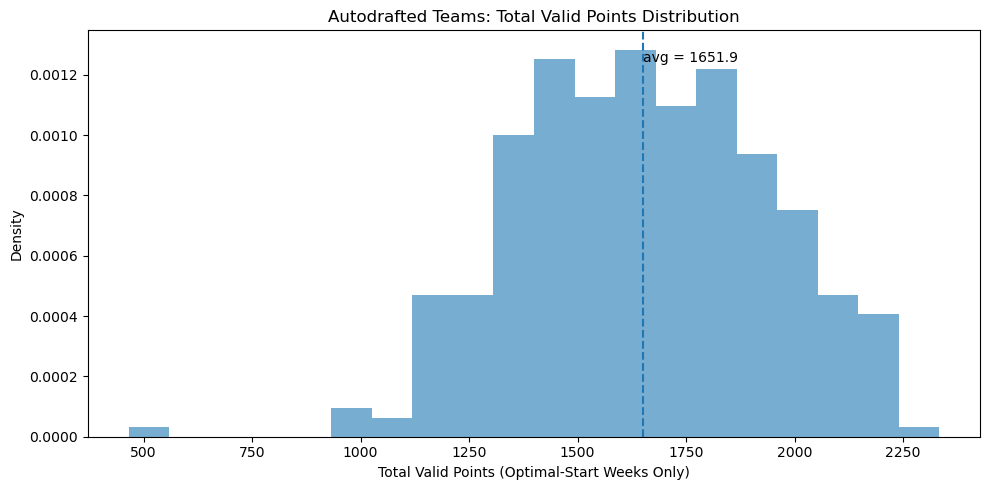

Average Total Valid Points: 1651.90


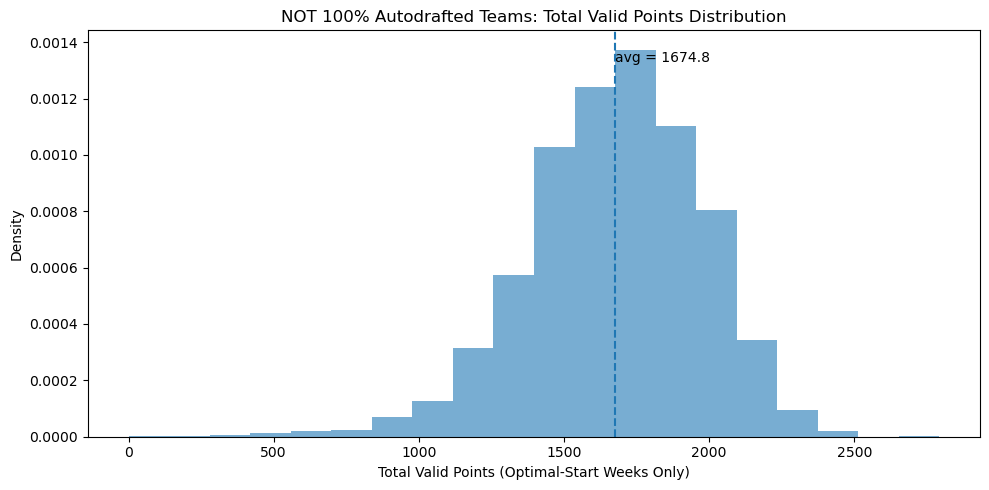

Average Total Valid Points: 1674.75


In [500]:
# ============================================================
# BLOCK 11 - TEAM TOTAL VALID POINTS DISTRIBUTIONS
# ============================================================

def team_total_valid_points(draft_with_valid: pd.DataFrame, *, fully_autodraft_only: bool | None = None) -> pd.DataFrame:
    required = ["League_ID", "Year", "Team", "Is_Autodrafted", "Season_Total_Points_Valid"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"draft_with_valid missing columns: {missing}")

    df = draft_with_valid.copy()

    team_auto = (
        df.groupby(["League_ID", "Year", "Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Autodrafted_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Autodrafted_Picks"])
    df = df.merge(team_auto[["League_ID", "Year", "Team", "Is_Fully_Autodrafted"]],
                  on=["League_ID", "Year", "Team"], how="left")

    if fully_autodraft_only is True:
        df = df[df["Is_Fully_Autodrafted"]].copy()
    elif fully_autodraft_only is False:
        df = df[~df["Is_Fully_Autodrafted"]].copy()

    team_totals = (
        df.groupby(["League_ID", "Year", "Team"], dropna=False)["Season_Total_Points_Valid"]
          .sum()
          .reset_index()
          .rename(columns={"Season_Total_Points_Valid": "Total_Valid_Points"})
          .sort_values("Total_Valid_Points", ascending=False)
    )
    if team_totals.empty:
        raise ValueError("No teams found after filtering.")
    return team_totals

def plot_total_valid_points_dist(team_totals: pd.DataFrame, *, bins: int = 20, title: str = "") -> None:
    x = team_totals["Total_Valid_Points"].astype(float).to_numpy()
    avg = float(np.mean(x))
    plt.figure(figsize=(10, 5))
    plt.hist(x, bins=bins, density=True, alpha=0.6)
    plt.axvline(avg, linestyle="--")
    plt.xlabel("Total Valid Points (Optimal-Start Weeks Only)")
    plt.ylabel("Density")
    plt.title(title or f"Total Valid Points Distribution (n={len(x)})")
    ymin, ymax = plt.ylim()
    plt.text(avg, ymax * 0.95, f"avg = {avg:.1f}", va="top")
    plt.tight_layout()
    plt.show()
    print(f"Average Total Valid Points: {avg:.2f}")

team_totals_auto = team_total_valid_points(draft_with_valid, fully_autodraft_only=True)
plot_total_valid_points_dist(team_totals_auto, bins=20, title="Autodrafted Teams: Total Valid Points Distribution")

team_totals_non = team_total_valid_points(draft_with_valid, fully_autodraft_only=False)
plot_total_valid_points_dist(team_totals_non, bins=20, title="NOT 100% Autodrafted Teams: Total Valid Points Distribution")



In [501]:
# ============================================================
# BLOCK 12 - EXPECTED VALID POINTS BY PICK (autodraft baseline)
# ============================================================

def expected_valid_points_by_pick_autodraft_distribution(draft_with_valid: pd.DataFrame) -> pd.DataFrame:
    required = ["League_ID","Year","Team","Overall","Is_Autodrafted","Season_Total_Points_Valid","Player_norm"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    df = draft_with_valid.copy()

    team_auto = (
        df.groupby(["League_ID","Year","Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Auto_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Auto_Picks"])

    df = df.merge(team_auto[["League_ID","Year","Team","Is_Fully_Autodrafted"]],
                  on=["League_ID","Year","Team"], how="left")
    df = df[df["Is_Fully_Autodrafted"]].copy()

    dist = (
        df.groupby("Overall", dropna=False)
        .agg(
            Mean=("Season_Total_Points_Valid", "mean"),
            Std=("Season_Total_Points_Valid", "std"),
            N_Picks=("Season_Total_Points_Valid", "count"),
            Unique_Players=("Player_norm", "nunique"),
            P10=("Season_Total_Points_Valid", lambda s: s.quantile(0.10)),
            P25=("Season_Total_Points_Valid", lambda s: s.quantile(0.25)),
            P50=("Season_Total_Points_Valid", lambda s: s.quantile(0.50)),
            P75=("Season_Total_Points_Valid", lambda s: s.quantile(0.75)),
            P90=("Season_Total_Points_Valid", lambda s: s.quantile(0.90)),
        )
        .reset_index()
        .sort_values("Overall")
    )
    return dist

In [502]:
# ============================================================
# BLOCK 13 - DENOISED EXPECTED CURVE (optional)
# ============================================================

def expected_valid_points_by_pick_from_autodraft_pooled_denoised(
    draft_with_valid: pd.DataFrame,
    *,
    estimator: str = "trimmed_mean",   # "mean" | "median" | "trimmed_mean" | "winsor_mean"
    trim: float = 0.10,
    smooth_window: int = 5
) -> pd.DataFrame:
    required = ["League_ID","Year","Team","Overall","Is_Autodrafted","Season_Total_Points_Valid"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"draft_with_valid missing columns: {missing}")

    df = draft_with_valid.copy()
    df["Overall"] = pd.to_numeric(df["Overall"], errors="coerce").astype(int)
    df["Is_Autodrafted"] = pd.to_numeric(df["Is_Autodrafted"], errors="coerce").fillna(0).astype(int)
    df["Season_Total_Points_Valid"] = pd.to_numeric(df["Season_Total_Points_Valid"], errors="coerce")

    team_auto = (
        df.groupby(["League_ID","Year","Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Autodrafted_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Autodrafted_Picks"])
    df = df.merge(team_auto[["League_ID","Year","Team","Is_Fully_Autodrafted"]],
                  on=["League_ID","Year","Team"], how="left")

    df_auto = df[df["Is_Fully_Autodrafted"]].copy()
    if df_auto.empty:
        raise ValueError("No fully-autodrafted teams found.")

    if estimator == "mean":
        agg_func = "mean"
    elif estimator == "median":
        agg_func = lambda s: float(np.nanmedian(s.to_numpy()))
    elif estimator == "trimmed_mean":
        from scipy.stats import trim_mean
        agg_func = lambda s: float(trim_mean(s.dropna().to_numpy(), proportiontocut=trim))
    elif estimator == "winsor_mean":
        from scipy.stats.mstats import winsorize
        agg_func = lambda s: float(np.mean(winsorize(s.dropna().to_numpy(), limits=trim)))
    else:
        raise ValueError("estimator must be one of: mean, median, trimmed_mean, winsor_mean")

    pooled = (
        df_auto.groupby("Overall", dropna=False)["Season_Total_Points_Valid"]
              .agg(Expected_Valid_Points=agg_func, Std_Valid_Points="std", N="count")
              .reset_index()
              .sort_values("Overall")
    )

    if smooth_window and smooth_window > 1:
        pooled["Expected_Smoothed"] = (
            pooled["Expected_Valid_Points"].rolling(window=smooth_window, center=True, min_periods=1).mean()
        )
    else:
        pooled["Expected_Smoothed"] = pooled["Expected_Valid_Points"]

    return pooled

In [503]:
# ============================================================
# BLOCK 14 - SCORE PICKS (points added, z-score)
# ============================================================

def expected_valid_points_by_pick_from_autodraft(
    draft_with_valid: pd.DataFrame,
    *,
    by_year: bool = True
) -> pd.DataFrame:
    required = ["League_ID","Year","Team","Overall","Is_Autodrafted","Season_Total_Points_Valid"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"draft_with_valid missing columns: {missing}")

    df = draft_with_valid.copy()
    df["Year"] = df["Year"].astype(int)
    df["Overall"] = pd.to_numeric(df["Overall"], errors="coerce").astype(int)
    df["Is_Autodrafted"] = pd.to_numeric(df["Is_Autodrafted"], errors="coerce").fillna(0).astype(int)
    df["Season_Total_Points_Valid"] = pd.to_numeric(df["Season_Total_Points_Valid"], errors="coerce")

    team_auto = (
        df.groupby(["League_ID","Year","Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Autodrafted_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Autodrafted_Picks"])
    df = df.merge(team_auto[["League_ID","Year","Team","Is_Fully_Autodrafted"]],
                  on=["League_ID","Year","Team"], how="left")

    df_auto = df[df["Is_Fully_Autodrafted"]].copy()
    if df_auto.empty:
        raise ValueError("No fully-autodrafted teams found.")

    keys = ["Overall"] if not by_year else ["Year","Overall"]
    expected = (
        df_auto.groupby(keys, dropna=False)["Season_Total_Points_Valid"]
              .agg(Expected_Valid_Points="mean", Std_Valid_Points="std", N="count")
              .reset_index()
              .sort_values(keys)
    )
    return expected


expected_by_pick_year = expected_valid_points_by_pick_from_autodraft(draft_with_valid, by_year=True)

draft_scored = draft_with_valid.merge(
    expected_by_pick_year[["Year","Overall","Expected_Valid_Points","Std_Valid_Points"]],
    on=["Year","Overall"],
    how="left"
)
draft_scored["Points_Added"] = draft_scored["Season_Total_Points_Valid"] - draft_scored["Expected_Valid_Points"]
draft_scored["Points_Added_Z"] = draft_scored["Points_Added"] / draft_scored["Std_Valid_Points"]



In [504]:
# ============================================================
# BLOCK 14B - Polynomial baseline (very smooth macro trend)
# ============================================================

import numpy as np
import pandas as pd

def fit_polynomial_baseline(
    expected_pooled: pd.DataFrame,
    *,
    x_col: str = "Overall",
    y_col: str = "Expected_Valid_Points",   # or "Expected_Smoothed"
    w_col: str = "N",
    degree: int = 4,
) -> pd.DataFrame:
    """
    Fits weighted polynomial regression y ~ poly(x) to pooled expected curve.

    Returns expected_pooled with added columns:
      Poly_Expected, Poly_Degree
    """
    df = expected_pooled.copy()

    # clean numeric
    x = pd.to_numeric(df[x_col], errors="coerce").to_numpy(dtype=float)
    y = pd.to_numeric(df[y_col], errors="coerce").to_numpy(dtype=float)

    if w_col in df.columns:
        w = pd.to_numeric(df[w_col], errors="coerce").fillna(1.0).to_numpy(dtype=float)
    else:
        w = np.ones_like(x)

    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(w) & (w > 0)
    x, y, w = x[m], y[m], w[m]

    if len(x) < degree + 2:
        raise ValueError(f"Not enough points to fit degree={degree} polynomial.")

    # weighted poly fit
    coeff = np.polyfit(x, y, deg=degree, w=w)
    p = np.poly1d(coeff)

    df["Poly_Expected"] = p(pd.to_numeric(df[x_col], errors="coerce").to_numpy(dtype=float))
    df["Poly_Degree"] = degree
    return df



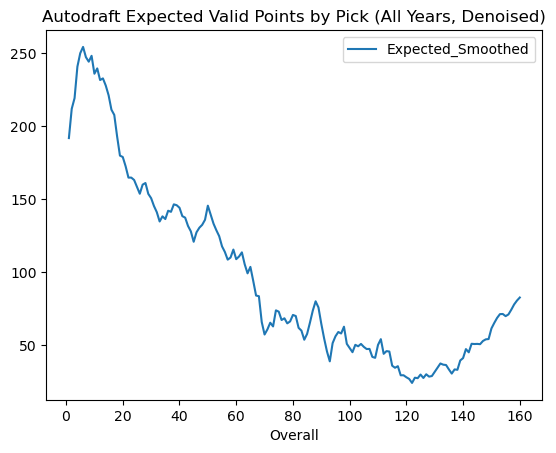

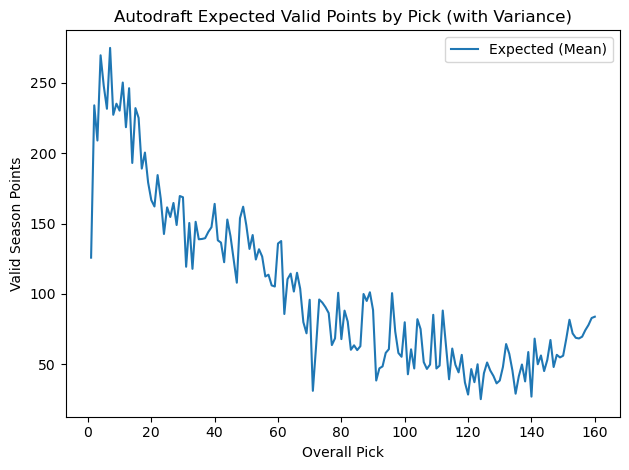

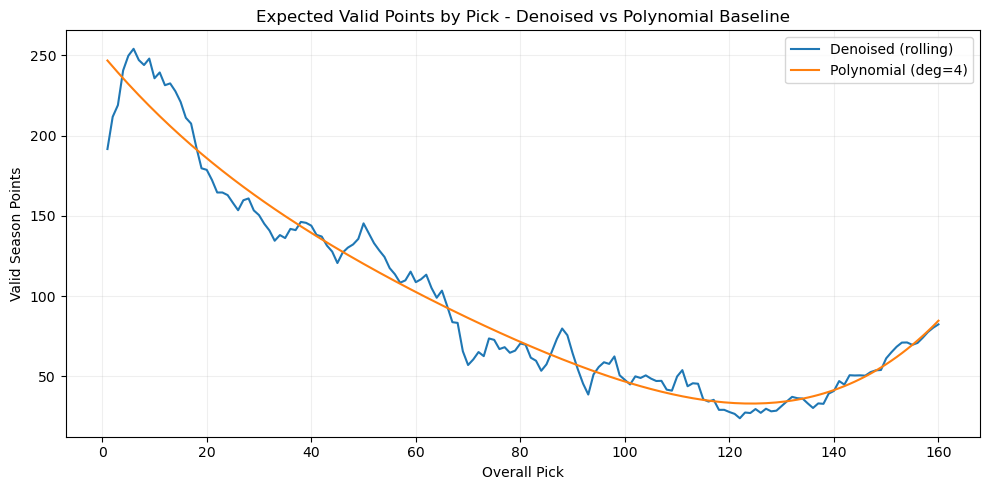

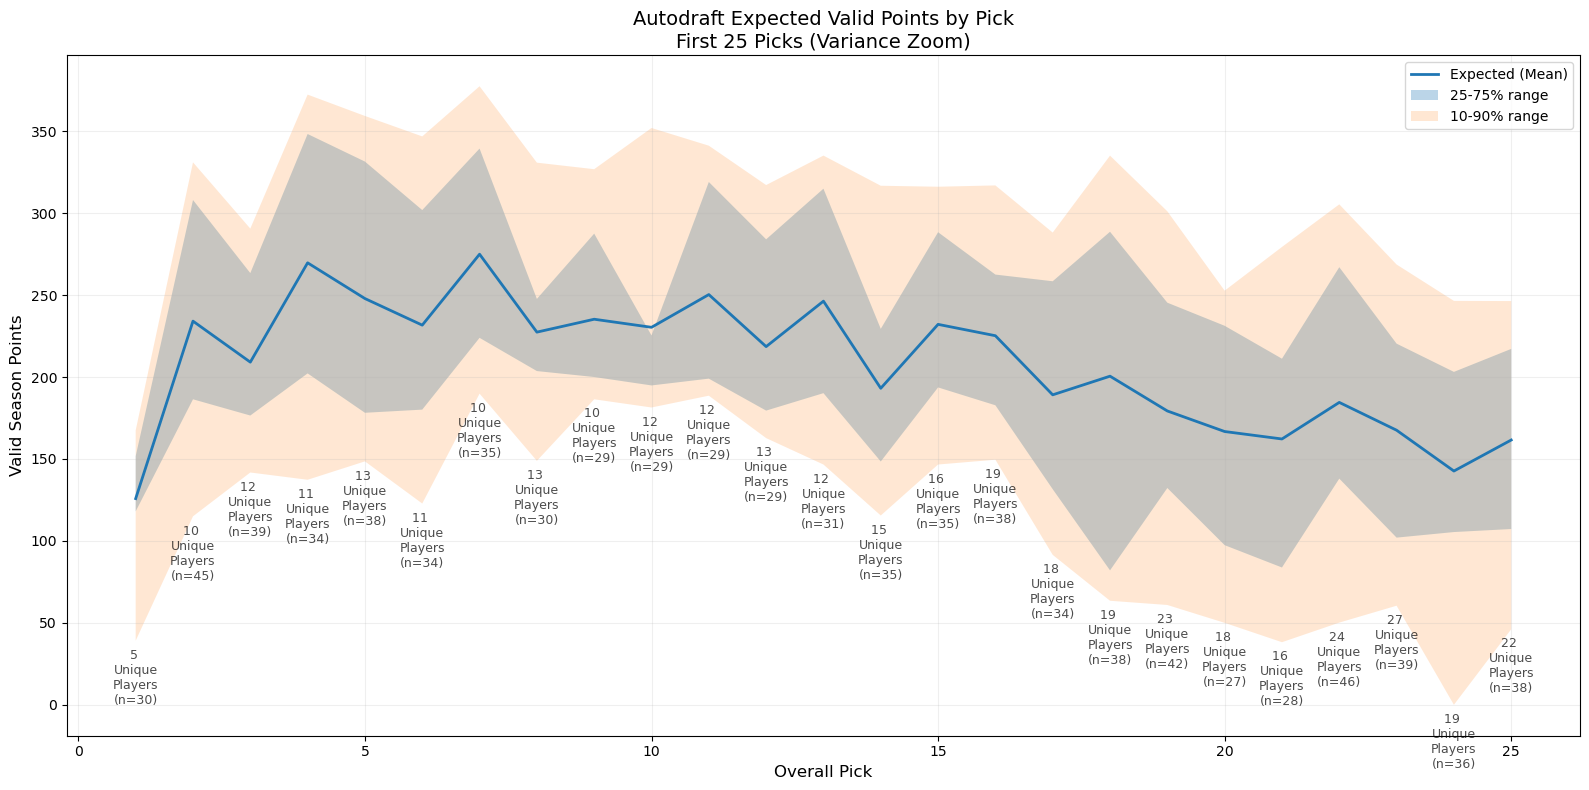

   Overall  Expected_Valid_Points  Expected_Smoothed   N
0        1             124.750000         191.682247  30
1        2             241.211892         211.733114  45
2        3             209.084848         219.035116  39
3        4             271.885714         240.633830  34
4        5             248.243125         249.816279  38
5        6             232.743571         254.125810  34
6        7             287.124138         247.115387  35
7        8             230.632500         244.020682  30
8        9             236.833600         248.031328  29
9       10             232.769600         235.771620  29
     Overall  Expected_Valid_Points  Expected_Smoothed   N
150      151              66.720000          65.076191  29
151      152              81.478261          68.514048  27
152      153              72.057692          71.102011  32
153      154              68.439286          71.183011  34
154      155              66.814815          69.705216  33
155      156       

In [505]:
# ============================================================
# BLOCK 15 - PLOTS (variance band, zoom, denoised curve)
# ============================================================

# 15A: Denoised pooled curve
expected_by_pick_pooled = expected_valid_points_by_pick_from_autodraft_pooled_denoised(
    draft_with_valid,
    estimator="trimmed_mean",
    trim=0.10,
    smooth_window=5
)
expected_by_pick_pooled.plot(x="Overall", y="Expected_Smoothed",
                             title="Autodraft Expected Valid Points by Pick (All Years, Denoised)")
plt.show()

# 15B: Distribution bands (P10-P90, P25-P75)
dist = expected_valid_points_by_pick_autodraft_distribution(draft_with_valid)

plt.plot(dist["Overall"], dist["Mean"], label="Expected (Mean)")
ax.fill_between(dist_20["Overall"], dist_20["P25"], dist_20["P75"], alpha=0.30, label="25-75% range")
ax.fill_between(dist_20["Overall"], dist_20["P10"], dist_20["P90"], alpha=0.18, label="10-90% range")
plt.xlabel("Overall Pick")
plt.ylabel("Valid Season Points")
plt.title("Autodraft Expected Valid Points by Pick (with Variance)")
plt.legend()
plt.tight_layout()

# Smooth Poly Curve
# Choose what you want to fit to:
# - fit to Expected_Smoothed for maximum noise resistance
# - OR fit to Expected_Valid_Points (trimmed mean, no rolling)
expected_by_pick_poly = fit_polynomial_baseline(
    expected_by_pick_pooled,
    y_col="Expected_Smoothed",
    w_col="N",
    degree=4
)
plt.figure(figsize=(10,5))
plt.plot(expected_by_pick_poly["Overall"], expected_by_pick_poly["Expected_Smoothed"], label="Denoised (rolling)")
plt.plot(expected_by_pick_poly["Overall"], expected_by_pick_poly["Poly_Expected"], label=f"Polynomial (deg={int(expected_by_pick_poly['Poly_Degree'].iloc[0])})")
plt.xlabel("Overall Pick"); plt.ylabel("Valid Season Points")
plt.title("Expected Valid Points by Pick - Denoised vs Polynomial Baseline")
plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()

plt.show()

# 15C: Zoom first 25 picks, annotate N (unique players + total picks)
dist_20 = dist[dist["Overall"] <= 25].copy()
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(dist_20["Overall"], dist_20["Mean"], label="Expected (Mean)", linewidth=2)
ax.fill_between(dist_20["Overall"], dist_20["P25"], dist_20["P75"], alpha=0.30, label="25-75% range")
ax.fill_between(dist_20["Overall"], dist_20["P10"], dist_20["P90"], alpha=0.18, label="10-90% range")
ax.set_xlabel("Overall Pick", fontsize=12)
ax.set_ylabel("Valid Season Points", fontsize=12)
ax.set_title("Autodraft Expected Valid Points by Pick\nFirst 25 Picks (Variance Zoom)", fontsize=14)

for _, r in dist_20.iterrows():
    ax.text(
        r["Overall"], r["P10"] - 5,
        f"{int(r['Unique_Players'])} \nUnique\nPlayers\n(n={int(r['N_Picks'])})",
        ha="center", va="top", fontsize=9, alpha=0.7
    )

ax.legend()
ax.grid(alpha=0.2)
fig.tight_layout()
plt.show()

print(expected_by_pick_pooled[["Overall","Expected_Valid_Points","Expected_Smoothed","N"]].head(10))
print(expected_by_pick_pooled[["Overall","Expected_Valid_Points","Expected_Smoothed","N"]].tail(10))

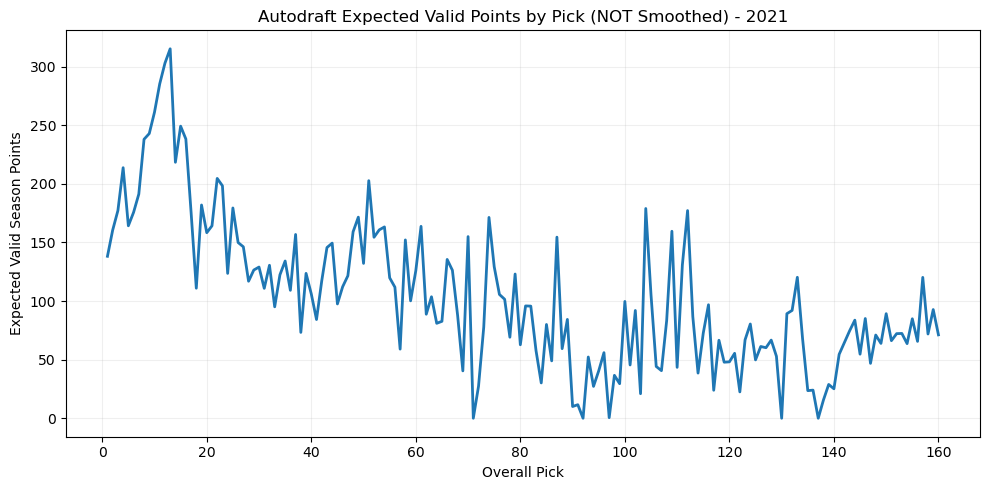

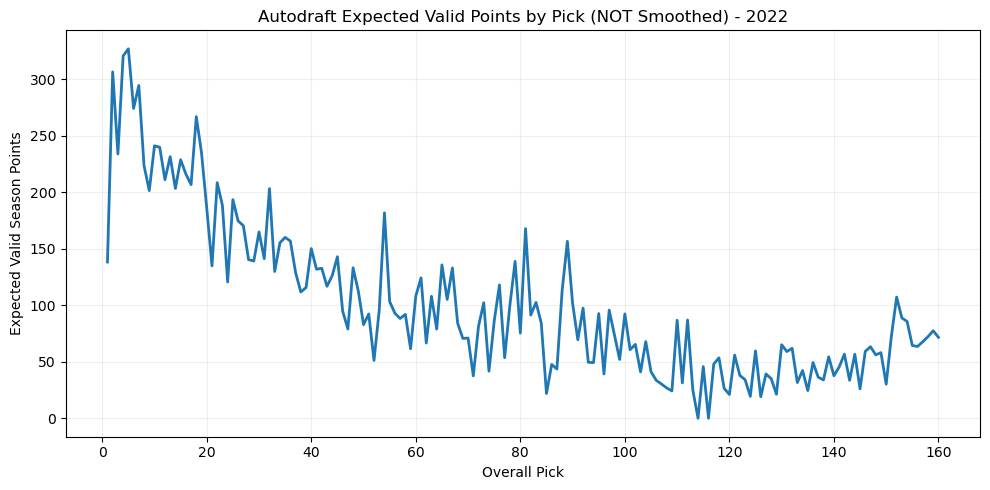

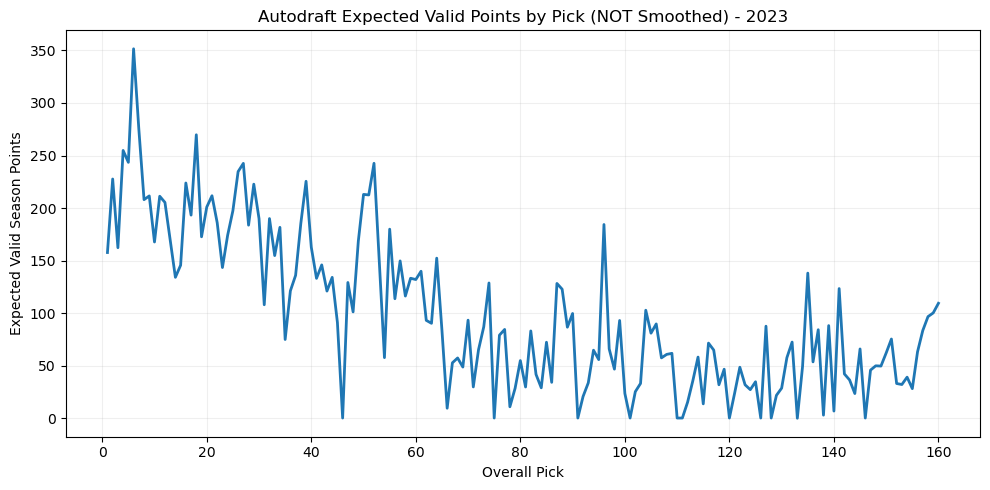

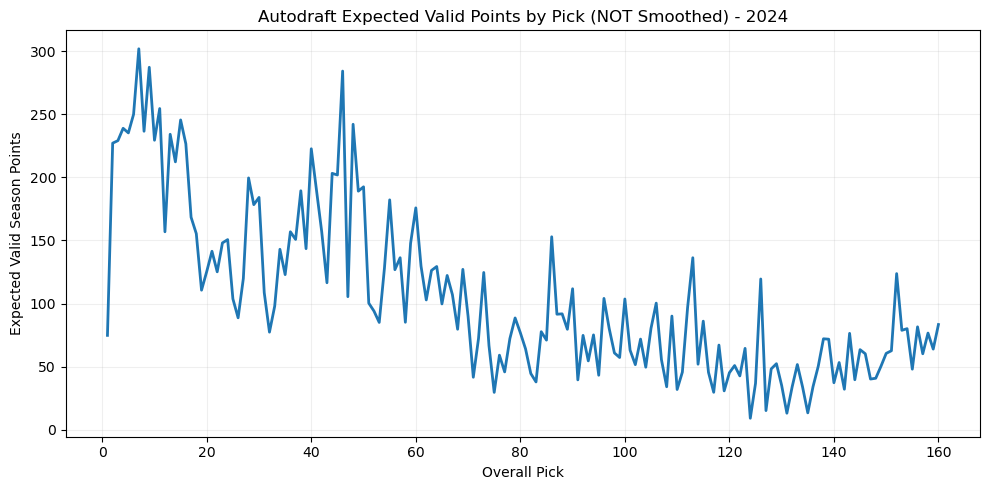

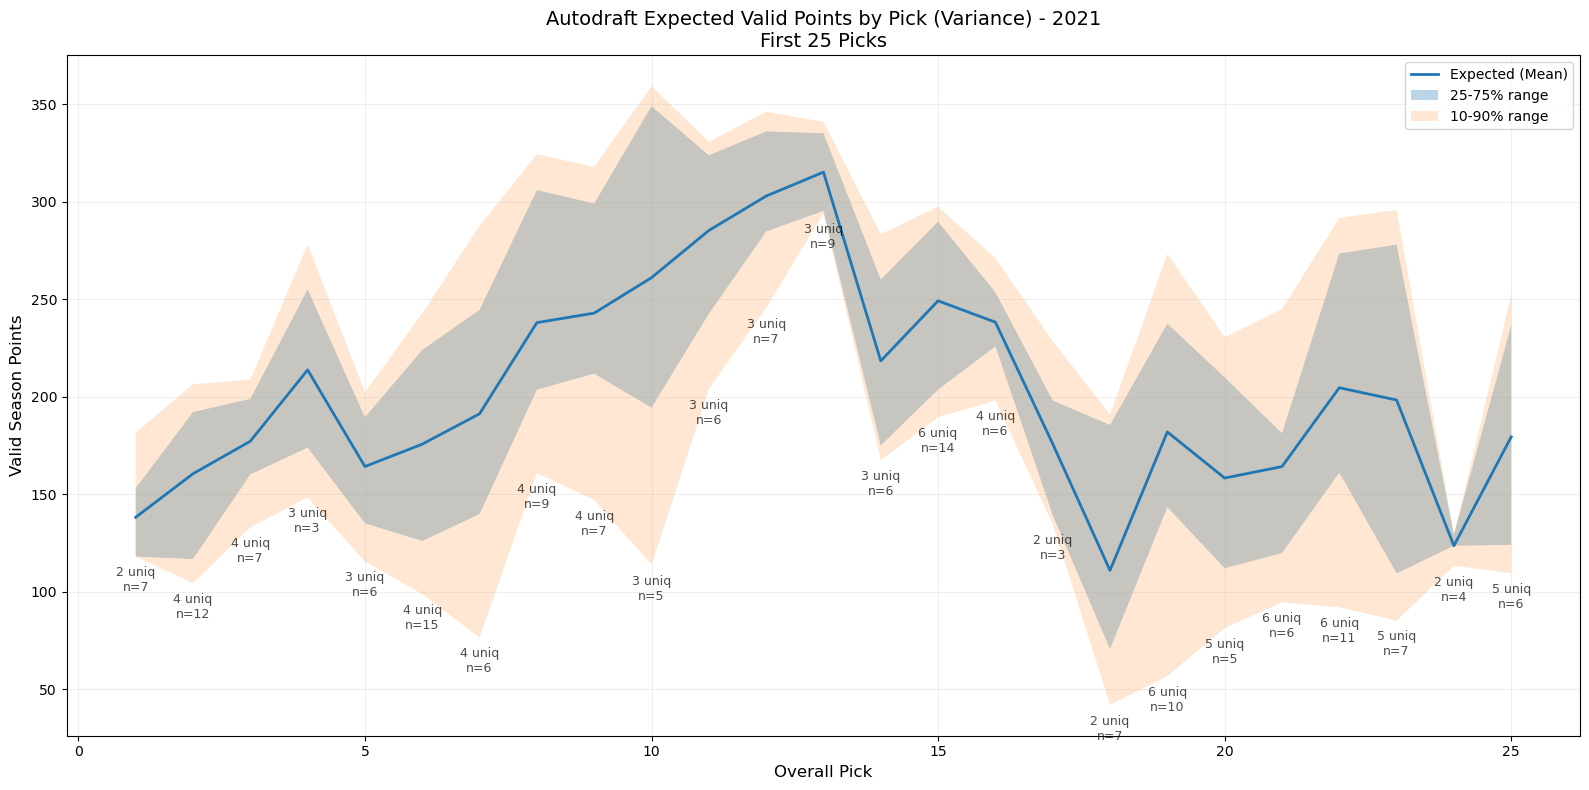

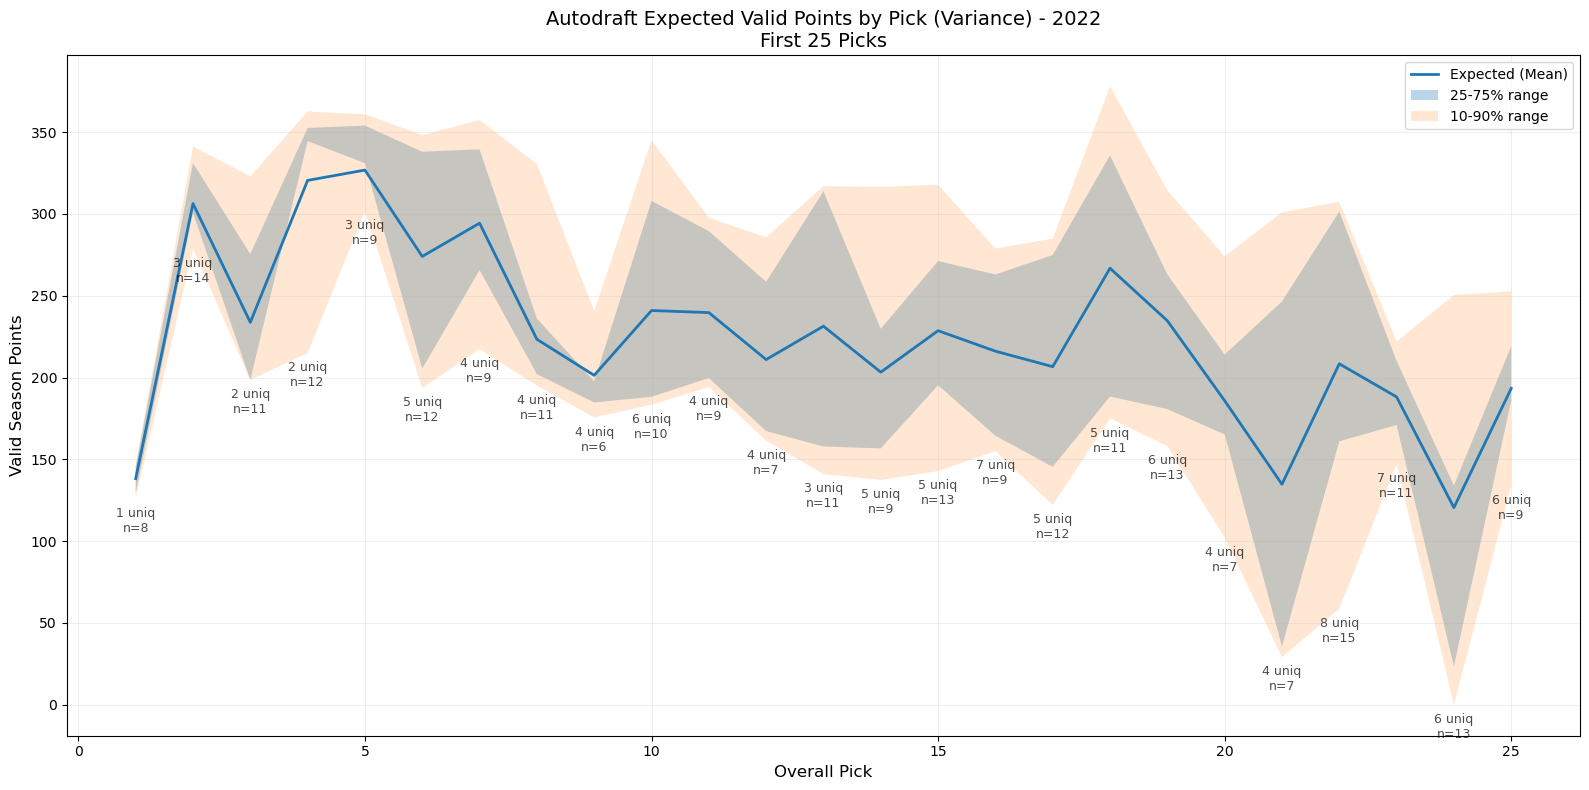

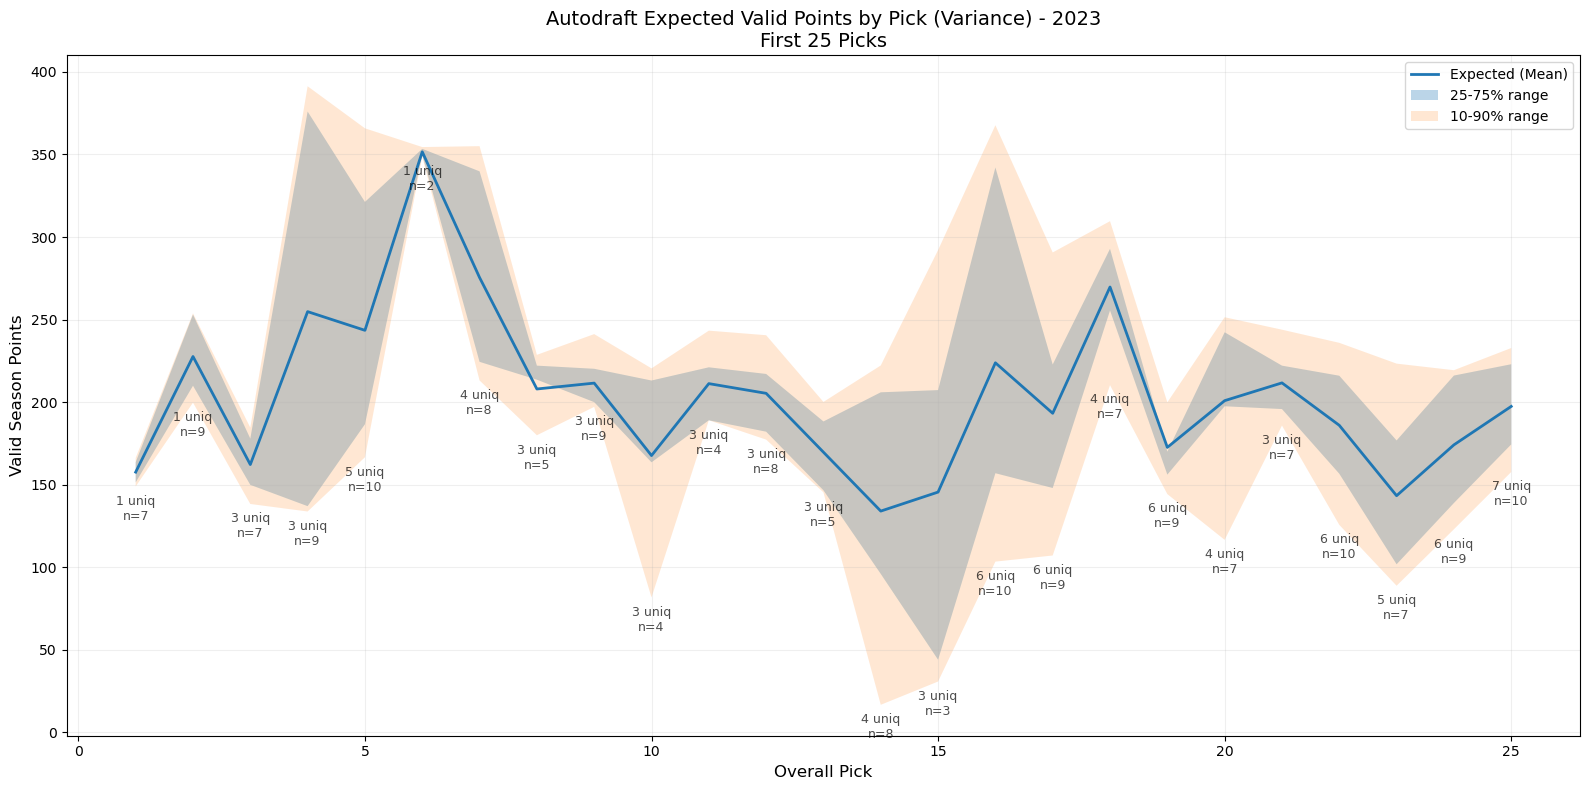

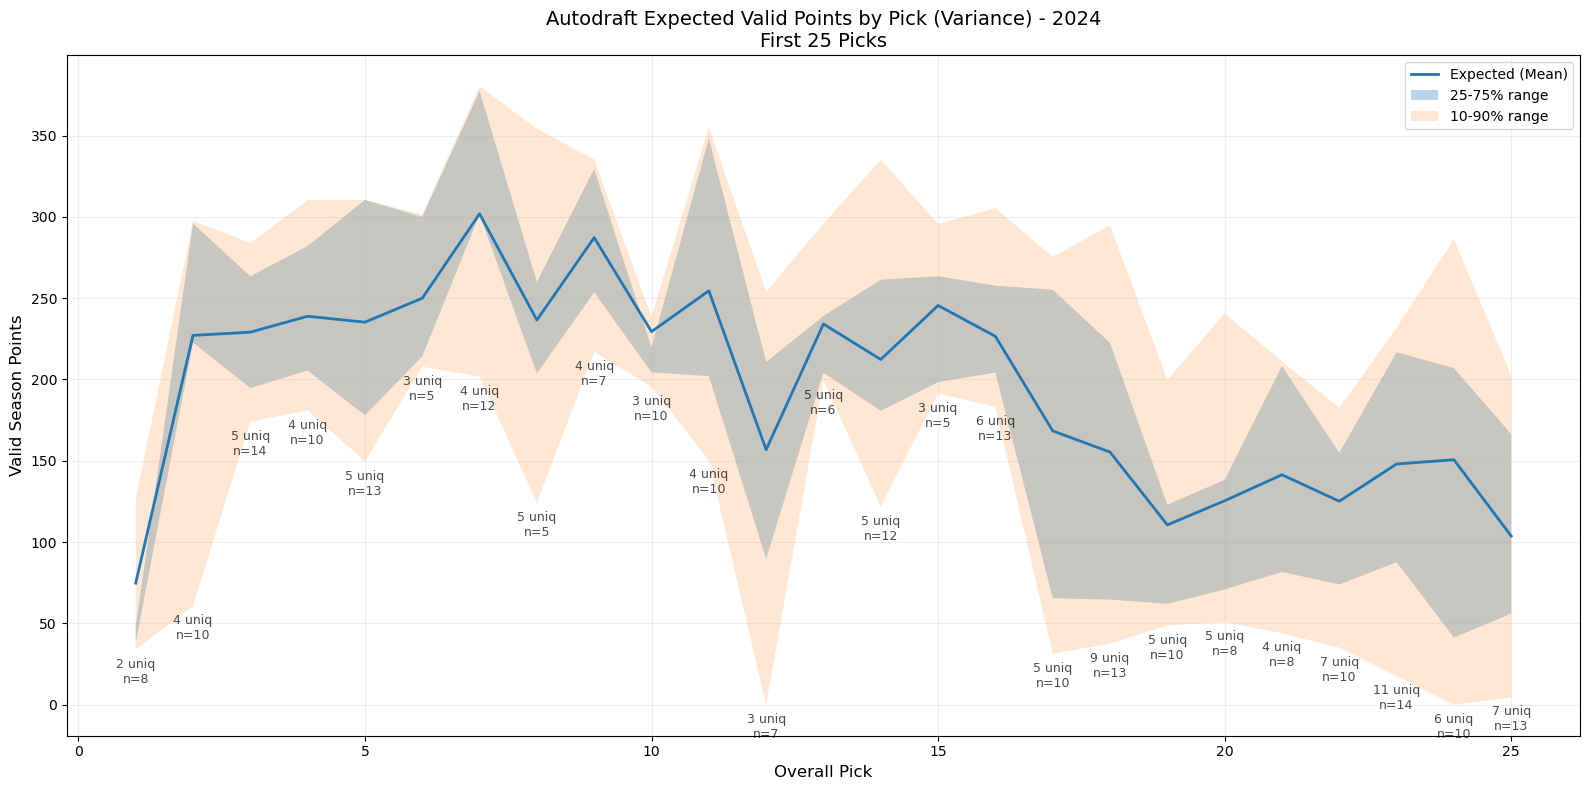

In [506]:
# ============================================================
# ADD-ON PLOTS - Per-season (NOT smoothed) + Per-season variance zoom (first 25)
# Assumes you already have:
#   - draft_with_valid (with Season_Total_Points_Valid, Player_norm, Overall, etc.)
#   - expected_valid_points_by_pick_from_autodraft
#   - expected_valid_points_by_pick_autodraft_distribution
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------
# Helper: compute dist BY YEAR
# ----------------------------
def expected_valid_points_by_pick_autodraft_distribution_by_year(
    draft_with_valid: pd.DataFrame
) -> pd.DataFrame:
    """
    Same as your pooled dist function, but returns one row per (Year, Overall)
    for fully-autodrafted teams only.

    Columns include: Mean, Std, N_Picks, Unique_Players, P10/P25/P50/P75/P90
    """
    required = [
        "League_ID","Year","Team",
        "Overall","Is_Autodrafted","Season_Total_Points_Valid","Player_norm"
    ]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    df = draft_with_valid.copy()

    # fully-autodrafted teams (per league-year-team)
    team_auto = (
        df.groupby(["League_ID","Year","Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Auto_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Auto_Picks"])

    df = df.merge(
        team_auto[["League_ID","Year","Team","Is_Fully_Autodrafted"]],
        on=["League_ID","Year","Team"],
        how="left"
    )
    df = df[df["Is_Fully_Autodrafted"]].copy()

    # distribution by (Year, Overall)
    dist = (
        df.groupby(["Year","Overall"], dropna=False)
          .agg(
              Mean=("Season_Total_Points_Valid", "mean"),
              Std=("Season_Total_Points_Valid", "std"),
              N_Picks=("Season_Total_Points_Valid", "count"),
              Unique_Players=("Player_norm", "nunique"),
              P10=("Season_Total_Points_Valid", lambda s: s.quantile(0.10)),
              P25=("Season_Total_Points_Valid", lambda s: s.quantile(0.25)),
              P50=("Season_Total_Points_Valid", lambda s: s.quantile(0.50)),
              P75=("Season_Total_Points_Valid", lambda s: s.quantile(0.75)),
              P90=("Season_Total_Points_Valid", lambda s: s.quantile(0.90)),
          )
          .reset_index()
          .sort_values(["Year","Overall"])
    )

    return dist


# ============================================================
# 15D - Individual expected valid points by pick for each season (NOT smoothed)
# ============================================================

expected_by_pick_year = expected_valid_points_by_pick_from_autodraft(
    draft_with_valid,
    by_year=True
)

for year, g in expected_by_pick_year.groupby("Year", sort=True):
    plt.figure(figsize=(10, 5))
    plt.plot(g["Overall"], g["Expected_Valid_Points"], linewidth=2)
    plt.xlabel("Overall Pick")
    plt.ylabel("Expected Valid Season Points")
    plt.title(f"Autodraft Expected Valid Points by Pick (NOT Smoothed) - {int(year)}")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


# ============================================================
# 15E - First 25 pick variance chart PER SEASON (with N + Unique Players)
# ============================================================

dist_y = expected_valid_points_by_pick_autodraft_distribution_by_year(draft_with_valid)

for year, g in dist_y.groupby("Year", sort=True):
    g25 = g[g["Overall"] <= 25].copy()
    if g25.empty:
        continue

    fig, ax = plt.subplots(figsize=(16, 8))

    # mean line
    ax.plot(g25["Overall"], g25["Mean"], linewidth=2, label="Expected (Mean)")

    # IQR band
    ax.fill_between(g25["Overall"], g25["P25"], g25["P75"], alpha=0.30, label="25-75% range")

    # 10-90 band
    ax.fill_between(g25["Overall"], g25["P10"], g25["P90"], alpha=0.18, label="10-90% range")

    ax.set_xlabel("Overall Pick", fontsize=12)
    ax.set_ylabel("Valid Season Points", fontsize=12)
    ax.set_title(f"Autodraft Expected Valid Points by Pick (Variance) - {int(year)}\nFirst 25 Picks", fontsize=14)

    # annotate: Unique players + n picks
    for _, r in g25.iterrows():
        y_annot = (r["P10"] if pd.notna(r["P10"]) else r["Mean"]) - 5
        ax.text(
            r["Overall"],
            y_annot,
            f"{int(r['Unique_Players'])} uniq\nn={int(r['N_Picks'])}",
            ha="center",
            va="top",
            fontsize=9,
            alpha=0.7
        )

    ax.legend()
    ax.grid(alpha=0.2)
    fig.tight_layout()
    plt.show()


# ============================================================
# Optional: quick table sanity print for one year
# ============================================================
# print(dist_y[dist_y["Year"] == 2024].head(10).to_string(index=False))


In [507]:
# Block 14 was here for some reason. 

In [508]:
# ============================================================
# BLOCK 16 - SCORE PICKS WITH MULTIPLE BASELINES
#   - Per-year mean baseline (Expected_Year)
#   - Pooled denoised baseline (Expected_Pooled_Denoised)
#   - Polynomial baseline fit to pooled denoised (Expected_Poly)
#
# Produces draft_scored with:
#   Points_Added_Year, Z_Year
#   Points_Added_Pooled, Z_Pooled
#   Points_Added_Poly, Z_Poly
# ============================================================

import numpy as np
import pandas as pd

def score_picks_all_baselines(
    draft_with_valid: pd.DataFrame,
    *,
    estimator: str = "trimmed_mean",
    trim: float = 0.10,
    smooth_window: int = 5,
    poly_degree: int = 4,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      draft_scored,
      expected_by_pick_year,
      expected_by_pick_pooled_poly

    draft_scored gets points added + z-scores for:
      - per-year expected curve
      - pooled denoised curve
      - polynomial fit to pooled denoised
    """
    required = ["League_ID","Year","Team","Overall","Is_Autodrafted","Season_Total_Points_Valid"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"draft_with_valid missing columns: {missing}")

    df = draft_with_valid.copy()
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype(int)
    df["Overall"] = pd.to_numeric(df["Overall"], errors="coerce").astype(int)
    df["Is_Autodrafted"] = pd.to_numeric(df["Is_Autodrafted"], errors="coerce").fillna(0).astype(int)
    df["Season_Total_Points_Valid"] = pd.to_numeric(df["Season_Total_Points_Valid"], errors="coerce")

    # -------------------------
    # (A) Per-year baseline
    # -------------------------
    expected_by_pick_year = expected_valid_points_by_pick_from_autodraft(df, by_year=True).copy()
    expected_by_pick_year = expected_by_pick_year.rename(columns={
        "Expected_Valid_Points": "Expected_Year",
        "Std_Valid_Points": "Std_Year",
        "N": "N_Year",
    })

    draft_scored = df.merge(
        expected_by_pick_year[["Year","Overall","Expected_Year","Std_Year","N_Year"]],
        on=["Year","Overall"],
        how="left",
    )

    draft_scored["Points_Added_Year"] = draft_scored["Season_Total_Points_Valid"] - draft_scored["Expected_Year"]
    draft_scored["Z_Year"] = np.where(
        (draft_scored["Std_Year"].notna()) & (draft_scored["Std_Year"] > 0),
        draft_scored["Points_Added_Year"] / draft_scored["Std_Year"],
        np.nan
    )

    # -------------------------
    # (B) Pooled denoised + Poly
    # -------------------------
    expected_by_pick_pooled = expected_valid_points_by_pick_from_autodraft_pooled_denoised(
        df,
        estimator=estimator,
        trim=trim,
        smooth_window=smooth_window
    ).copy()

    # Fit polynomial to pooled denoised curve
    expected_by_pick_pooled_poly = fit_polynomial_baseline(
        expected_by_pick_pooled,
        y_col="Expected_Smoothed",
        w_col="N",
        degree=poly_degree
    ).copy()

    expected_by_pick_pooled_poly = expected_by_pick_pooled_poly.rename(columns={
        "Expected_Smoothed": "Expected_Pooled_Denoised",
        "Std_Valid_Points": "Std_Pooled",
        "N": "N_Pooled",
        "Poly_Expected": "Expected_Poly",
    })

    # Merge pooled baselines (one curve) by Overall only
    draft_scored = draft_scored.merge(
        expected_by_pick_pooled_poly[["Overall","Expected_Pooled_Denoised","Expected_Poly","Std_Pooled","N_Pooled"]],
        on="Overall",
        how="left",
    )

    # Points added for pooled denoised
    draft_scored["Points_Added_Pooled"] = (
        draft_scored["Season_Total_Points_Valid"] - draft_scored["Expected_Pooled_Denoised"]
    )
    draft_scored["Z_Pooled"] = np.where(
        (draft_scored["Std_Pooled"].notna()) & (draft_scored["Std_Pooled"] > 0),
        draft_scored["Points_Added_Pooled"] / draft_scored["Std_Pooled"],
        np.nan
    )

    # Points added for polynomial baseline
    draft_scored["Points_Added_Poly"] = (
        draft_scored["Season_Total_Points_Valid"] - draft_scored["Expected_Poly"]
    )
    # Reuse pooled std as scale for z (your prior choice)
    draft_scored["Z_Poly"] = np.where(
        (draft_scored["Std_Pooled"].notna()) & (draft_scored["Std_Pooled"] > 0),
        draft_scored["Points_Added_Poly"] / draft_scored["Std_Pooled"],
        np.nan
    )

    return draft_scored, expected_by_pick_year, expected_by_pick_pooled_poly


# ---- RUN ----
draft_scored, expected_by_pick_year, expected_by_pick_pooled_poly = score_picks_all_baselines(
    draft_with_valid,
    estimator="trimmed_mean",
    trim=0.10,
    smooth_window=5,
    poly_degree=4
)

# Optional quick peek
draft_scored[[
    "League_ID","Year","Team","Overall","Player_norm",
    "Season_Total_Points_Valid",
    "Expected_Year","Expected_Pooled_Denoised","Expected_Poly",
    "Points_Added_Year","Points_Added_Pooled","Points_Added_Poly",
    "Z_Year","Z_Pooled","Z_Poly"
]].head()


,League_ID,Year,Team,Overall,Player_norm,Season_Total_Points_Valid,Expected_Year,Expected_Pooled_Denoised,Expected_Poly,Points_Added_Year,Points_Added_Pooled,Points_Added_Poly,Z_Year,Z_Pooled,Z_Poly
0,915297,2021,5,1,Dalvin Cook,175.0,138.157143,191.682247,246.833018,36.842857,-16.682247,-71.833018,1.211229,-0.283373,-1.220191
1,915297,2021,8,2,Christian McCaffrey,113.0,160.476667,211.733114,243.058226,-47.476667,-98.733114,-130.058226,-0.633554,-1.139873,-1.501521
2,915297,2021,2,3,Alvin Kamara,181.0,177.171429,219.035116,239.356702,3.828571,-38.035116,-58.356702,0.113502,-0.624445,-0.958077
3,915297,2021,1,4,Saquon Barkley,134.0,213.733333,240.633830,235.726609,-79.733333,-106.633830,-101.726609,-0.983325,-1.178908,-1.124656
4,915297,2021,9,5,Derrick Henry,178.0,164.183333,249.816279,232.166136,13.816667,-71.816279,-54.166136,0.341745,-0.845585,-0.637767


# This needs sanity checking

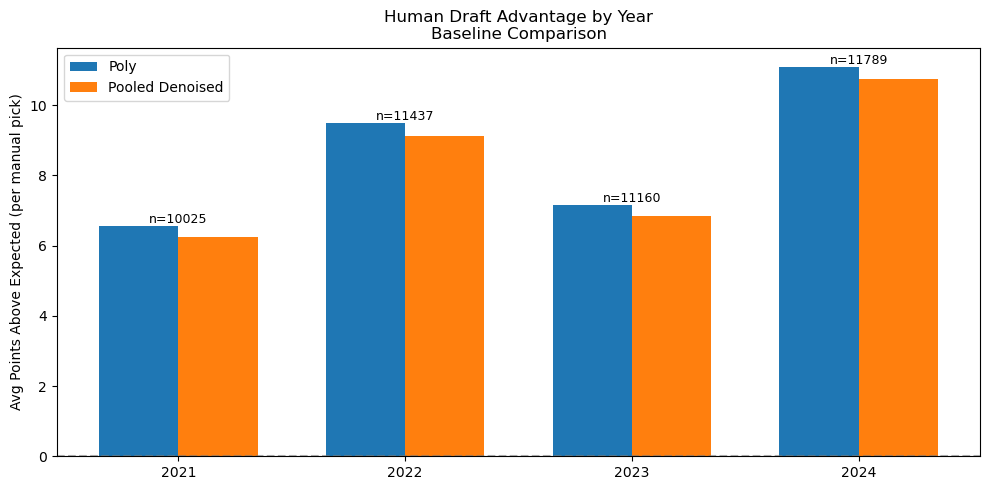

,Year,Manual_Picks,Avg_Points_Added_Poly,Avg_Points_Added_Pooled
0,2021,10025,6.553773,6.261204
1,2022,11437,9.485641,9.115308
2,2023,11160,7.170911,6.833586
3,2024,11789,11.084716,10.737564


In [509]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Guardrails: ensure Block 16 outputs exist ---
required_cols = {
    "Year", "Is_Autodrafted",
    "Points_Added_Poly", "Points_Added_Pooled"
}
missing = required_cols - set(draft_scored.columns)
if missing:
    raise ValueError(f"draft_scored missing required columns for Block 17+: {sorted(missing)}")

# Manual picks only
manual = draft_scored[draft_scored["Is_Autodrafted"] == 0].copy()

summary_year = (
    manual
    .groupby("Year", dropna=False)
    .agg(
        Manual_Picks=("Points_Added_Poly", "size"),
        Avg_Points_Added_Poly=("Points_Added_Poly", "mean"),
        Avg_Points_Added_Pooled=("Points_Added_Pooled", "mean"),
    )
    .reset_index()
    .sort_values("Year")
)

# Side-by-side bars
x = np.arange(len(summary_year))
w = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - w/2, summary_year["Avg_Points_Added_Poly"], width=w, label="Poly")
plt.bar(x + w/2, summary_year["Avg_Points_Added_Pooled"], width=w, label="Pooled Denoised")

plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, summary_year["Year"])
plt.ylabel("Avg Points Above Expected (per manual pick)")
plt.title("Human Draft Advantage by Year\nBaseline Comparison")

# annotate n
for i, r in summary_year.iterrows():
    y_top = max(r["Avg_Points_Added_Poly"], r["Avg_Points_Added_Pooled"])
    plt.text(i, y_top, f"n={int(r['Manual_Picks'])}", ha="center", va="bottom", fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

summary_year


# THIS ONE NEEDS DOUBLE CHECKING

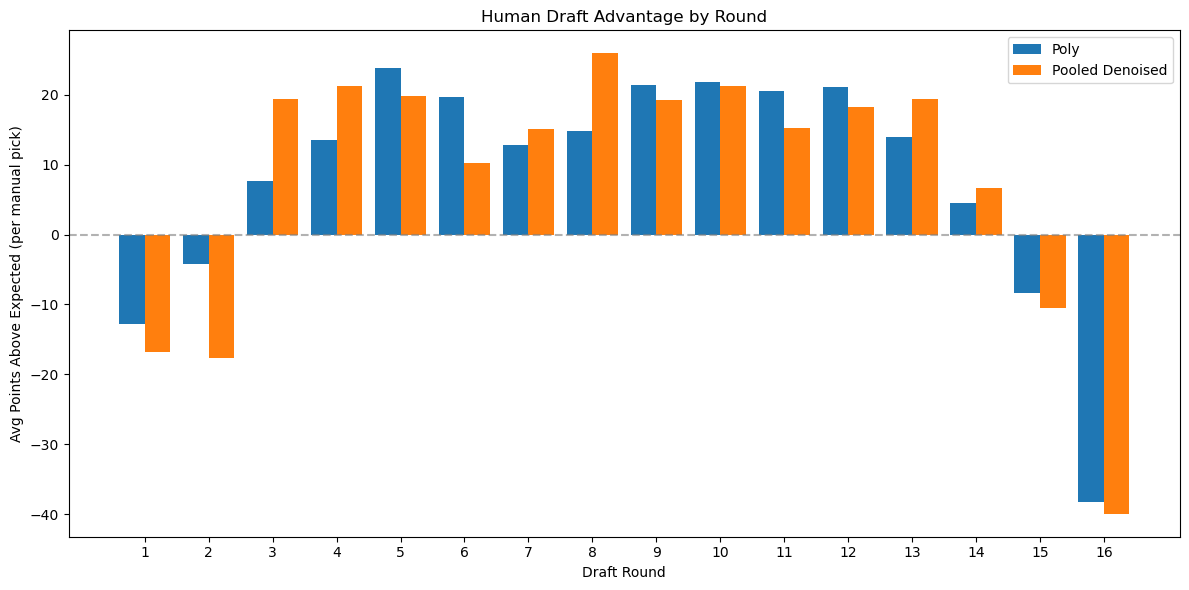

,Round,Manual_Picks,Avg_Poly,Avg_Pooled
0,1,2833,-12.774683,-16.848600
1,2,2854,-4.163175,-17.703532
2,3,2854,7.605781,19.410568
3,4,2865,13.553073,21.204497
4,5,2863,23.825107,19.805204
5,6,2859,19.712027,10.164276
6,7,2861,12.870015,15.108847
7,8,2842,14.833320,25.909239
8,9,2828,21.444989,19.290248
9,10,2801,21.755044,21.229925


In [510]:
# ============================================================
# BLOCK 17B - Avg Points Above Expected by ROUND (Manual picks)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Guardrails
required_cols_round = {"Round", "Points_Added_Poly", "Points_Added_Pooled"}
missing = required_cols_round - set(manual.columns)
if missing:
    raise ValueError(f"manual missing required columns for Block 17B: {sorted(missing)}")

summary_round = (
    manual
    .groupby("Round", dropna=False)
    .agg(
        Manual_Picks=("Points_Added_Poly", "size"),
        Avg_Poly=("Points_Added_Poly", "mean"),
        Avg_Pooled=("Points_Added_Pooled", "mean"),
    )
    .reset_index()
)

# ensure numeric sort
summary_round["Round"] = pd.to_numeric(summary_round["Round"], errors="coerce")
summary_round = summary_round.sort_values("Round")

x = np.arange(len(summary_round))
w = 0.4

plt.figure(figsize=(12,6))
plt.bar(x - w/2, summary_round["Avg_Poly"], width=w, label="Poly")
plt.bar(x + w/2, summary_round["Avg_Pooled"], width=w, label="Pooled Denoised")

plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, summary_round["Round"])
plt.xlabel("Draft Round")
plt.ylabel("Avg Points Above Expected (per manual pick)")
plt.title("Human Draft Advantage by Round")
plt.legend()
plt.tight_layout()
plt.show()

summary_round


# This one needs double checking too 

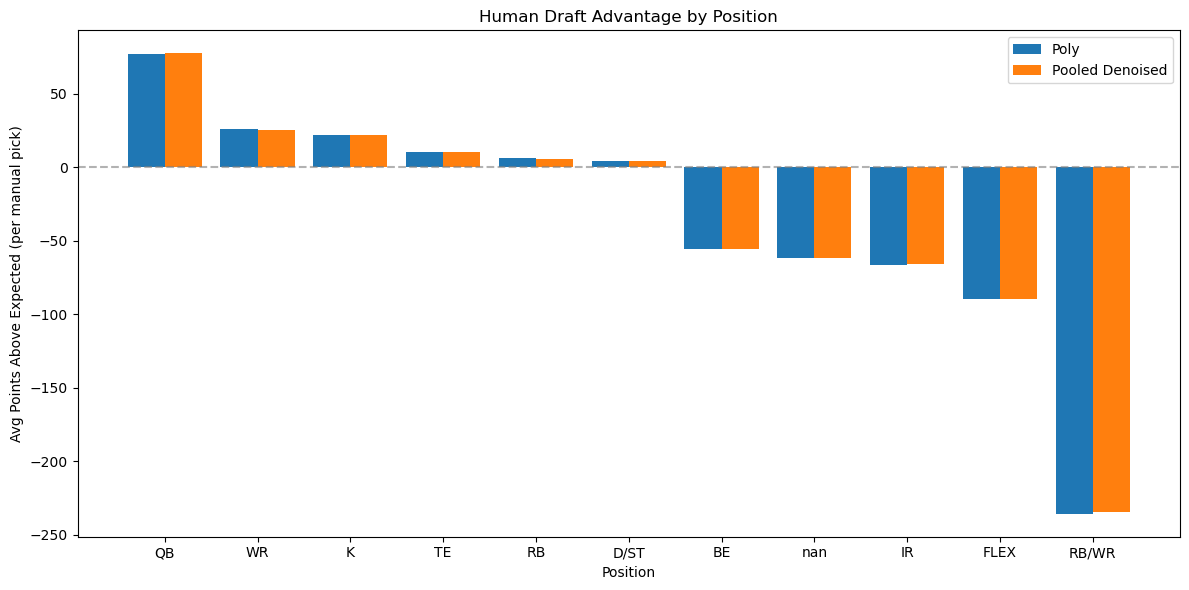

,Position,Manual_Picks,Avg_Poly,Avg_Pooled
5,QB,4374,77.414000,77.552754
9,WR,11775,25.981031,25.337584
4,K,2807,22.154130,21.828001
8,TE,4188,10.632987,10.190683
6,RB,10520,6.373585,5.854596
1,D/ST,2985,4.589616,4.389723
0,BE,6774,-55.555399,-55.462025
10,NaN,481,-61.809074,-61.928890
3,IR,201,-66.528455,-65.585635
2,FLEX,304,-89.483770,-89.479742


In [511]:
# ============================================================
# BLOCK 17C - Human Advantage by POSITION
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Guardrails
required_cols_pos = {"Position", "Points_Added_Poly", "Points_Added_Pooled"}
missing = required_cols_pos - set(manual.columns)
if missing:
    raise ValueError(f"manual missing required columns for Block 17C: {sorted(missing)}")

summary_pos = (
    manual
    .groupby("Position", dropna=False)
    .agg(
        Manual_Picks=("Points_Added_Poly", "size"),
        Avg_Poly=("Points_Added_Poly", "mean"),
        Avg_Pooled=("Points_Added_Pooled", "mean"),
    )
    .reset_index()
)

# Sort by one baseline for readability (pick whichever you prefer)
summary_pos = summary_pos.sort_values("Avg_Poly", ascending=False)

x = np.arange(len(summary_pos))
w = 0.4

plt.figure(figsize=(12,6))
plt.bar(x - w/2, summary_pos["Avg_Poly"], width=w, label="Poly")
plt.bar(x + w/2, summary_pos["Avg_Pooled"], width=w, label="Pooled Denoised")

plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, summary_pos["Position"])
plt.xlabel("Position")
plt.ylabel("Avg Points Above Expected (per manual pick)")
plt.title("Human Draft Advantage by Position")
plt.legend()
plt.tight_layout()
plt.show()

summary_pos



# Switching to Waiver Wire Baseline

In [512]:
# ============================================================
# BLOCK WW1 - LOAD + NORMALIZE TRANSACTIONS
#   Expects columns: League_ID, Week, Team, Player, Action
#   Adds: Year, Player_norm, Action_norm
# ============================================================

def load_transactions(path: Path, year: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = ["League_ID","Week","Team","Player","Action"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{path} transaction_data is missing columns: {missing}")

    df = df.copy()
    df["Year"] = int(year)
    df["League_ID"] = df["League_ID"].astype(int)
    df["Year"] = df["Year"].astype(int)
    df["Week"] = pd.to_numeric(df["Week"], errors="coerce").astype(int)
    df["Team"] = pd.to_numeric(df["Team"], errors="coerce").astype(int)

    df["Player_norm"] = df["Player"].map(normalize_player_name)

    df["Action_norm"] = df["Action"].astype(str).str.strip().str.upper()
    return df

def load_multi_season_transactions(raw_base: Path) -> pd.DataFrame:
    parts = []
    for year_dir in sorted([p for p in raw_base.iterdir() if p.is_dir() and p.name.isdigit() and len(p.name) == 4]):
        year = int(year_dir.name)
        tpath = year_dir / "transaction_data.csv"
        if tpath.exists():
            parts.append(load_transactions(tpath, year))
        else:
            print(f"Skipping {year}: missing {tpath}")
    if not parts:
        raise FileNotFoundError(f"No transaction_data.csv found under {raw_base}/<YEAR>/transaction_data.csv")
    return pd.concat(parts, ignore_index=True)

transactions_raw = load_multi_season_transactions(RAW_BASE)


In [513]:
# ============================================================
# BLOCK WW2 - FILTER TRANSACTIONS TO THE SAME LEAGUE-YEARS
#   Uses (League_ID, Year) pairs present in lineups_filt
# ============================================================

kept_league_years = lineups_filt[["League_ID","Year"]].drop_duplicates()
transactions_filt = transactions_raw.merge(kept_league_years, on=["League_ID","Year"], how="inner")

print(f"[transactions_filt] {len(transactions_filt):,} rows kept across {len(kept_league_years):,} league-years")


[transactions_filt] 116,318 rows kept across 334 league-years


In [514]:
# ============================================================
# BLOCK WW3 - BUILD WAIVER ADD STINTS (ADD -> NEXT DROP)
#   Output columns:
#     League_ID, Year, Team, Player_norm, Add_Week, End_Week
# ============================================================

WAIVER_ADD_ACTIONS = {"WAIVER_ADD", "FREEAGENT_ADD"}  # include FREEAGENT_ADD if it exists
DROP_ACTIONS = {"DROP"}  # add others if your data uses different labels (e.g., "WAIVER_DROP")

def build_waiver_add_stints(
    transactions: pd.DataFrame,
    *,
    season_end_week: int = 17,
    include_actions: set[str] | None = None,
    drop_actions: set[str] | None = None,
    min_week_after_add: int = 0,  # set to 1 if you want to force counting starts only from add_week+1
) -> pd.DataFrame:
    if include_actions is None:
        include_actions = WAIVER_ADD_ACTIONS
    if drop_actions is None:
        drop_actions = DROP_ACTIONS

    df = transactions.copy()
    required = {"League_ID","Year","Week","Team","Player_norm","Action_norm"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"transactions missing columns: {sorted(missing)}")

    adds = df[df["Action_norm"].isin(include_actions)].copy()
    drops = df[df["Action_norm"].isin(drop_actions)].copy()

    if adds.empty:
        raise ValueError("No waiver/free-agent add events found after filtering.")

    # For each add, find the next drop of that same player by that same team in same league-year
    # We do this by merging on keys and keeping drop_week >= add_week, then taking min drop_week per add row.
    adds = adds.sort_values(["League_ID","Year","Team","Player_norm","Week"]).reset_index(drop=True)
    adds["Add_ID"] = np.arange(len(adds), dtype=int)

    cand = adds.merge(
        drops[["League_ID","Year","Team","Player_norm","Week"]].rename(columns={"Week":"Drop_Week"}),
        on=["League_ID","Year","Team","Player_norm"],
        how="left"
    )

    cand = cand[cand["Drop_Week"].isna() | (cand["Drop_Week"] >= cand["Week"])].copy()

    next_drop = (
        cand.groupby("Add_ID", dropna=False)["Drop_Week"]
            .min()
            .reset_index()
    )

    adds = adds.merge(next_drop, on="Add_ID", how="left")
    # Add week
    adds["Add_Week"] = pd.to_numeric(adds["Week"], errors="coerce").astype(int)

    # Drop week stays numeric with NaN allowed
    adds["Drop_Week"] = pd.to_numeric(adds["Drop_Week"], errors="coerce")

    # End week: drop_week - 1 if drop exists, else season end
    adds["End_Week"] = np.where(
        adds["Drop_Week"].notna(),
        adds["Drop_Week"] - 1,
        int(season_end_week)
    ).astype(int)



    # Optional conservative rule: don't count the add week itself (timing ambiguity)
    adds["Start_Week_For_Credit"] = adds["Add_Week"] + int(min_week_after_add)

    out = adds[["League_ID","Year","Team","Player_norm","Add_Week","Start_Week_For_Credit","End_Week","Action_norm"]].copy()
    out = out.rename(columns={"Action_norm":"Add_Type"})

    # sanity clamp
    out["End_Week"] = out["End_Week"].clip(lower=0, upper=season_end_week)
    out = out[out["End_Week"] >= out["Start_Week_For_Credit"]].copy()

    return out

waiver_stints = build_waiver_add_stints(
    transactions_filt,
    season_end_week=17,
    min_week_after_add=1,  # conservative: only count from week after the add
)

print(waiver_stints.head(10))
print(f"[waiver_stints] {len(waiver_stints):,} stints")


    League_ID  Year  Team      Player_norm  Add_Week  Start_Week_For_Credit  \
3      760435  2022     1        Cole Kmet        11                     12   
4      760435  2022     1     Daniel Jones        16                     17   
5      760435  2022     1     Drake London        16                     17   
8      760435  2022     1      Graham Gano        10                     11   
10     760435  2022     1     Greg Dulcich        14                     15   
11     760435  2022     1    Isaiah Likely         9                     10   
12     760435  2022     1    Jarvis Landry        11                     12   
13     760435  2022     1      Jason Myers        12                     13   
14     760435  2022     1  Jimmy Garoppolo        12                     13   
16     760435  2022     1   Kadarius Toney         8                      9   

    End_Week    Add_Type  
3         17  WAIVER_ADD  
4         17  WAIVER_ADD  
5         17  WAIVER_ADD  
8         11  WAIVER_A

In [515]:
# ============================================================
# BLOCK WW4 - VALID WAIVER POINTS USING optimal_selected
#   Valid = WeekPoints where SelectedOptimal==True
#   Sum within each add-stint window.
# ============================================================

def compute_valid_waiver_points(
    waiver_stints: pd.DataFrame,
    optimal_selected: pd.DataFrame
) -> pd.DataFrame:
    req_s = {"League_ID","Year","Team","Player_norm","Start_Week_For_Credit","End_Week","Add_Week","Add_Type"}
    missing = req_s - set(waiver_stints.columns)
    if missing:
        raise ValueError(f"waiver_stints missing columns: {sorted(missing)}")

    req_o = {"League_ID","Year","Team","Week","Player_norm","WeekPoints","SelectedOptimal","Position"}
    missing = req_o - set(optimal_selected.columns)
    if missing:
        raise ValueError(f"optimal_selected missing columns: {sorted(missing)}")

    osel = optimal_selected.copy()
    osel["Week"] = pd.to_numeric(osel["Week"], errors="coerce").astype(int)
    osel["WeekPoints"] = pd.to_numeric(osel["WeekPoints"], errors="coerce").fillna(0.0)
    osel["ValidWeekPoints"] = np.where(osel["SelectedOptimal"].astype(bool), osel["WeekPoints"], 0.0)

    # Join stints to weekly player rows (same league-year-team-player)
    joined = waiver_stints.merge(
        osel[["League_ID","Year","Team","Week","Player_norm","Position","ValidWeekPoints"]],
        on=["League_ID","Year","Team","Player_norm"],
        how="left"
    )

    # Keep only weeks in stint window
    joined = joined[
        (joined["Week"].notna()) &
        (joined["Week"].astype(int) >= joined["Start_Week_For_Credit"].astype(int)) &
        (joined["Week"].astype(int) <= joined["End_Week"].astype(int))
    ].copy()

    # Aggregate to stint
    stint_points = (
        joined.groupby(["League_ID","Year","Team","Player_norm","Add_Week","Start_Week_For_Credit","End_Week","Add_Type","Position"], dropna=False)
              .agg(
                  Valid_Points=("ValidWeekPoints","sum"),
                  Weeks_Observed=("Week","nunique"),
              )
              .reset_index()
    )

    # If a player never appears in optimal_selected during the window, they won't show up at all in joined.
    # Add explicit zeros for those stints:
    out = waiver_stints.merge(
        stint_points,
        on=["League_ID","Year","Team","Player_norm","Add_Week","Start_Week_For_Credit","End_Week","Add_Type"],
        how="left"
    )
    out["Valid_Points"] = pd.to_numeric(out["Valid_Points"], errors="coerce").fillna(0.0)
    out["Weeks_Observed"] = pd.to_numeric(out["Weeks_Observed"], errors="coerce").fillna(0).astype(int)
    out["Position"] = out["Position"].fillna("UNKNOWN")

    return out

waiver_with_valid = compute_valid_waiver_points(waiver_stints, optimal_selected)

print(waiver_with_valid.sort_values("Valid_Points", ascending=False).head(20))


       League_ID  Year  Team     Player_norm  Add_Week  Start_Week_For_Credit  \
12737    1070186  2024    16      Jared Goff         5                      6   
12750    1070186  2024    17  Baker Mayfield         3                      4   
9463     1008665  2024     8  Baker Mayfield         2                      3   
19536    1195564  2024    10  Baker Mayfield         2                      3   
21254    1209408  2024     2  Jayden Daniels         2                      3   
1745      867875  2024     1  Baker Mayfield         2                      3   
25606    1268773  2023     4     Brock Purdy         2                      3   
33645    1381421  2024     7  Baker Mayfield         3                      4   
29001    1320877  2024     4  Baker Mayfield         2                      3   
21280    1209408  2024     4  Baker Mayfield         2                      3   
18274    1175115  2023     6     Jordan Love         2                      3   
41556   18387016  2023     7

In [516]:
# ============================================================
# BLOCK WW6a (Deprecated) - compatibility guard
# This legacy cell depended on variables not built by the current
# top-to-bottom pipeline. Use BLOCK WW6b below.
# ============================================================
required = {"N_COLS","teams","per_team_pivots","per_team_cum","FIG_W","FIG_H_PER_ROW","WEEKS","TOP_K_PER_TEAM","SHOW_OTHER","LEAGUE_ID","YEAR"}
missing = [v for v in required if v not in globals()]
if missing:
    print("[WW6a] Skipped legacy plotting cell; missing vars: " + ", ".join(sorted(missing)))
    print("[WW6a] Run BLOCK WW6b for the maintained version.")
else:
    print("[WW6a] Legacy variables detected. Prefer BLOCK WW6b for maintained plotting.")


[WW6a] Skipped legacy plotting cell; missing vars: TOP_K_PER_TEAM
[WW6a] Run BLOCK WW6b for the maintained version.


In [517]:
# ============================================================
# BLOCK WW6 - Waiver baseline candidates (minimal competency framing)
#   Goal: define waiver baseline comparable in spirit to autodraft baseline.
#   Unit = valid points per waiver stint-week.
# ============================================================

import numpy as np
import pandas as pd

required_objs = ["waiver_with_valid"]
missing_objs = [x for x in required_objs if x not in globals()]
if missing_objs:
    raise ValueError(f"Missing required objects: {missing_objs}. Run WW3-WW4 first.")

w = waiver_with_valid.copy()
req = {"League_ID", "Year", "Team", "Valid_Points", "Weeks_Observed"}
missing = req - set(w.columns)
if missing:
    raise ValueError(f"waiver_with_valid missing columns: {sorted(missing)}")

w["Year"] = pd.to_numeric(w["Year"], errors="coerce").astype(int)
w["Valid_Points"] = pd.to_numeric(w["Valid_Points"], errors="coerce").fillna(0.0)
w["Weeks_Observed"] = pd.to_numeric(w["Weeks_Observed"], errors="coerce").fillna(0).astype(int)
w = w[w["Weeks_Observed"] > 0].copy()
if w.empty:
    raise ValueError("No waiver stints with Weeks_Observed > 0.")

w["Stint_Weekly_Rate"] = w["Valid_Points"] / w["Weeks_Observed"]

team_season = (
    w.groupby(["League_ID", "Year", "Team"], dropna=False)
     .agg(
         TeamSeason_Valid=("Valid_Points", "sum"),
         TeamSeason_Weeks=("Weeks_Observed", "sum"),
     )
     .reset_index()
)
team_season = team_season[team_season["TeamSeason_Weeks"] > 0].copy()
team_season["TeamSeason_Weekly_Rate"] = team_season["TeamSeason_Valid"] / team_season["TeamSeason_Weeks"]

BASELINE_CANDIDATES = {
    # population mean: not minimal competency, but useful reference
    "avg_stint_week": float(w["Valid_Points"].sum() / w["Weeks_Observed"].sum()),
    # robust central tendency
    "median_team_season": float(team_season["TeamSeason_Weekly_Rate"].median()),
    # minimal competency proxy (recommended default)
    "q25_team_season": float(team_season["TeamSeason_Weekly_Rate"].quantile(0.25)),
}

# choose canonical waiver baseline here
WAIVER_BASELINE_NAME = "q25_team_season"
WAIVER_BASELINE_VALUE = float(BASELINE_CANDIDATES[WAIVER_BASELINE_NAME])

baseline_table = pd.DataFrame({
    "Baseline": list(BASELINE_CANDIDATES.keys()),
    "Value_valid_points_per_stint_week": list(BASELINE_CANDIDATES.values()),
}).sort_values("Value_valid_points_per_stint_week")

print(f"Selected baseline: {WAIVER_BASELINE_NAME} = {WAIVER_BASELINE_VALUE:.3f}")
print(f"Zero-rate share among stints: {(w['Stint_Weekly_Rate'] == 0).mean():.1%}")
baseline_table


Selected baseline: q25_team_season = 4.865
Zero-rate share among stints: 37.1%


,Baseline,Value_valid_points_per_stint_week
2,q25_team_season,4.864883
1,median_team_season,5.935527
0,avg_stint_week,6.056750


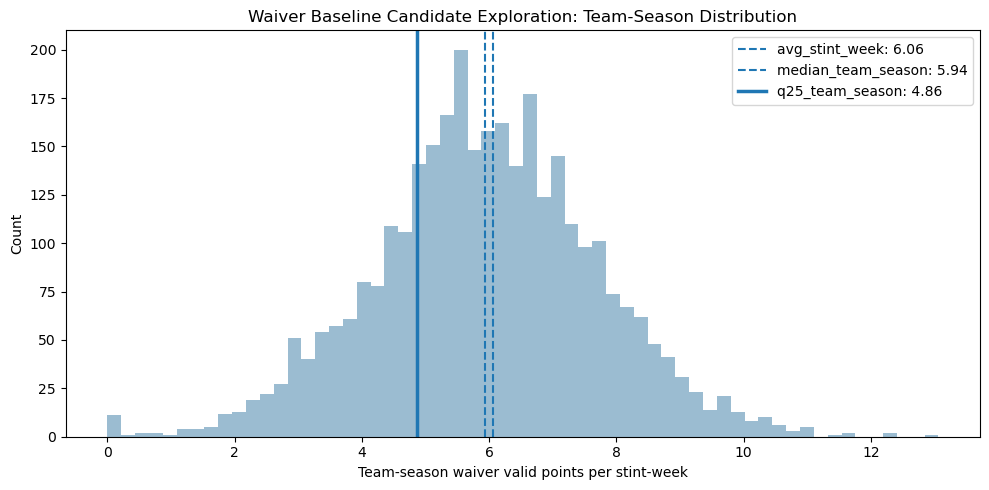

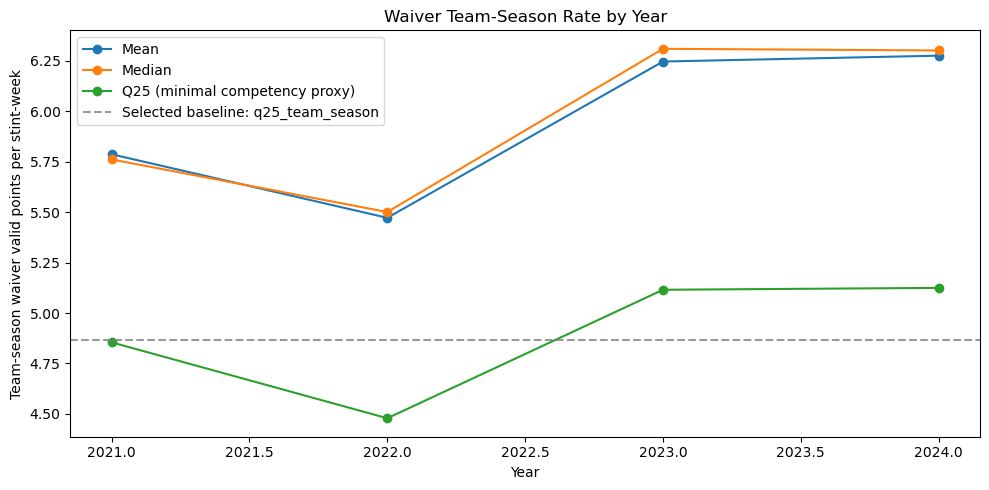

,Year,Mean,Median,Q25,N
0,2021,5.786780,5.761323,4.854600,716
1,2022,5.471928,5.500536,4.478387,841
2,2023,6.246450,6.309524,5.115182,791
3,2024,6.275569,6.301341,5.124579,864


In [518]:
# ============================================================
# BLOCK WW7 - Baseline exploration visuals for waiver wire
#   1) Distribution of team-season waiver rates + candidate lines
#   2) Yearly trend of team-season waiver rates (mean/median/q25)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

required = ["team_season", "BASELINE_CANDIDATES", "WAIVER_BASELINE_NAME", "WAIVER_BASELINE_VALUE"]
missing = [x for x in required if x not in globals()]
if missing:
    raise ValueError(f"Run WW6 first. Missing: {missing}")

# (1) Team-season distribution
plt.figure(figsize=(10, 5))
plt.hist(team_season["TeamSeason_Weekly_Rate"], bins=60, alpha=0.75, color="#7AA6C2")
for name, val in BASELINE_CANDIDATES.items():
    ls = "-" if name == WAIVER_BASELINE_NAME else "--"
    lw = 2.5 if name == WAIVER_BASELINE_NAME else 1.5
    plt.axvline(val, linestyle=ls, linewidth=lw, label=f"{name}: {val:.2f}")
plt.xlabel("Team-season waiver valid points per stint-week")
plt.ylabel("Count")
plt.title("Waiver Baseline Candidate Exploration: Team-Season Distribution")
plt.legend()
plt.tight_layout()
plt.show()

# (2) Yearly trend
y = (
    team_season.groupby("Year", dropna=False)["TeamSeason_Weekly_Rate"]
    .agg(Mean="mean", Median="median", Q25=lambda s: s.quantile(0.25), N="size")
    .reset_index()
    .sort_values("Year")
)

plt.figure(figsize=(10, 5))
plt.plot(y["Year"], y["Mean"], marker="o", label="Mean")
plt.plot(y["Year"], y["Median"], marker="o", label="Median")
plt.plot(y["Year"], y["Q25"], marker="o", label="Q25 (minimal competency proxy)")
plt.axhline(WAIVER_BASELINE_VALUE, linestyle="--", color="gray", alpha=0.8,
            label=f"Selected baseline: {WAIVER_BASELINE_NAME}")
plt.xlabel("Year")
plt.ylabel("Team-season waiver valid points per stint-week")
plt.title("Waiver Team-Season Rate by Year")
plt.legend()
plt.tight_layout()
plt.show()

y


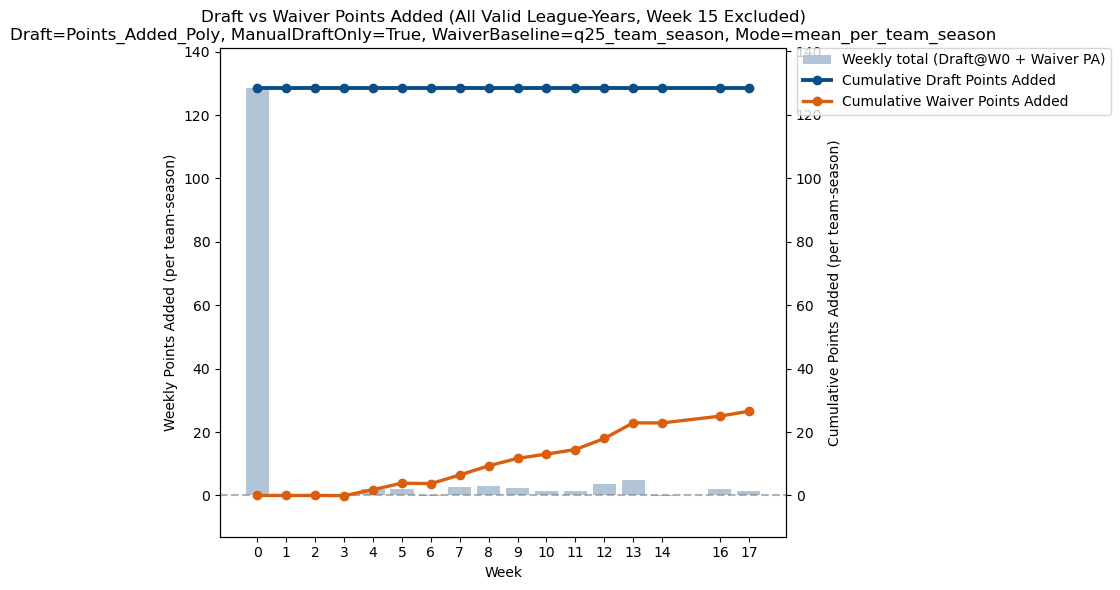

Team-seasons: 2,998
Selected waiver baseline: q25_team_season = 4.865
Draft metric used in WW8: Points_Added_Poly
Draft mean points added per manual pick (Points_Added_Poly): 8.6666
Draft Week-0 raw total points added: 384893.93
Draft Week-0 cross-check total (sum team-seasons): 384893.93
Difference (should be 0): 0.00000000
Draft Week-0 displayed value (per team-season): 128.3836
Draft mean team-season points added (cross-check): 128.3836
Difference (should be ~0): 0.00000000
Waiver season points added (mean_per_team_season, week15 excluded): 26.56


In [519]:
# ============================================================
# BLOCK WW8 - Draft vs Waiver points added using selected waiver baseline
#   - All valid leagues/seasons
#   - Draft points added assigned to Week 0
#   - Waiver points added by week vs WAIVER_BASELINE_VALUE
#   - Week 15 excluded
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DRAFT_POINTS_COL = "Points_Added_Poly"
MANUAL_DRAFT_ONLY = True
SEASON_END_WEEK = 17
IGNORE_WEEKS = {15}
AGG_MODE = "mean_per_team_season"

required_objs = ["draft_scored", "waiver_stints", "optimal_selected", "WAIVER_BASELINE_VALUE", "WAIVER_BASELINE_NAME"]
missing_objs = [x for x in required_objs if x not in globals()]
if missing_objs:
    raise ValueError(f"Missing required objects: {missing_objs}. Run draft scoring + WW6 first.")

if DRAFT_POINTS_COL not in draft_scored.columns:
    raise ValueError(f"draft_scored missing {DRAFT_POINTS_COL}")

d = draft_scored.copy()
if MANUAL_DRAFT_ONLY:
    d = d[d["Is_Autodrafted"] == 0].copy()
d[DRAFT_POINTS_COL] = pd.to_numeric(d[DRAFT_POINTS_COL], errors="coerce").fillna(0.0)
draft_week0_total = float(d[DRAFT_POINTS_COL].sum())
team_seasons_n = d[["League_ID", "Year", "Team"]].drop_duplicates().shape[0]
if team_seasons_n <= 0:
    raise ValueError("No team-seasons after draft filters.")

team_season_draft = (
    d.groupby(["League_ID", "Year", "Team"], dropna=False)[DRAFT_POINTS_COL]
     .sum().reset_index(name="Draft_PA_TeamSeason")
)
draft_week0_check_total = float(team_season_draft["Draft_PA_TeamSeason"].sum())
draft_week0_check_mean = float(team_season_draft["Draft_PA_TeamSeason"].mean())

draft_per_manual_pick = float(d[DRAFT_POINTS_COL].mean())

osel = optimal_selected.copy()
osel["Week"] = pd.to_numeric(osel["Week"], errors="coerce")
osel["WeekPoints"] = pd.to_numeric(osel["WeekPoints"], errors="coerce").fillna(0.0)
osel["SelectedOptimal"] = osel["SelectedOptimal"].fillna(False).astype(bool)
osel["ValidWeekPoints"] = np.where(osel["SelectedOptimal"], osel["WeekPoints"], 0.0)

joined = waiver_stints.merge(
    osel[["League_ID", "Year", "Team", "Week", "Player_norm", "ValidWeekPoints"]],
    on=["League_ID", "Year", "Team", "Player_norm"],
    how="left"
)
joined = joined[
    joined["Week"].notna() &
    (joined["Week"].astype(int) >= joined["Start_Week_For_Credit"].astype(int)) &
    (joined["Week"].astype(int) <= joined["End_Week"].astype(int))
].copy()
joined["Week"] = pd.to_numeric(joined["Week"], errors="coerce").astype(int)
joined = joined[(joined["Week"] >= 1) & (joined["Week"] <= SEASON_END_WEEK)].copy()
joined = joined[~joined["Week"].isin(IGNORE_WEEKS)].copy()

waiver_valid_week = joined.groupby("Week", dropna=False)["ValidWeekPoints"].sum().reset_index(name="Waiver_ValidSum")

exp_rows = []
for _, r in waiver_stints.iterrows():
    s = int(r["Start_Week_For_Credit"])
    e = int(r["End_Week"])
    if e < s: continue
    s = max(1, s); e = min(SEASON_END_WEEK, e)
    if e < s: continue
    exp_rows.extend([wk for wk in range(s, e + 1) if wk not in IGNORE_WEEKS])

if len(exp_rows) == 0:
    raise ValueError("No active waiver stint-weeks found for expected-value denominator.")

active_stints_week = pd.Series(exp_rows, name="Week").value_counts().rename_axis("Week").reset_index(name="Active_StintWeeks")
waiver_week = active_stints_week.merge(waiver_valid_week, on="Week", how="left")
waiver_week["Waiver_ValidSum"] = waiver_week["Waiver_ValidSum"].fillna(0.0)
waiver_week["Waiver_PointsAdded"] = waiver_week["Waiver_ValidSum"] - WAIVER_BASELINE_VALUE * waiver_week["Active_StintWeeks"]

weeks = [0] + [wk for wk in range(1, SEASON_END_WEEK + 1) if wk not in IGNORE_WEEKS]
draft_weekly = pd.Series(0.0, index=weeks)
waiver_weekly = pd.Series(0.0, index=weeks)

draft_weekly.loc[0] = draft_week0_total
for _, r in waiver_week.iterrows():
    wk = int(r["Week"])
    if wk in waiver_weekly.index:
        waiver_weekly.loc[wk] = float(r["Waiver_PointsAdded"])

if AGG_MODE == "mean_per_team_season":
    draft_weekly = draft_weekly / team_seasons_n
    waiver_weekly = waiver_weekly / team_seasons_n
elif AGG_MODE != "total":
    raise ValueError("AGG_MODE must be total or mean_per_team_season")

bars = draft_weekly + waiver_weekly
cum_draft = draft_weekly.cumsum()
cum_waiver = waiver_weekly.cumsum()

bar_vals = bars.to_numpy(dtype=float)
line_vals = np.concatenate([cum_draft.to_numpy(dtype=float), cum_waiver.to_numpy(dtype=float)])

bar_ymin = float(np.min(bar_vals)); bar_ymax = float(np.max(bar_vals))
if bar_ymax <= bar_ymin: bar_ymax = bar_ymin + 1.0
bar_pad = max(1.0, 0.10 * (bar_ymax - bar_ymin)); bar_ymin -= bar_pad; bar_ymax += bar_pad

line_ymin_raw = float(np.min(line_vals)); line_ymax_raw = float(np.max(line_vals))
if line_ymax_raw <= line_ymin_raw: line_ymax_raw = line_ymin_raw + 1.0
line_pad = max(1.0, 0.10 * (line_ymax_raw - line_ymin_raw)); line_ymin_raw -= line_pad; line_ymax_raw += line_pad

bar_range = max(bar_ymax - bar_ymin, 1.0)
zero_frac = (0.0 - bar_ymin) / bar_range
line_range = max(line_ymax_raw - line_ymin_raw, 1.0)
line_ymin = -zero_frac * line_range
line_ymax = line_ymin + line_range

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.set_zorder(1); ax2.set_zorder(2); ax1.patch.set_visible(False)

ax1.bar(weeks, bars.values, color="#9FB7CC", alpha=0.8, label="Weekly total (Draft@W0 + Waiver PA)")
ax1.axhline(0, linestyle="--", color="gray", alpha=0.6)
ax1.set_xlabel("Week")
ax1.set_xticks(weeks)
ax1.set_ylabel("Weekly Points Added" + (" (per team-season)" if AGG_MODE == "mean_per_team_season" else ""))
ax1.set_ylim(bar_ymin, bar_ymax)

ax2.plot(weeks, cum_draft.values, marker="o", linewidth=2.8, color="#0B4F8A", label="Cumulative Draft Points Added", zorder=5)
ax2.plot(weeks, cum_waiver.values, marker="o", linewidth=2.4, color="#D95F0E", label="Cumulative Waiver Points Added", zorder=5)
ax2.set_ylabel("Cumulative Points Added" + (" (per team-season)" if AGG_MODE == "mean_per_team_season" else ""))
ax2.set_ylim(line_ymin, line_ymax)

h1, l1 = ax1.get_legend_handles_labels(); h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1 + h2, l1 + l2, loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

plt.title(
    "Draft vs Waiver Points Added (All Valid League-Years, Week 15 Excluded)\n"
    f"Draft={DRAFT_POINTS_COL}, ManualDraftOnly={MANUAL_DRAFT_ONLY}, WaiverBaseline={WAIVER_BASELINE_NAME}, Mode={AGG_MODE}"
)
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

print(f"Team-seasons: {team_seasons_n:,}")
print(f"Selected waiver baseline: {WAIVER_BASELINE_NAME} = {WAIVER_BASELINE_VALUE:.3f}")
print(f"Draft metric used in WW8: {DRAFT_POINTS_COL}")
print(f"Draft mean points added per manual pick ({DRAFT_POINTS_COL}): {draft_per_manual_pick:.4f}")
print(f"Draft Week-0 raw total points added: {draft_week0_total:.2f}")
print(f"Draft Week-0 cross-check total (sum team-seasons): {draft_week0_check_total:.2f}")
print(f"Difference (should be 0): {draft_week0_total - draft_week0_check_total:.8f}")
if AGG_MODE == "mean_per_team_season":
    print(f"Draft Week-0 displayed value (per team-season): {draft_weekly.loc[0]:.4f}")
    print(f"Draft mean team-season points added (cross-check): {draft_week0_check_mean:.4f}")
    print(f"Difference (should be ~0): {draft_weekly.loc[0] - draft_week0_check_mean:.8f}")
print(f"Waiver season points added ({AGG_MODE}, week15 excluded): {waiver_weekly.sum():.2f}")


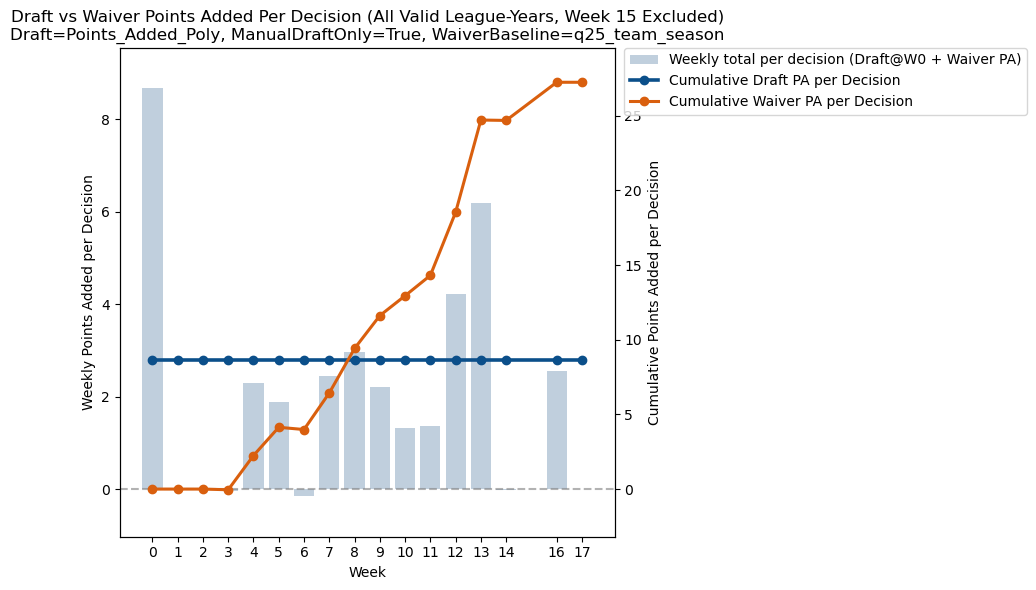

Draft decisions (picks): 44,411
Draft points added total: 384893.93
Draft points added per decision: 8.6666
Total waiver decisions (adds, week15 excluded): 38,208


In [520]:
# ============================================================
# BLOCK WW8B - Draft vs Waiver points added PER DECISION
#   - Same structure as WW8, but normalized by decision counts
#   - Week 15 excluded
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DRAFT_POINTS_COL = "Points_Added_Poly"
MANUAL_DRAFT_ONLY = True
SEASON_END_WEEK = 17
IGNORE_WEEKS = {15}

required_objs = ["draft_scored", "waiver_stints", "optimal_selected", "WAIVER_BASELINE_VALUE", "WAIVER_BASELINE_NAME"]
missing_objs = [x for x in required_objs if x not in globals()]
if missing_objs:
    raise ValueError(f"Missing required objects: {missing_objs}. Run WW6 + WW8 prerequisites first.")

d = draft_scored.copy()
if DRAFT_POINTS_COL not in d.columns:
    raise ValueError(f"draft_scored missing {DRAFT_POINTS_COL}")
if MANUAL_DRAFT_ONLY:
    d = d[d["Is_Autodrafted"] == 0].copy()

d[DRAFT_POINTS_COL] = pd.to_numeric(d[DRAFT_POINTS_COL], errors="coerce").fillna(0.0)
draft_points_total = float(d[DRAFT_POINTS_COL].sum())
draft_decisions = int(len(d))
if draft_decisions <= 0:
    raise ValueError("No draft decisions after filtering.")
draft_points_per_decision = draft_points_total / draft_decisions

osel = optimal_selected.copy()
osel["Week"] = pd.to_numeric(osel["Week"], errors="coerce")
osel["WeekPoints"] = pd.to_numeric(osel["WeekPoints"], errors="coerce").fillna(0.0)
osel["SelectedOptimal"] = osel["SelectedOptimal"].fillna(False).astype(bool)
osel["ValidWeekPoints"] = np.where(osel["SelectedOptimal"], osel["WeekPoints"], 0.0)

joined = waiver_stints.merge(
    osel[["League_ID", "Year", "Team", "Week", "Player_norm", "ValidWeekPoints"]],
    on=["League_ID", "Year", "Team", "Player_norm"],
    how="left"
)
joined = joined[
    joined["Week"].notna() &
    (joined["Week"].astype(int) >= joined["Start_Week_For_Credit"].astype(int)) &
    (joined["Week"].astype(int) <= joined["End_Week"].astype(int))
].copy()
joined["Week"] = pd.to_numeric(joined["Week"], errors="coerce").astype(int)
joined = joined[(joined["Week"] >= 1) & (joined["Week"] <= SEASON_END_WEEK)].copy()
joined = joined[~joined["Week"].isin(IGNORE_WEEKS)].copy()

waiver_valid_week = joined.groupby("Week", dropna=False)["ValidWeekPoints"].sum().reset_index(name="Waiver_ValidSum")

exp_rows = []
for _, r in waiver_stints.iterrows():
    s = int(r["Start_Week_For_Credit"])
    e = int(r["End_Week"])
    if e < s: continue
    s = max(1, s); e = min(SEASON_END_WEEK, e)
    if e < s: continue
    exp_rows.extend([wk for wk in range(s, e + 1) if wk not in IGNORE_WEEKS])
if len(exp_rows) == 0:
    raise ValueError("No active waiver stint-weeks found.")

active_stints_week = pd.Series(exp_rows, name="Week").value_counts().rename_axis("Week").reset_index(name="Active_StintWeeks")
waiver_week = active_stints_week.merge(waiver_valid_week, on="Week", how="left")
waiver_week["Waiver_ValidSum"] = waiver_week["Waiver_ValidSum"].fillna(0.0)
waiver_week["Waiver_PointsAdded"] = waiver_week["Waiver_ValidSum"] - WAIVER_BASELINE_VALUE * waiver_week["Active_StintWeeks"]

waiver_decisions_week = (
    waiver_stints.groupby("Add_Week", dropna=False).size().reset_index(name="Waiver_Decisions")
    .rename(columns={"Add_Week": "Week"})
)
waiver_decisions_week["Week"] = pd.to_numeric(waiver_decisions_week["Week"], errors="coerce").astype(int)
waiver_decisions_week = waiver_decisions_week[(waiver_decisions_week["Week"] >= 1) & (waiver_decisions_week["Week"] <= SEASON_END_WEEK)]
waiver_decisions_week = waiver_decisions_week[~waiver_decisions_week["Week"].isin(IGNORE_WEEKS)].copy()

waiver_week = waiver_week.merge(waiver_decisions_week, on="Week", how="left")
waiver_week["Waiver_Decisions"] = waiver_week["Waiver_Decisions"].fillna(0).astype(int)
waiver_week["Waiver_PA_per_Decision"] = np.where(
    waiver_week["Waiver_Decisions"] > 0,
    waiver_week["Waiver_PointsAdded"] / waiver_week["Waiver_Decisions"],
    0.0
)

weeks = [0] + [wk for wk in range(1, SEASON_END_WEEK + 1) if wk not in IGNORE_WEEKS]
draft_weekly_pd = pd.Series(0.0, index=weeks)
waiver_weekly_pd = pd.Series(0.0, index=weeks)

draft_weekly_pd.loc[0] = draft_points_per_decision
for _, r in waiver_week.iterrows():
    wk = int(r["Week"])
    if wk in waiver_weekly_pd.index:
        waiver_weekly_pd.loc[wk] = float(r["Waiver_PA_per_Decision"])

bars_pd = draft_weekly_pd + waiver_weekly_pd
cum_draft_pd = draft_weekly_pd.cumsum()
cum_waiver_pd = waiver_weekly_pd.cumsum()

bar_vals = bars_pd.to_numpy(dtype=float)
line_vals = np.concatenate([cum_draft_pd.to_numpy(dtype=float), cum_waiver_pd.to_numpy(dtype=float)])
bar_ymin = float(np.min(bar_vals)); bar_ymax = float(np.max(bar_vals))
if bar_ymax <= bar_ymin: bar_ymax = bar_ymin + 1.0
bar_pad = max(0.5, 0.10 * (bar_ymax - bar_ymin)); bar_ymin -= bar_pad; bar_ymax += bar_pad

line_ymin_raw = float(np.min(line_vals)); line_ymax_raw = float(np.max(line_vals))
if line_ymax_raw <= line_ymin_raw: line_ymax_raw = line_ymin_raw + 1.0
line_pad = max(0.5, 0.10 * (line_ymax_raw - line_ymin_raw)); line_ymin_raw -= line_pad; line_ymax_raw += line_pad

bar_range = max(bar_ymax - bar_ymin, 1.0)
zero_frac = (0.0 - bar_ymin) / bar_range
line_range = max(line_ymax_raw - line_ymin_raw, 1.0)
line_ymin = -zero_frac * line_range
line_ymax = line_ymin + line_range

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.set_zorder(1); ax2.set_zorder(2); ax1.patch.set_visible(False)

ax1.bar(weeks, bars_pd.values, color="#B5C7D8", alpha=0.85, label="Weekly total per decision (Draft@W0 + Waiver PA)")
ax1.axhline(0, linestyle="--", color="gray", alpha=0.6)
ax1.set_xlabel("Week")
ax1.set_xticks(weeks)
ax1.set_ylabel("Weekly Points Added per Decision")
ax1.set_ylim(bar_ymin, bar_ymax)

ax2.plot(weeks, cum_draft_pd.values, marker="o", linewidth=2.6, color="#0B4F8A", label="Cumulative Draft PA per Decision")
ax2.plot(weeks, cum_waiver_pd.values, marker="o", linewidth=2.2, color="#D95F0E", label="Cumulative Waiver PA per Decision")
ax2.set_ylabel("Cumulative Points Added per Decision")
ax2.set_ylim(line_ymin, line_ymax)

h1, l1 = ax1.get_legend_handles_labels(); h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1 + h2, l1 + l2, loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

plt.title(
    "Draft vs Waiver Points Added Per Decision (All Valid League-Years, Week 15 Excluded)\n"
    f"Draft={DRAFT_POINTS_COL}, ManualDraftOnly={MANUAL_DRAFT_ONLY}, WaiverBaseline={WAIVER_BASELINE_NAME}"
)
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

print(f"Draft decisions (picks): {draft_decisions:,}")
print(f"Draft points added total: {draft_points_total:.2f}")
print(f"Draft points added per decision: {draft_points_per_decision:.4f}")
print(f"Total waiver decisions (adds, week15 excluded): {int(waiver_week['Waiver_Decisions'].sum()):,}")


Top player mapping per team (for bar colors Top1..TopK):
Rank              Top1.0                 Top2.0             Top3.0           Top4.0             Top5.0
Team                                                                                                  
1     Kenneth Walker III         Dalton Schultz      Patriots D/ST    Curtis Samuel      Justin Fields
3           Daniel Jones         Tyler Allgeier      Robert Tonyan      Jason Myers        Taysom Hill
5           Mason Crosby           Packers D/ST       Kenyan Drake                -                  -
8          Isiah Pacheco          Rachaad White  Melvin Gordon III      Graham Gano  Allen Robinson II
9            Ryan Succop  Donovan Peoples-Jones        David Njoku       Geno Smith       Greg Dulcich
10            Jared Goff        Trevor Lawrence        Brett Maher        Zay Jones      Rondale Moore
12            Tyler Bass              Tom Brady        Chiefs D/ST      Saints D/ST        Titans D/ST
13        Tua Ta

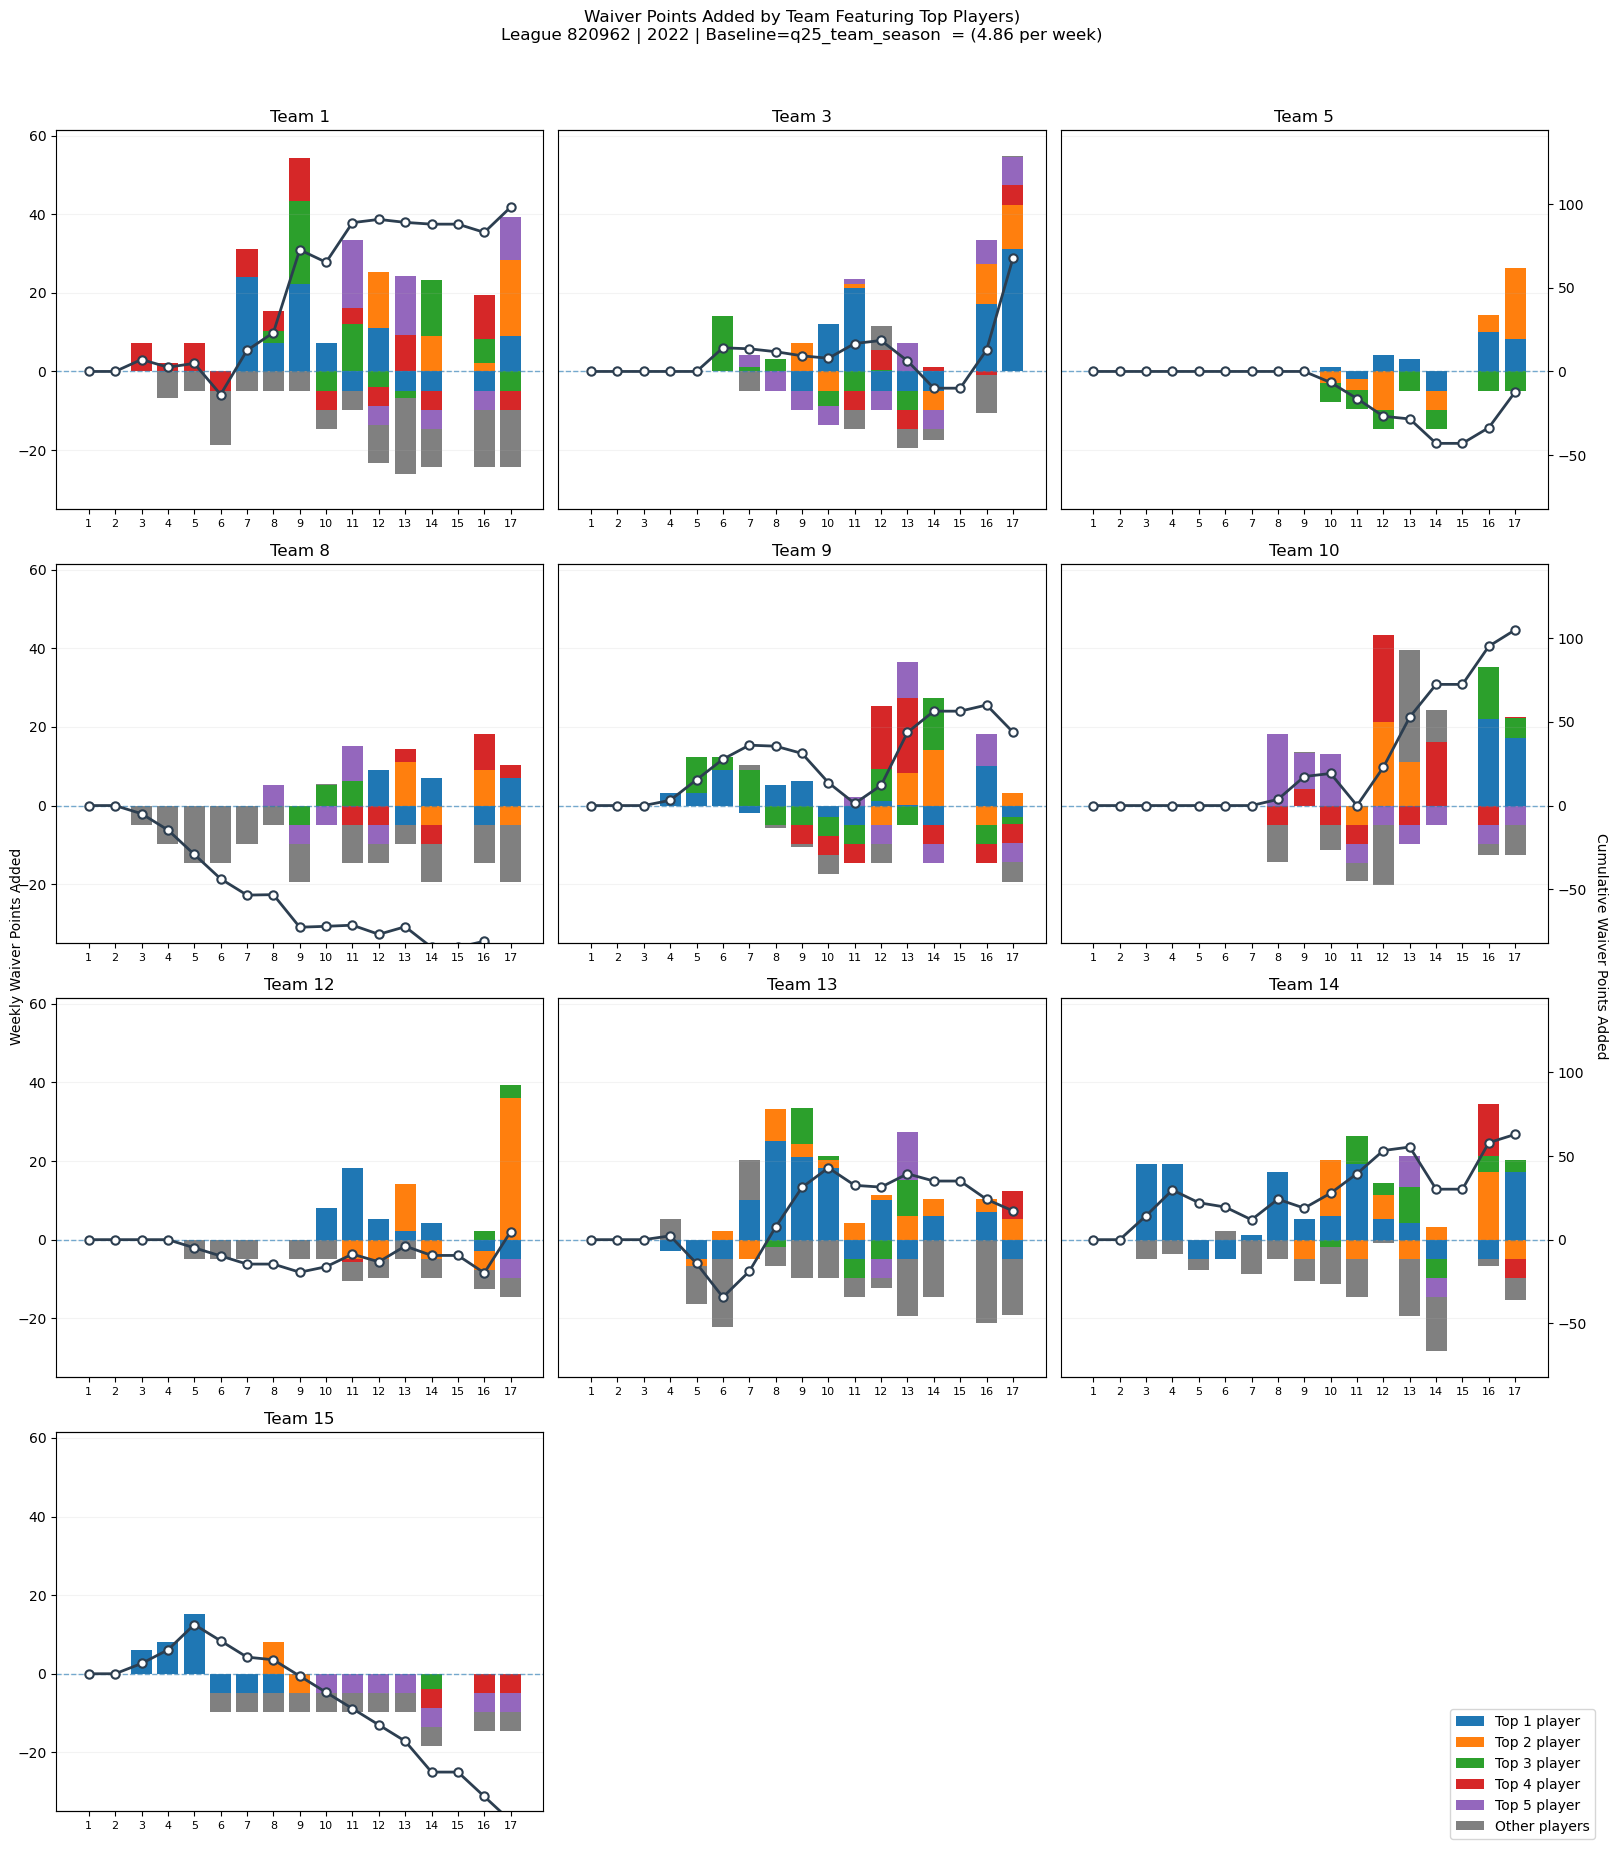

In [521]:
# ============================================================
# BLOCK WW9 - League matrix: Waiver points added by top players (NEW baseline)
#   - One league + one year
#   - All teams shown in matrix
#   - Stacked bars color-coded by Top1..TopK players (per team)
#   - Secondary axis line = cumulative waiver points added
#   - Zero aligned across primary/secondary y-axes
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# ----------------------------
# CONFIG
# ----------------------------
LEAGUE_ID = 820962
YEAR = 2022
SEASON_END_WEEK = 17
TOP_K = 5
N_COLS = 3
FIG_W = 16
FIG_H_PER_ROW = 4.5
SHOW_OTHER = True

required = ["waiver_stints", "optimal_selected", "WAIVER_BASELINE_VALUE", "WAIVER_BASELINE_NAME"]
missing = [x for x in required if x not in globals()]
if missing:
    raise ValueError(f"Run WW6 and WW3-WW4 first. Missing: {missing}")

osel = optimal_selected.copy()
osel["Week"] = pd.to_numeric(osel["Week"], errors="coerce")
osel["WeekPoints"] = pd.to_numeric(osel["WeekPoints"], errors="coerce").fillna(0.0)
osel["SelectedOptimal"] = osel["SelectedOptimal"].fillna(False).astype(bool)
osel["ValidWeekPoints"] = np.where(osel["SelectedOptimal"], osel["WeekPoints"], 0.0)

weekly = waiver_stints.merge(
    osel[["League_ID", "Year", "Team", "Week", "Player_norm", "ValidWeekPoints"]],
    on=["League_ID", "Year", "Team", "Player_norm"],
    how="left"
).copy()

weekly = weekly[
    weekly["Week"].notna() &
    (weekly["Week"].astype(int) >= weekly["Start_Week_For_Credit"].astype(int)) &
    (weekly["Week"].astype(int) <= weekly["End_Week"].astype(int))
].copy()
weekly["Week"] = pd.to_numeric(weekly["Week"], errors="coerce").astype(int)
weekly = weekly[(weekly["Week"] >= 1) & (weekly["Week"] <= SEASON_END_WEEK)].copy()
weekly = weekly[(weekly["League_ID"] == LEAGUE_ID) & (weekly["Year"] == YEAR)].copy()

if weekly.empty:
    raise ValueError("No waiver rows found for selected LEAGUE_ID/YEAR.")

weekly["WAIVER_PA"] = weekly["ValidWeekPoints"] - WAIVER_BASELINE_VALUE

player_totals = (
    weekly.groupby(["Team", "Player_norm"], dropna=False)["WAIVER_PA"]
          .sum()
          .reset_index()
)
player_totals["Rank"] = player_totals.groupby("Team")["WAIVER_PA"].rank(method="first", ascending=False)
player_totals["Bucket"] = np.where(player_totals["Rank"] <= TOP_K,
                                  "Top" + player_totals["Rank"].astype(int).astype(str),
                                  "OTHER")

weekly = weekly.merge(player_totals[["Team", "Player_norm", "Bucket", "Rank"]], on=["Team", "Player_norm"], how="left")
weekly["Bucket"] = weekly["Bucket"].fillna("OTHER")

top_map = (player_totals[player_totals["Rank"] <= TOP_K]
           .sort_values(["Team", "Rank"])
           .pivot_table(index="Team", columns="Rank", values="Player_norm", aggfunc="first"))
top_map = top_map.rename(columns={i: f"Top{i}" for i in top_map.columns})
print("Top player mapping per team (for bar colors Top1..TopK):")
print(top_map.fillna("-").to_string())

teams = sorted(weekly["Team"].dropna().unique().tolist())
if not teams:
    raise ValueError("No teams available after filtering.")
WEEKS = list(range(1, SEASON_END_WEEK + 1))
bucket_order = [f"Top{i}" for i in range(1, TOP_K + 1)] + (["OTHER"] if SHOW_OTHER else [])

cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
bucket_colors = {b: cycle[i % len(cycle)] for i, b in enumerate(bucket_order)}
if "OTHER" in bucket_colors:
    bucket_colors["OTHER"] = "gray"

per_team_pivots = {}
per_team_cum = {}
weekly_global_min = 0.0
weekly_global_max = 0.0
cum_global_min = 0.0
cum_global_max = 0.0

for t in teams:
    g = weekly[weekly["Team"] == t].copy()
    twb = (g.groupby(["Week", "Bucket"], dropna=False)["WAIVER_PA"].sum().reset_index())
    piv = (twb.pivot_table(index="Week", columns="Bucket", values="WAIVER_PA", aggfunc="sum", fill_value=0.0)
             .reindex(WEEKS, fill_value=0.0))
    for b in bucket_order:
        if b not in piv.columns:
            piv[b] = 0.0
    piv = piv[bucket_order]

    weekly_total = piv.sum(axis=1).to_numpy(dtype=float)
    cum = np.cumsum(weekly_total)

    arr = piv.to_numpy(dtype=float)
    pos_stack = np.sum(np.where(arr > 0, arr, 0.0), axis=1)
    neg_stack = np.sum(np.where(arr < 0, arr, 0.0), axis=1)

    weekly_global_max = max(weekly_global_max, float(np.max(pos_stack)))
    weekly_global_min = min(weekly_global_min, float(np.min(neg_stack)))
    cum_global_max = max(cum_global_max, float(np.max(cum)))
    cum_global_min = min(cum_global_min, float(np.min(cum)))

    per_team_pivots[t] = piv
    per_team_cum[t] = cum

bar_ymin, bar_ymax = weekly_global_min, weekly_global_max
if bar_ymax <= bar_ymin:
    bar_ymax = bar_ymin + 1.0
bar_pad = max(5.0, 0.08 * (bar_ymax - bar_ymin))
bar_ymin -= bar_pad
bar_ymax += bar_pad

line_ymin_raw, line_ymax_raw = cum_global_min, cum_global_max
if line_ymax_raw <= line_ymin_raw:
    line_ymax_raw = line_ymin_raw + 1.0
line_pad = max(5.0, 0.08 * (line_ymax_raw - line_ymin_raw))
line_ymin_raw -= line_pad
line_ymax_raw += line_pad

bar_range = bar_ymax - bar_ymin
if bar_range <= 0:
    bar_range = 1.0
zero_frac = (0.0 - bar_ymin) / bar_range

line_range = line_ymax_raw - line_ymin_raw
if line_range <= 0:
    line_range = 1.0
line_ymin = -zero_frac * line_range
line_ymax = line_ymin + line_range

n = len(teams)
ncols = min(N_COLS, n)
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(FIG_W, FIG_H_PER_ROW * nrows), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)

legend_labels = [f"Top {i} player" for i in range(1, TOP_K + 1)] + (["Other players"] if SHOW_OTHER else [])

for i, t in enumerate(teams):
    ax = axes[i]
    ax2 = ax.twinx()

    piv = per_team_pivots[t]
    cum = per_team_cum[t]

    pos_bottom = np.zeros(len(WEEKS), dtype=float)
    neg_bottom = np.zeros(len(WEEKS), dtype=float)

    for bi, b in enumerate(bucket_order):
        vals = piv[b].to_numpy(dtype=float)
        pos = np.where(vals > 0, vals, 0.0)
        neg = np.where(vals < 0, vals, 0.0)

        ax.bar(WEEKS, pos, bottom=pos_bottom, color=bucket_colors[b], label=legend_labels[bi] if i == 0 else None)
        ax.bar(WEEKS, neg, bottom=neg_bottom, color=bucket_colors[b])

        pos_bottom += pos
        neg_bottom += neg

    ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)
    ax.set_title(f"Team {int(t)}")
    ax.set_xticks(WEEKS)
    ax.set_xticklabels(WEEKS)
    ax.tick_params(axis="x", labelbottom=True, labelsize=8)
    ax.grid(axis="y", alpha=0.15)
    ax.set_ylim(bar_ymin, bar_ymax)

    ax2.plot(WEEKS, cum, marker="o", linewidth=2.0, color="#2C3E50", markerfacecolor="white", markeredgewidth=1.5)
    ax2.set_ylim(line_ymin, line_ymax)

    if (i % ncols) != 0:
        ax.tick_params(axis="y", left=False, labelleft=False)
    if (i % ncols) != (ncols - 1):
        ax2.tick_params(axis="y", right=False, labelright=False)

    ax.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)

for j in range(len(teams), len(axes)):
    axes[j].axis("off")

# Global y-axis labels for both sides
fig.text(0.005, 0.5, "Weekly Waiver Points Added", va="center", rotation="vertical")
fig.text(0.995, 0.5, "Cumulative Waiver Points Added", va="center", rotation=270)

fig.suptitle(
    "Waiver Points Added by Team Featuring Top Players)\n"
    f"League {LEAGUE_ID} | {YEAR} | Baseline={WAIVER_BASELINE_NAME}  = ({WAIVER_BASELINE_VALUE:.2f} per week)",
    y=1.02
)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles[:len(bucket_order)], labels[:len(bucket_order)], loc="lower right", bbox_to_anchor=(1.0, 0.0), ncol=1, frameon=True)

plt.tight_layout()
plt.show()


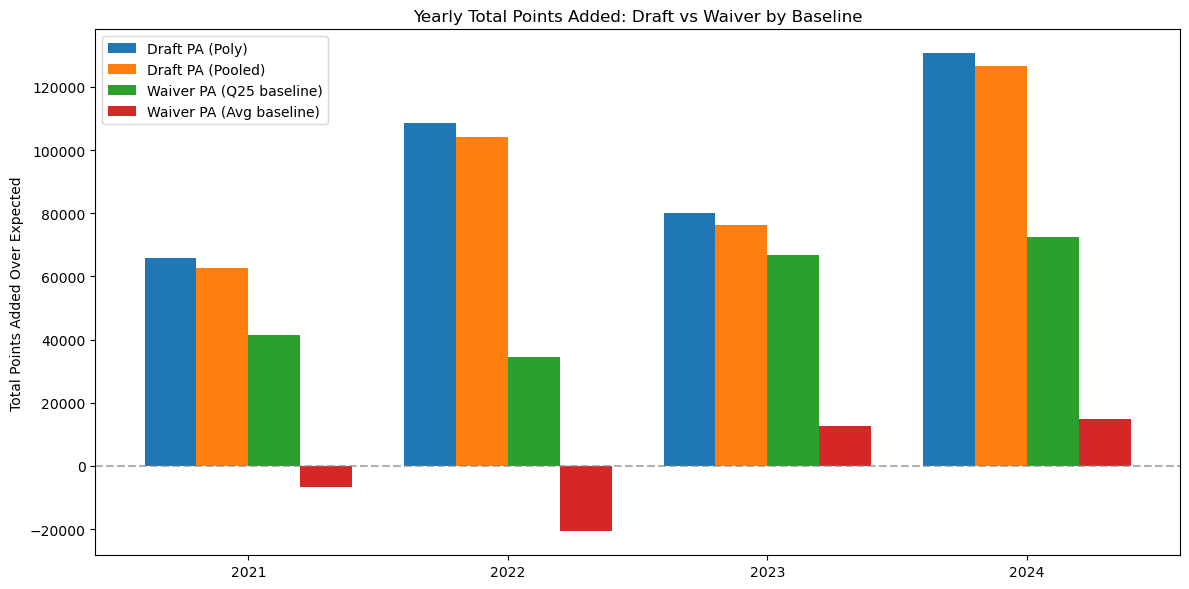

,Year,Draft_PA_Poly,Draft_PA_Pooled,Waiver_PA_Avg,Waiver_PA_Q25
0,2021,65701.577044,62768.565467,-6769.135312,41440.703009
1,2022,108487.276522,104251.775013,-20724.673018,34519.565802
2,2023,80027.366858,76262.819592,12524.572105,66644.880110
3,2024,130677.713752,126585.136884,14969.236225,72373.138499


In [522]:
# ============================================================
# BLOCK WW10 - Yearly total points added over expected (Draft + Waiver)
#   Draft baselines shown: Poly, Pooled
#   Waiver baselines shown: Q25, Average
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

required = ["draft_scored", "waiver_with_valid", "BASELINE_CANDIDATES"]
missing = [x for x in required if x not in globals()]
if missing:
    raise ValueError(f"Run draft scoring + WW6 first. Missing: {missing}")

MANUAL_DRAFT_ONLY = True

# Draft yearly totals
if not {"Year", "Is_Autodrafted", "Points_Added_Poly", "Points_Added_Pooled"}.issubset(draft_scored.columns):
    raise ValueError("draft_scored missing needed draft points-added columns.")

d = draft_scored.copy()
d["Year"] = pd.to_numeric(d["Year"], errors="coerce").astype(int)
for c in ["Points_Added_Poly", "Points_Added_Pooled"]:
    d[c] = pd.to_numeric(d[c], errors="coerce").fillna(0.0)
if MANUAL_DRAFT_ONLY:
    d = d[d["Is_Autodrafted"] == 0].copy()

d_year = (
    d.groupby("Year", dropna=False)
     .agg(
         Draft_PA_Poly=("Points_Added_Poly", "sum"),
         Draft_PA_Pooled=("Points_Added_Pooled", "sum"),
     )
     .reset_index()
)

# Waiver yearly totals in stint-week unit
if not {"Year", "Valid_Points", "Weeks_Observed"}.issubset(waiver_with_valid.columns):
    raise ValueError("waiver_with_valid missing needed waiver columns.")

w = waiver_with_valid.copy()
w["Year"] = pd.to_numeric(w["Year"], errors="coerce").astype(int)
w["Valid_Points"] = pd.to_numeric(w["Valid_Points"], errors="coerce").fillna(0.0)
w["Weeks_Observed"] = pd.to_numeric(w["Weeks_Observed"], errors="coerce").fillna(0.0)
w = w[w["Weeks_Observed"] > 0].copy()

waiver_avg = float(BASELINE_CANDIDATES["avg_stint_week"])
waiver_q25 = float(BASELINE_CANDIDATES["q25_team_season"])

w["Waiver_PA_Avg"] = w["Valid_Points"] - waiver_avg * w["Weeks_Observed"]
w["Waiver_PA_Q25"] = w["Valid_Points"] - waiver_q25 * w["Weeks_Observed"]

w_year = (
    w.groupby("Year", dropna=False)
     .agg(
         Waiver_PA_Avg=("Waiver_PA_Avg", "sum"),
         Waiver_PA_Q25=("Waiver_PA_Q25", "sum"),
     )
     .reset_index()
)

yearly_all = d_year.merge(w_year, on="Year", how="outer").fillna(0.0).sort_values("Year")

# Plot
x = np.arange(len(yearly_all))
bw = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*bw, yearly_all["Draft_PA_Poly"], width=bw, label="Draft PA (Poly)")
plt.bar(x - 0.5*bw, yearly_all["Draft_PA_Pooled"], width=bw, label="Draft PA (Pooled)")
plt.bar(x + 0.5*bw, yearly_all["Waiver_PA_Q25"], width=bw, label="Waiver PA (Q25 baseline)")
plt.bar(x + 1.5*bw, yearly_all["Waiver_PA_Avg"], width=bw, label="Waiver PA (Avg baseline)")

plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, yearly_all["Year"])
plt.ylabel("Total Points Added Over Expected")
plt.title("Yearly Total Points Added: Draft vs Waiver by Baseline")
plt.legend()
plt.tight_layout()
plt.show()

yearly_all


In [523]:
# ============================================================
# BLOCK SS1 - Start/Sit evaluation framework (setup)
#   Baseline: optimal PROJECTED lineup (not hindsight-optimal actual lineup)
#   Comparison target: actual lineup points
# ============================================================

import numpy as np
import pandas as pd

required = ["lineups_filt"]
missing = [x for x in required if x not in globals()]
if missing:
    raise ValueError(f"Run lineup pipeline first. Missing: {missing}")

if "Projected_Points" not in lineups_filt.columns:
    raise ValueError("lineups_filt missing Projected_Points. This baseline requires lineup projections.")

print("Start/Sit framework initialized with projected-lineup baseline.")
print("Next block computes weekly/team-season StartSit_PA = Actual - ProjectedOptimal.")


Start/Sit framework initialized with projected-lineup baseline.
Next block computes weekly/team-season StartSit_PA = Actual - ProjectedOptimal.


In [524]:
# ============================================================
# BLOCK SS2 - Start/Sit metrics using PROJECTED-optimal baseline
#   Direct fix: enforce complete team-weeks before scoring Start/Sit.
# ============================================================

import numpy as np
import pandas as pd

if "Projected_Points" not in lineups_filt.columns:
    raise ValueError("lineups_filt missing Projected_Points.")

slot_counts = {"QB":1, "RB":2, "WR":2, "TE":1, "FLEX":1, "K":1, "D/ST":1}
flex_eligible = {"RB","WR","TE"}
EXPECTED_STARTER_COUNT = int(EXPECTED_STARTERS.get("STARTERS", 9)) if "EXPECTED_STARTERS" in globals() else 9

starter_slots = {"QB","RB","WR","TE","FLEX","K","D/ST","DST","DEF","RB/WR/TE","OP","SUPERFLEX","QB/RB/WR/TE"}

df = lineups_filt.copy()
df["Week"] = pd.to_numeric(df["Week"], errors="coerce")
df["Points"] = pd.to_numeric(df["Points"], errors="coerce").fillna(0.0)
df["Projected_Points"] = pd.to_numeric(df["Projected_Points"], errors="coerce").fillna(0.0)
df["Slot_norm"] = df["Slot"].astype(str).str.upper().str.strip()
if "Is_Starter" in df.columns:
    df["Is_Starter"] = pd.to_numeric(df["Is_Starter"], errors="coerce").fillna(0).astype(int)
else:
    df["Is_Starter"] = 0
if "Player_norm" not in df.columns:
    df["Player_norm"] = df["Player"].astype(str).str.strip()

# Robust starter flag: ESPN starter flag OR starter-typed slot
# This is the direct fix for sparse/buggy Is_Starter weeks.
df["Is_Starter_Robust"] = (df["Is_Starter"].eq(1) | df["Slot_norm"].isin(starter_slots)).astype(int)

# Position inference
pos = infer_player_position_by_core_starts(df[["League_ID","Year","Team","Slot","Player_norm"]].copy())

# One row per player-week with actual + projected
pw = (
    df.groupby(["League_ID","Year","Team","Week","Player_norm"], dropna=False)
      .agg(
          ActualWeekPoints=("Points", "max"),
          ProjWeekPoints=("Projected_Points", "max"),
      )
      .reset_index()
)
pw = pw.merge(pos, on=["League_ID","Year","Team","Player_norm"], how="left")
pw["Position"] = pw["Position"].fillna("UNKNOWN")

# Projection-optimal lineup selection (by projected points)
selected_parts = []
for _, g in pw.groupby(["League_ID","Year","Team","Week"], sort=False):
    work = g.copy().rename(columns={"ProjWeekPoints":"WeekPoints"})
    work_sel = choose_optimal_lineup_for_group(work, slot_counts, flex_eligible)
    selected_parts.append(work_sel)

proj_selected = pd.concat(selected_parts, ignore_index=True)

proj_opt_actual = (
    proj_selected[proj_selected["SelectedOptimal"]]
      .groupby(["League_ID","Year","Team","Week"], dropna=False)["ActualWeekPoints"]
      .sum()
      .reset_index(name="ProjOptimal_ActualPoints")
)
proj_opt_proj = (
    proj_selected[proj_selected["SelectedOptimal"]]
      .groupby(["League_ID","Year","Team","Week"], dropna=False)["WeekPoints"]
      .sum()
      .reset_index(name="ProjOptimal_ProjectedPoints")
)
proj_opt_n = (
    proj_selected[proj_selected["SelectedOptimal"]]
      .groupby(["League_ID","Year","Team","Week"], dropna=False)
      .size().reset_index(name="ProjOptimal_Selected_Count")
)

# Actual starter totals using robust starter flag
actual_wk = (
    df[df["Is_Starter_Robust"] == 1]
      .groupby(["League_ID","Year","Team","Week"], dropna=False)
      .agg(
          Actual_Starter_Points=("Points", "sum"),
          Actual_Starter_ProjectedPoints=("Projected_Points", "sum"),
          Actual_Starter_Count=("Player_norm", "nunique"),
      )
      .reset_index()
)

startsit_weekly = (
    actual_wk
    .merge(proj_opt_actual, on=["League_ID","Year","Team","Week"], how="outer")
    .merge(proj_opt_proj, on=["League_ID","Year","Team","Week"], how="outer")
    .merge(proj_opt_n, on=["League_ID","Year","Team","Week"], how="outer")
    .fillna(0.0)
)
startsit_weekly["StartSit_PA"] = startsit_weekly["Actual_Starter_Points"] - startsit_weekly["ProjOptimal_ActualPoints"]
startsit_weekly["StartSit_ProjGap"] = startsit_weekly["Actual_Starter_ProjectedPoints"] - startsit_weekly["ProjOptimal_ProjectedPoints"]

# Direct fix: keep only complete team-weeks for Start/Sit scoring
startsit_weekly["Lineup_Complete"] = startsit_weekly["Actual_Starter_Count"].eq(EXPECTED_STARTER_COUNT)
startsit_weekly["Proj_Complete"] = startsit_weekly["ProjOptimal_Selected_Count"].eq(EXPECTED_STARTER_COUNT)
startsit_weekly_clean = startsit_weekly[startsit_weekly["Lineup_Complete"] & startsit_weekly["Proj_Complete"]].copy()

startsit_team_season = (
    startsit_weekly_clean.groupby(["League_ID","Year","Team"], dropna=False)
    .agg(
        Weeks=("Week", "nunique"),
        Actual_Starter_Points=("Actual_Starter_Points", "sum"),
        ProjOptimal_ActualPoints=("ProjOptimal_ActualPoints", "sum"),
        StartSit_PA=("StartSit_PA", "sum"),
        StartSit_ProjGap=("StartSit_ProjGap", "sum"),
    )
    .reset_index()
)

print("[SS2] built startsit_weekly + startsit_weekly_clean using projected-optimal baseline")
print(f"[SS2] complete team-weeks kept: {len(startsit_weekly_clean):,} / {len(startsit_weekly):,}")
print(startsit_weekly_clean[["StartSit_PA","StartSit_ProjGap"]].describe())
startsit_team_season.head()


[SS2] built startsit_weekly + startsit_weekly_clean using projected-optimal baseline
[SS2] complete team-weeks kept: 52,568 / 54,839
        StartSit_PA  StartSit_ProjGap
count  52568.000000      52568.000000
mean      -1.724111         -1.626587
std       11.026887          5.198310
min      -93.300000        -64.650000
25%       -6.000000         -1.920000
50%        0.000000         -0.070000
75%        1.200000          0.000000
max       69.000000         22.640000


,League_ID,Year,Team,Weeks,Actual_Starter_Points,ProjOptimal_ActualPoints,StartSit_PA,StartSit_ProjGap
0,760435,2022,1,16,2240.98,2238.48,2.50,-10.70
1,760435,2022,2,15,1746.66,1747.12,-0.46,-9.47
2,760435,2022,3,16,1925.26,1978.48,-53.22,-8.87
3,760435,2022,4,16,1842.60,1946.50,-103.90,-100.82
4,760435,2022,5,16,1891.04,1868.74,22.30,-33.66


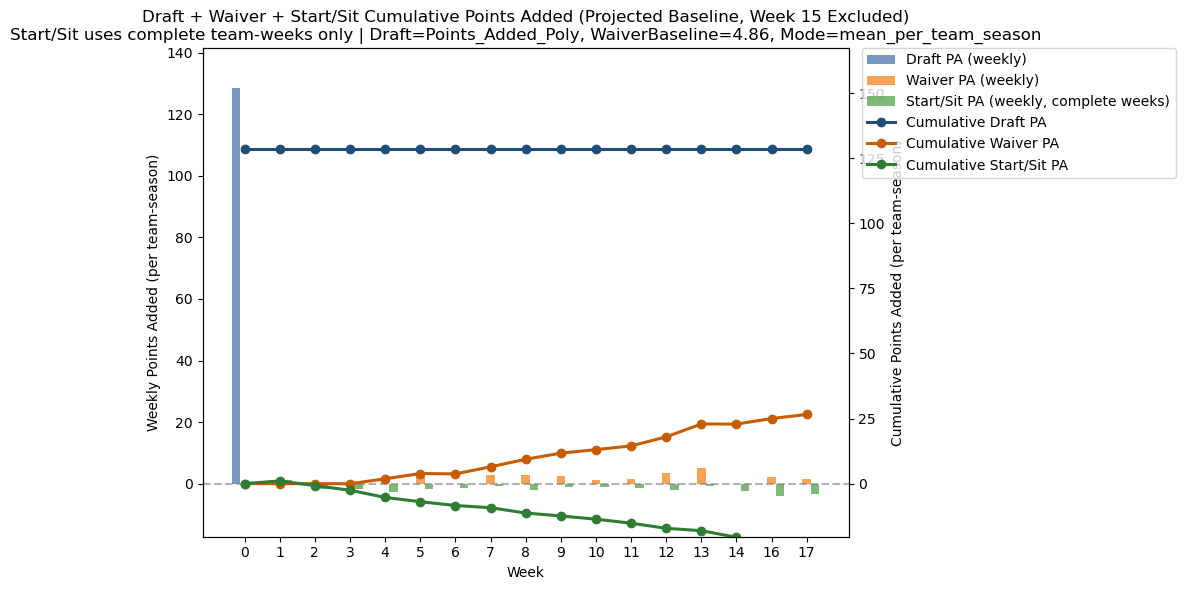

In [525]:
# ============================================================
# BLOCK SS3 - Cumulative points added: Draft + Waiver + Start/Sit
#   Uses startsit_weekly_clean (complete team-weeks only).
#   Week 15 excluded.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DRAFT_POINTS_COL = "Points_Added_Poly"
MANUAL_DRAFT_ONLY = True
SEASON_END_WEEK = 17
IGNORE_WEEKS = {15}
AGG_MODE = "mean_per_team_season"

required = ["draft_scored", "waiver_stints", "optimal_selected", "WAIVER_BASELINE_VALUE", "startsit_weekly_clean"]
missing = [x for x in required if x not in globals()]
if missing:
    raise ValueError(f"Missing required objects: {missing}. Run SS2 first.")

_d = draft_scored.copy()
if MANUAL_DRAFT_ONLY:
    _d = _d[_d["Is_Autodrafted"] == 0].copy()
_d[DRAFT_POINTS_COL] = pd.to_numeric(_d[DRAFT_POINTS_COL], errors="coerce").fillna(0.0)
draft_total = float(_d[DRAFT_POINTS_COL].sum())
team_seasons_n = _d[["League_ID", "Year", "Team"]].drop_duplicates().shape[0]
if team_seasons_n <= 0:
    raise ValueError("No team-seasons after draft filtering.")

osel = optimal_selected.copy()
osel["Week"] = pd.to_numeric(osel["Week"], errors="coerce")
osel["WeekPoints"] = pd.to_numeric(osel["WeekPoints"], errors="coerce").fillna(0.0)
osel["SelectedOptimal"] = osel["SelectedOptimal"].fillna(False).astype(bool)
osel["ValidWeekPoints"] = np.where(osel["SelectedOptimal"], osel["WeekPoints"], 0.0)

joined = waiver_stints.merge(
    osel[["League_ID", "Year", "Team", "Week", "Player_norm", "ValidWeekPoints"]],
    on=["League_ID", "Year", "Team", "Player_norm"], how="left"
)
joined = joined[
    joined["Week"].notna() &
    (joined["Week"].astype(int) >= joined["Start_Week_For_Credit"].astype(int)) &
    (joined["Week"].astype(int) <= joined["End_Week"].astype(int))
].copy()
joined["Week"] = pd.to_numeric(joined["Week"], errors="coerce").astype(int)
joined = joined[(joined["Week"] >= 1) & (joined["Week"] <= SEASON_END_WEEK)]
joined = joined[~joined["Week"].isin(IGNORE_WEEKS)].copy()

waiver_valid_week = joined.groupby("Week", dropna=False)["ValidWeekPoints"].sum().reset_index(name="Waiver_ValidSum")
exp_rows = []
for _, r in waiver_stints.iterrows():
    s = int(r["Start_Week_For_Credit"]); e = int(r["End_Week"])
    if e < s: continue
    s = max(1, s); e = min(SEASON_END_WEEK, e)
    if e < s: continue
    exp_rows.extend([wk for wk in range(s, e+1) if wk not in IGNORE_WEEKS])
active_stints_week = pd.Series(exp_rows, name="Week").value_counts().rename_axis("Week").reset_index(name="Active_StintWeeks")
waiver_week = active_stints_week.merge(waiver_valid_week, on="Week", how="left")
waiver_week["Waiver_ValidSum"] = waiver_week["Waiver_ValidSum"].fillna(0.0)
waiver_week["Waiver_PA"] = waiver_week["Waiver_ValidSum"] - WAIVER_BASELINE_VALUE * waiver_week["Active_StintWeeks"]

ss = startsit_weekly_clean.copy()
ss["Week"] = pd.to_numeric(ss["Week"], errors="coerce").astype(int)
ss = ss[(ss["Week"] >= 1) & (ss["Week"] <= SEASON_END_WEEK)]
ss = ss[~ss["Week"].isin(IGNORE_WEEKS)].copy()
startsit_week = ss.groupby("Week", dropna=False)["StartSit_PA"].sum().reset_index()

weeks = [0] + [wk for wk in range(1, SEASON_END_WEEK + 1) if wk not in IGNORE_WEEKS]
draft_weekly = pd.Series(0.0, index=weeks)
waiver_weekly = pd.Series(0.0, index=weeks)
startsit_weekly_series = pd.Series(0.0, index=weeks)

draft_weekly.loc[0] = draft_total
for _, r in waiver_week.iterrows(): waiver_weekly.loc[int(r["Week"])] = float(r["Waiver_PA"])
for _, r in startsit_week.iterrows(): startsit_weekly_series.loc[int(r["Week"])] = float(r["StartSit_PA"])

if AGG_MODE == "mean_per_team_season":
    draft_weekly /= team_seasons_n
    waiver_weekly /= team_seasons_n
    startsit_weekly_series /= team_seasons_n
elif AGG_MODE != "total":
    raise ValueError("AGG_MODE must be total or mean_per_team_season")

cum_draft = draft_weekly.cumsum(); cum_waiver = waiver_weekly.cumsum(); cum_startsit = startsit_weekly_series.cumsum()

x = np.arange(len(weeks), dtype=float); barw = 0.24
all_bar = np.concatenate([draft_weekly.to_numpy(), waiver_weekly.to_numpy(), startsit_weekly_series.to_numpy()])
all_line = np.concatenate([cum_draft.to_numpy(), cum_waiver.to_numpy(), cum_startsit.to_numpy()])

bar_ymin = float(np.min(all_bar)); bar_ymax = float(np.max(all_bar))
if bar_ymax <= bar_ymin: bar_ymax = bar_ymin + 1.0
bar_pad = max(1.0, 0.10*(bar_ymax - bar_ymin)); bar_ymin -= bar_pad; bar_ymax += bar_pad

line_ymin_raw = float(np.min(all_line)); line_ymax_raw = float(np.max(all_line))
if line_ymax_raw <= line_ymin_raw: line_ymax_raw = line_ymin_raw + 1.0
line_pad = max(1.0, 0.10*(line_ymax_raw - line_ymin_raw)); line_ymin_raw -= line_pad; line_ymax_raw += line_pad

bar_range = max(bar_ymax - bar_ymin, 1.0)
zero_frac = (0 - bar_ymin) / bar_range
line_range = max(line_ymax_raw - line_ymin_raw, 1.0)
line_ymin = -zero_frac * line_range
line_ymax = line_ymin + line_range

fig, ax1 = plt.subplots(figsize=(13, 6)); ax2 = ax1.twinx()
ax1.set_zorder(1); ax2.set_zorder(2); ax1.patch.set_visible(False)

ax1.bar(x - barw, draft_weekly.values, width=barw, color="#4C78A8", alpha=0.75, label="Draft PA (weekly)")
ax1.bar(x, waiver_weekly.values, width=barw, color="#F58518", alpha=0.75, label="Waiver PA (weekly)")
ax1.bar(x + barw, startsit_weekly_series.values, width=barw, color="#54A24B", alpha=0.75, label="Start/Sit PA (weekly, complete weeks)")
ax1.axhline(0, linestyle="--", color="gray", alpha=0.6)
ax1.set_xticks(x); ax1.set_xticklabels(weeks); ax1.set_xlabel("Week")
ax1.set_ylabel("Weekly Points Added" + (" (per team-season)" if AGG_MODE=="mean_per_team_season" else ""))
ax1.set_ylim(bar_ymin, bar_ymax)

ax2.plot(x, cum_draft.values, marker="o", linewidth=2.2, color="#1f4e79", label="Cumulative Draft PA")
ax2.plot(x, cum_waiver.values, marker="o", linewidth=2.2, color="#C65D00", label="Cumulative Waiver PA")
ax2.plot(x, cum_startsit.values, marker="o", linewidth=2.2, color="#2E7D32", label="Cumulative Start/Sit PA")
ax2.set_ylabel("Cumulative Points Added" + (" (per team-season)" if AGG_MODE=="mean_per_team_season" else ""))
ax2.set_ylim(line_ymin, line_ymax)

h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc="upper left", bbox_to_anchor=(1.02,1.0), borderaxespad=0)

plt.title(
    "Draft + Waiver + Start/Sit Cumulative Points Added (Projected Baseline, Week 15 Excluded)\n"
    f"Start/Sit uses complete team-weeks only | Draft={DRAFT_POINTS_COL}, WaiverBaseline={WAIVER_BASELINE_VALUE:.2f}, Mode={AGG_MODE}"
)
plt.tight_layout(rect=[0,0,0.82,1])
plt.show()


C:\Users\dbbra\AppData\Local\Temp\ipykernel_24396\256849874.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ss_filt = ss[~ss["Drop_DNP"].fillna(False)].copy()


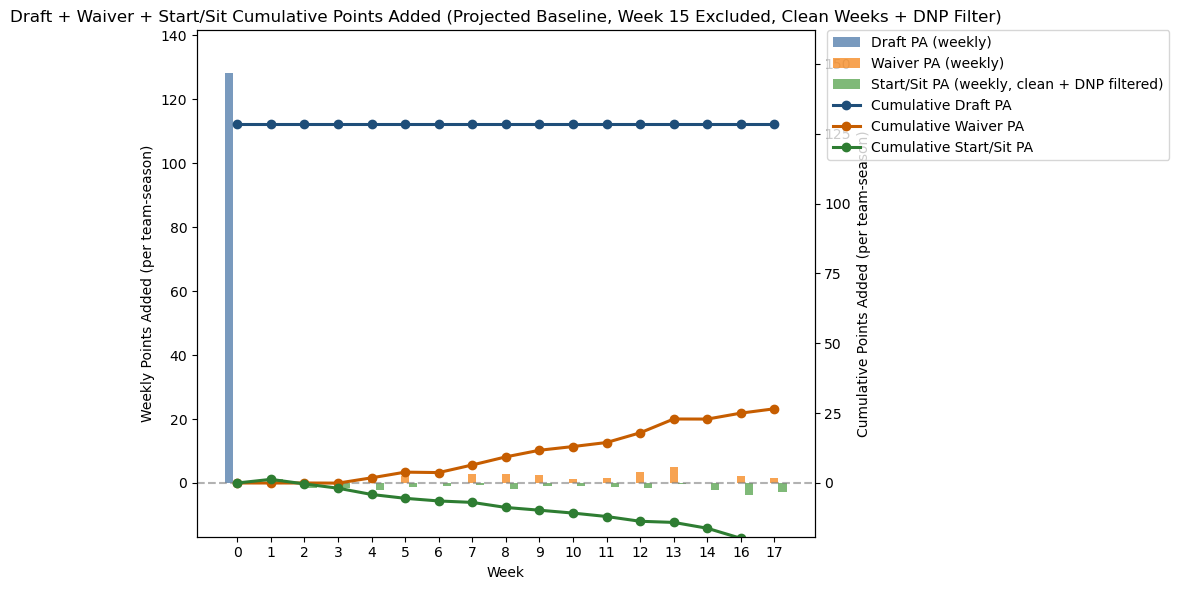

DNP-proxy starter rows flagged: 4,996
DNP-proxy team-weeks removed from clean Start/Sit: 4,680
Clean Start/Sit rows kept after DNP filter: 46,378 / 50,707


In [526]:
# ============================================================
# BLOCK SS3B - Cumulative Draft+Waiver+Start/Sit with DNP proxy filtered out
#   Applies DNP proxy on top of startsit_weekly_clean.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DRAFT_POINTS_COL = "Points_Added_Poly"
MANUAL_DRAFT_ONLY = True
SEASON_END_WEEK = 17
IGNORE_WEEKS = {15}
AGG_MODE = "mean_per_team_season"

DNP_ACTUAL_MAX = 0.0
DNP_PROJ_MIN = 5.0
EXCLUDE_SLOTS_FOR_DNP = {"K", "D/ST", "DST", "DEF"}

required = ["draft_scored", "waiver_stints", "optimal_selected", "WAIVER_BASELINE_VALUE", "startsit_weekly_clean", "lineups_filt"]
missing = [x for x in required if x not in globals()]
if missing:
    raise ValueError(f"Missing required objects: {missing}. Run SS2 first.")

d = draft_scored.copy()
if MANUAL_DRAFT_ONLY:
    d = d[d["Is_Autodrafted"] == 0].copy()
d[DRAFT_POINTS_COL] = pd.to_numeric(d[DRAFT_POINTS_COL], errors="coerce").fillna(0.0)
draft_total = float(d[DRAFT_POINTS_COL].sum())
team_seasons_n = d[["League_ID", "Year", "Team"]].drop_duplicates().shape[0]
if team_seasons_n <= 0:
    raise ValueError("No team-seasons after draft filtering.")

osel = optimal_selected.copy()
osel["Week"] = pd.to_numeric(osel["Week"], errors="coerce")
osel["WeekPoints"] = pd.to_numeric(osel["WeekPoints"], errors="coerce").fillna(0.0)
osel["SelectedOptimal"] = osel["SelectedOptimal"].fillna(False).astype(bool)
osel["ValidWeekPoints"] = np.where(osel["SelectedOptimal"], osel["WeekPoints"], 0.0)

joined = waiver_stints.merge(
    osel[["League_ID", "Year", "Team", "Week", "Player_norm", "ValidWeekPoints"]],
    on=["League_ID", "Year", "Team", "Player_norm"], how="left"
)
joined = joined[
    joined["Week"].notna() &
    (joined["Week"].astype(int) >= joined["Start_Week_For_Credit"].astype(int)) &
    (joined["Week"].astype(int) <= joined["End_Week"].astype(int))
].copy()
joined["Week"] = pd.to_numeric(joined["Week"], errors="coerce").astype(int)
joined = joined[(joined["Week"] >= 1) & (joined["Week"] <= SEASON_END_WEEK)]
joined = joined[~joined["Week"].isin(IGNORE_WEEKS)].copy()

waiver_valid_week = joined.groupby("Week", dropna=False)["ValidWeekPoints"].sum().reset_index(name="Waiver_ValidSum")
exp_rows = []
for _, r in waiver_stints.iterrows():
    s = int(r["Start_Week_For_Credit"]); e = int(r["End_Week"])
    if e < s: continue
    s = max(1, s); e = min(SEASON_END_WEEK, e)
    if e < s: continue
    exp_rows.extend([wk for wk in range(s, e + 1) if wk not in IGNORE_WEEKS])
active_stints_week = pd.Series(exp_rows, name="Week").value_counts().rename_axis("Week").reset_index(name="Active_StintWeeks")
waiver_week = active_stints_week.merge(waiver_valid_week, on="Week", how="left")
waiver_week["Waiver_ValidSum"] = waiver_week["Waiver_ValidSum"].fillna(0.0)
waiver_week["Waiver_PA"] = waiver_week["Waiver_ValidSum"] - WAIVER_BASELINE_VALUE * waiver_week["Active_StintWeeks"]

lf = lineups_filt.copy()
lf["Week"] = pd.to_numeric(lf["Week"], errors="coerce")
lf["Points"] = pd.to_numeric(lf["Points"], errors="coerce").fillna(0.0)
lf["Projected_Points"] = pd.to_numeric(lf["Projected_Points"], errors="coerce").fillna(0.0)
lf["Is_Starter"] = pd.to_numeric(lf["Is_Starter"], errors="coerce").fillna(0).astype(int)
lf["Slot_norm_dnp"] = lf["Slot"].astype(str).str.upper().str.strip()

dnp_rows = lf[
    (lf["Is_Starter"] == 1) &
    (lf["Points"] <= DNP_ACTUAL_MAX) &
    (lf["Projected_Points"] >= DNP_PROJ_MIN) &
    (~lf["Slot_norm_dnp"].isin(EXCLUDE_SLOTS_FOR_DNP))
].copy()
dnp_teamweeks = dnp_rows[["League_ID", "Year", "Team", "Week"]].drop_duplicates()

ss = startsit_weekly_clean.copy()
ss["Week"] = pd.to_numeric(ss["Week"], errors="coerce").astype(int)
ss = ss[(ss["Week"] >= 1) & (ss["Week"] <= SEASON_END_WEEK)]
ss = ss[~ss["Week"].isin(IGNORE_WEEKS)].copy()
ss = ss.merge(dnp_teamweeks.assign(Drop_DNP=True), on=["League_ID", "Year", "Team", "Week"], how="left")
ss_filt = ss[~ss["Drop_DNP"].fillna(False)].copy()
startsit_week = ss_filt.groupby("Week", dropna=False)["StartSit_PA"].sum().reset_index()

weeks = [0] + [wk for wk in range(1, SEASON_END_WEEK + 1) if wk not in IGNORE_WEEKS]
draft_weekly = pd.Series(0.0, index=weeks)
waiver_weekly = pd.Series(0.0, index=weeks)
startsit_weekly_series = pd.Series(0.0, index=weeks)

draft_weekly.loc[0] = draft_total
for _, r in waiver_week.iterrows():
    wk = int(r["Week"])
    if wk in waiver_weekly.index: waiver_weekly.loc[wk] = float(r["Waiver_PA"])
for _, r in startsit_week.iterrows():
    wk = int(r["Week"])
    if wk in startsit_weekly_series.index: startsit_weekly_series.loc[wk] = float(r["StartSit_PA"])

if AGG_MODE == "mean_per_team_season":
    draft_weekly /= team_seasons_n
    waiver_weekly /= team_seasons_n
    startsit_weekly_series /= team_seasons_n
elif AGG_MODE != "total":
    raise ValueError("AGG_MODE must be total or mean_per_team_season")

cum_draft = draft_weekly.cumsum(); cum_waiver = waiver_weekly.cumsum(); cum_startsit = startsit_weekly_series.cumsum()

x = np.arange(len(weeks), dtype=float); barw = 0.24
all_bar = np.concatenate([draft_weekly.to_numpy(), waiver_weekly.to_numpy(), startsit_weekly_series.to_numpy()])
all_line = np.concatenate([cum_draft.to_numpy(), cum_waiver.to_numpy(), cum_startsit.to_numpy()])

bar_ymin = float(np.min(all_bar)); bar_ymax = float(np.max(all_bar))
if bar_ymax <= bar_ymin: bar_ymax = bar_ymin + 1.0
bar_pad = max(1.0, 0.10 * (bar_ymax - bar_ymin)); bar_ymin -= bar_pad; bar_ymax += bar_pad

line_ymin_raw = float(np.min(all_line)); line_ymax_raw = float(np.max(all_line))
if line_ymax_raw <= line_ymin_raw: line_ymax_raw = line_ymin_raw + 1.0
line_pad = max(1.0, 0.10 * (line_ymax_raw - line_ymin_raw)); line_ymin_raw -= line_pad; line_ymax_raw += line_pad

bar_range = max(bar_ymax - bar_ymin, 1.0)
zero_frac = (0.0 - bar_ymin) / bar_range
line_range = max(line_ymax_raw - line_ymin_raw, 1.0)
line_ymin = -zero_frac * line_range
line_ymax = line_ymin + line_range

fig, ax1 = plt.subplots(figsize=(13, 6)); ax2 = ax1.twinx()
ax1.set_zorder(1); ax2.set_zorder(2); ax1.patch.set_visible(False)

ax1.bar(x - barw, draft_weekly.values, width=barw, color="#4C78A8", alpha=0.75, label="Draft PA (weekly)")
ax1.bar(x, waiver_weekly.values, width=barw, color="#F58518", alpha=0.75, label="Waiver PA (weekly)")
ax1.bar(x + barw, startsit_weekly_series.values, width=barw, color="#54A24B", alpha=0.75, label="Start/Sit PA (weekly, clean + DNP filtered)")
ax1.axhline(0, linestyle="--", color="gray", alpha=0.6)
ax1.set_xticks(x); ax1.set_xticklabels(weeks)
ax1.set_xlabel("Week")
ax1.set_ylabel("Weekly Points Added" + (" (per team-season)" if AGG_MODE=="mean_per_team_season" else ""))
ax1.set_ylim(bar_ymin, bar_ymax)

ax2.plot(x, cum_draft.values, marker="o", linewidth=2.2, color="#1f4e79", label="Cumulative Draft PA")
ax2.plot(x, cum_waiver.values, marker="o", linewidth=2.2, color="#C65D00", label="Cumulative Waiver PA")
ax2.plot(x, cum_startsit.values, marker="o", linewidth=2.2, color="#2E7D32", label="Cumulative Start/Sit PA")
ax2.set_ylabel("Cumulative Points Added" + (" (per team-season)" if AGG_MODE=="mean_per_team_season" else ""))
ax2.set_ylim(line_ymin, line_ymax)

h1, l1 = ax1.get_legend_handles_labels(); h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1 + h2, l1 + l2, loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

plt.title(
    "Draft + Waiver + Start/Sit Cumulative Points Added (Projected Baseline, Week 15 Excluded, Clean Weeks + DNP Filter)"
)
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

print(f"DNP-proxy starter rows flagged: {len(dnp_rows):,}")
print(f"DNP-proxy team-weeks removed from clean Start/Sit: {len(dnp_teamweeks):,}")
print(f"Clean Start/Sit rows kept after DNP filter: {len(ss_filt):,} / {len(ss):,}")


=== DNP Filter Impact (Start/Sit) ===
Rows total / kept / removed: 52,859 / 48,379 / 4,480
Mean StartSit_PA (all):     -1.3094
Mean StartSit_PA (kept):    -1.1065
Mean StartSit_PA (removed): -3.5001
Total StartSit_PA (all):    -69213.27
Total StartSit_PA (kept):   -53532.81
Total StartSit_PA (removed):-15680.46
Net shift from filtering (total): 15680.46
Net shift from filtering (mean):  0.2029


C:\Users\dbbra\AppData\Local\Temp\ipykernel_24396\2542988348.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ss_cmp["DNP_Flag"] = ss_cmp["DNP_Flag"].fillna(False)


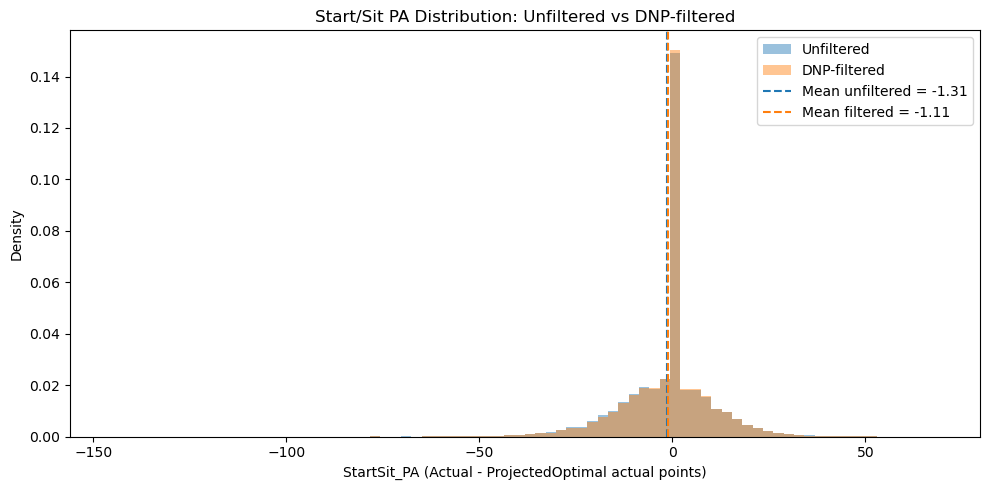

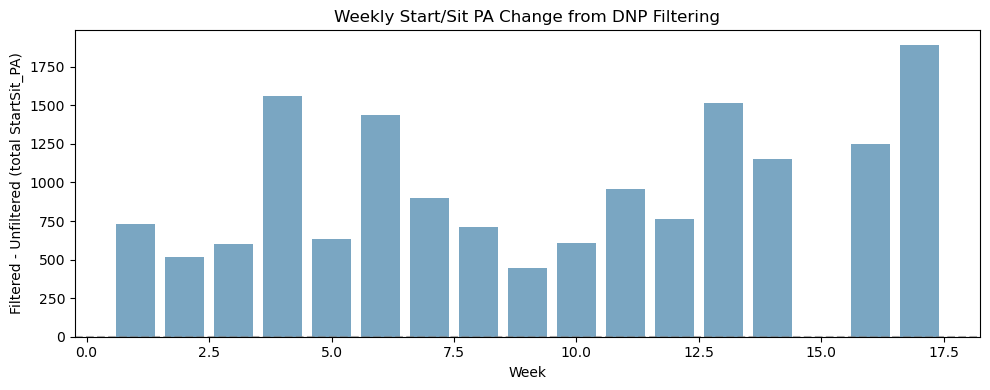

Removed team-weeks by week:
 Week  Removed_TeamWeeks
   17                531
   13                425
    7                402
   14                362
    4                349
    6                308
    5                298
   11                268
   10                241
    9                239
    1                213
   12                185
    3                182
   16                179
    8                175
    2                123


In [527]:
# ============================================================
# BLOCK SS3C - DNP filter impact sanity checks for Start/Sit
#   Compares unfiltered vs DNP-filtered Start/Sit points-added.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEASON_END_WEEK = 17
IGNORE_WEEKS = {15}

required = ["startsit_weekly", "lineups_filt"]
missing = [x for x in required if x not in globals()]
if missing:
    raise ValueError(f"Missing required objects: {missing}. Run SS2 first.")

# Match SS3B proxy settings
DNP_ACTUAL_MAX = 0.0
DNP_PROJ_MIN = 5.0
EXCLUDE_SLOTS_FOR_DNP = {"K", "D/ST", "DST", "DEF"}

# Build flagged team-weeks
lf = lineups_filt.copy()
lf["Week"] = pd.to_numeric(lf["Week"], errors="coerce")
lf["Points"] = pd.to_numeric(lf["Points"], errors="coerce").fillna(0.0)
lf["Projected_Points"] = pd.to_numeric(lf["Projected_Points"], errors="coerce").fillna(0.0)
lf["Is_Starter"] = pd.to_numeric(lf["Is_Starter"], errors="coerce").fillna(0).astype(int)
lf["Slot_norm_dnp"] = lf["Slot"].astype(str).str.upper().str.strip()

dnp_rows = lf[
    (lf["Is_Starter"] == 1) &
    (lf["Points"] <= DNP_ACTUAL_MAX) &
    (lf["Projected_Points"] >= DNP_PROJ_MIN) &
    (~lf["Slot_norm_dnp"].isin(EXCLUDE_SLOTS_FOR_DNP))
].copy()

dnp_teamweeks = dnp_rows[["League_ID", "Year", "Team", "Week"]].drop_duplicates()

# Prepare base Start/Sit table
ss = startsit_weekly.copy()
if "StartSit_PA" not in ss.columns:
    if {"Actual_Starter_Points", "ProjOptimal_ActualPoints"}.issubset(ss.columns):
        ss["StartSit_PA"] = ss["Actual_Starter_Points"] - ss["ProjOptimal_ActualPoints"]
    else:
        raise ValueError("startsit_weekly missing StartSit_PA and required fallback columns.")

ss["Week"] = pd.to_numeric(ss["Week"], errors="coerce").astype(int)
ss = ss[(ss["Week"] >= 1) & (ss["Week"] <= SEASON_END_WEEK)]
ss = ss[~ss["Week"].isin(IGNORE_WEEKS)].copy()

ss_cmp = ss.merge(
    dnp_teamweeks.assign(DNP_Flag=True),
    on=["League_ID", "Year", "Team", "Week"],
    how="left"
)
ss_cmp["DNP_Flag"] = ss_cmp["DNP_Flag"].fillna(False)

unfiltered = ss_cmp.copy()
filtered = ss_cmp[~ss_cmp["DNP_Flag"]].copy()
removed = ss_cmp[ss_cmp["DNP_Flag"]].copy()

# Core scalar diagnostics
n_all = len(unfiltered)
n_keep = len(filtered)
n_drop = len(removed)

mean_all = float(unfiltered["StartSit_PA"].mean())
mean_keep = float(filtered["StartSit_PA"].mean())
mean_drop = float(removed["StartSit_PA"].mean()) if n_drop > 0 else np.nan

sum_all = float(unfiltered["StartSit_PA"].sum())
sum_keep = float(filtered["StartSit_PA"].sum())
sum_drop = float(removed["StartSit_PA"].sum()) if n_drop > 0 else 0.0

print("=== DNP Filter Impact (Start/Sit) ===")
print(f"Rows total / kept / removed: {n_all:,} / {n_keep:,} / {n_drop:,}")
print(f"Mean StartSit_PA (all):     {mean_all:.4f}")
print(f"Mean StartSit_PA (kept):    {mean_keep:.4f}")
print(f"Mean StartSit_PA (removed): {mean_drop:.4f}")
print(f"Total StartSit_PA (all):    {sum_all:.2f}")
print(f"Total StartSit_PA (kept):   {sum_keep:.2f}")
print(f"Total StartSit_PA (removed):{sum_drop:.2f}")
print(f"Net shift from filtering (total): {sum_keep - sum_all:.2f}")
print(f"Net shift from filtering (mean):  {mean_keep - mean_all:.4f}")

# Distribution compare
plt.figure(figsize=(10,5))
plt.hist(unfiltered["StartSit_PA"], bins=80, alpha=0.45, label="Unfiltered", density=True)
plt.hist(filtered["StartSit_PA"], bins=80, alpha=0.45, label="DNP-filtered", density=True)
plt.axvline(mean_all, linestyle="--", color="C0", label=f"Mean unfiltered = {mean_all:.2f}")
plt.axvline(mean_keep, linestyle="--", color="C1", label=f"Mean filtered = {mean_keep:.2f}")
plt.title("Start/Sit PA Distribution: Unfiltered vs DNP-filtered")
plt.xlabel("StartSit_PA (Actual - ProjectedOptimal actual points)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Weekly impact bars
wk_all = unfiltered.groupby("Week", dropna=False)["StartSit_PA"].sum().rename("Unfiltered")
wk_keep = filtered.groupby("Week", dropna=False)["StartSit_PA"].sum().rename("Filtered")
wk = pd.concat([wk_all, wk_keep], axis=1).fillna(0.0).reset_index()
wk["Delta_FilteredMinusUnfiltered"] = wk["Filtered"] - wk["Unfiltered"]

plt.figure(figsize=(10,4))
plt.bar(wk["Week"], wk["Delta_FilteredMinusUnfiltered"], color="#7AA6C2")
plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.title("Weekly Start/Sit PA Change from DNP Filtering")
plt.xlabel("Week")
plt.ylabel("Filtered - Unfiltered (total StartSit_PA)")
plt.tight_layout()
plt.show()

# Where are removals concentrated?
wk_removed_counts = removed.groupby("Week", dropna=False).size().rename("Removed_TeamWeeks").reset_index()
print("Removed team-weeks by week:")
print(wk_removed_counts.sort_values("Removed_TeamWeeks", ascending=False).to_string(index=False))


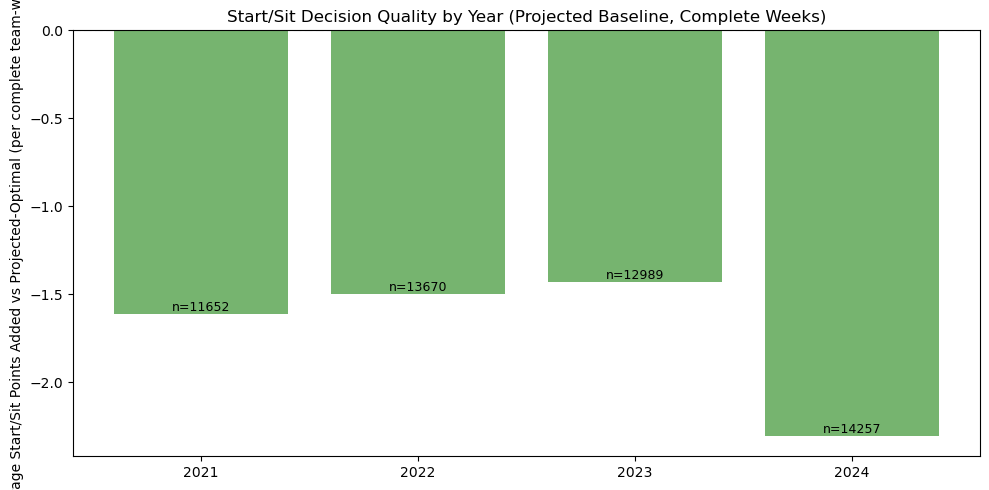

,Year,TeamWeeks,Avg_StartSit_PA,Total_StartSit_PA
0,2021,11652,-1.609483,-18753.70
1,2022,13670,-1.495558,-20444.28
2,2023,12989,-1.429902,-18573.00
3,2024,14257,-2.304978,-32862.07


In [528]:
# ============================================================
# BLOCK SS4 - Average Start/Sit points added by year
#   Uses startsit_weekly_clean (projected baseline + complete team-weeks).
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if "startsit_weekly_clean" not in globals():
    raise ValueError("Run SS2 first to build startsit_weekly_clean.")

s = startsit_weekly_clean.copy()
if "StartSit_PA" not in s.columns:
    raise ValueError("startsit_weekly_clean missing StartSit_PA. Re-run SS2.")

s["Year"] = pd.to_numeric(s["Year"], errors="coerce").astype(int)

summary_ss_year = (
    s.groupby("Year", dropna=False)
     .agg(
         TeamWeeks=("StartSit_PA", "size"),
         Avg_StartSit_PA=("StartSit_PA", "mean"),
         Total_StartSit_PA=("StartSit_PA", "sum"),
     )
     .reset_index()
     .sort_values("Year")
)

x = np.arange(len(summary_ss_year))
plt.figure(figsize=(10,5))
plt.bar(x, summary_ss_year["Avg_StartSit_PA"], color="#54A24B", alpha=0.8)
plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, summary_ss_year["Year"])
plt.ylabel("Average Start/Sit Points Added vs Projected-Optimal (per complete team-week)")
plt.title("Start/Sit Decision Quality by Year (Projected Baseline, Complete Weeks)")
for i, r in summary_ss_year.iterrows():
    plt.text(i, r["Avg_StartSit_PA"], f"n={int(r['TeamWeeks'])}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

summary_ss_year


In [529]:
# ============================================================
# BLOCK TR1 - Basic trade statistics
#   Uses transactions_raw/transactions_filt if available.
# ============================================================

import pandas as pd

if "transactions_filt" in globals():
    tx = transactions_filt.copy()
elif "transactions_raw" in globals():
    tx = transactions_raw.copy()
else:
    raise ValueError("No transactions dataframe found. Run WW1/WW2 first.")

if "Action_norm" not in tx.columns:
    if "Action" in tx.columns:
        tx["Action_norm"] = tx["Action"].astype(str).str.upper().str.strip()
    else:
        raise ValueError("transactions data missing Action/Action_norm column")

trade_mask = tx["Action_norm"].str.contains("TRADE", na=False)
tr = tx[trade_mask].copy()

print("=== Trade Stats ===")
print(f"Rows in transaction table: {len(tx):,}")
print(f"Rows with TRADE action:    {len(tr):,}")

if tr.empty:
    print("No trade rows found with current action naming.")
else:
    if "Year" in tr.columns:
        by_year = tr.groupby("Year", dropna=False).size().reset_index(name="Trade_Action_Rows").sort_values("Year")
        print("\nTrade action rows by year:")
        print(by_year.to_string(index=False))

    if {"League_ID","Year"}.issubset(tr.columns):
        ly = tr[["League_ID","Year"]].drop_duplicates().shape[0]
        print(f"\nLeague-years with >=1 trade action row: {ly:,}")

    if {"League_ID","Year","Team"}.issubset(tr.columns):
        teams = tr[["League_ID","Year","Team"]].drop_duplicates().shape[0]
        print(f"Team-seasons with >=1 trade action row: {teams:,}")

    print("\nTop trade action labels:")
    print(tr["Action_norm"].value_counts().head(10).to_string())


=== Trade Stats ===
Rows in transaction table: 116,318
Rows with TRADE action:    2,772

Trade action rows by year:
 Year  Trade_Action_Rows
 2021                943
 2022                536
 2023                671
 2024                622

League-years with >=1 trade action row: 263
Team-seasons with >=1 trade action row: 989

Top trade action labels:
Action_norm
TRADE_JOIN    2772


In [ ]:
# ============================================================
# BLOCK TR2 - Trade points added vs "no-trade" baseline by year
# Baseline:
#   For each year, no-trade baseline = mean Team Total Valid Points
#   among team-seasons with zero trade actions.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

required_objs = ["draft_with_valid"]
missing_objs = [x for x in required_objs if x not in globals()]
if missing_objs:
    raise ValueError(f"Missing required objects: {missing_objs}. Run draft/valid-points blocks first.")

# Prefer filtered transactions to match filtered analysis universe
if "transactions_filt" in globals():
    tx = transactions_filt.copy()
elif "transactions_raw" in globals():
    tx = transactions_raw.copy()
else:
    raise ValueError("No transactions dataframe found. Run WW1/WW2 first.")

if "Action_norm" not in tx.columns:
    if "Action" in tx.columns:
        tx["Action_norm"] = tx["Action"].astype(str).str.upper().str.strip()
    else:
        raise ValueError("transactions missing Action/Action_norm")

# Team-season total valid points
d = draft_with_valid.copy()
req_d = {"League_ID","Year","Team","Season_Total_Points_Valid"}
missing_d = req_d - set(d.columns)
if missing_d:
    raise ValueError(f"draft_with_valid missing columns: {sorted(missing_d)}")

d["Year"] = pd.to_numeric(d["Year"], errors="coerce").astype(int)
d["Season_Total_Points_Valid"] = pd.to_numeric(d["Season_Total_Points_Valid"], errors="coerce").fillna(0.0)

team_valid = (
    d.groupby(["League_ID","Year","Team"], dropna=False)["Season_Total_Points_Valid"]
     .sum()
     .reset_index(name="Team_Total_Valid")
)

# Trade indicator by team-season
trade_rows = tx[tx["Action_norm"].str.contains("TRADE", na=False)].copy()
traded_team_seasons = trade_rows[["League_ID","Year","Team"]].drop_duplicates()
traded_team_seasons["Has_Trade"] = 1

team = team_valid.merge(traded_team_seasons, on=["League_ID","Year","Team"], how="left")
team["Has_Trade"] = team["Has_Trade"].fillna(0).astype(int)

# No-trade baseline per year
baseline_no_trade = (
    team[team["Has_Trade"] == 0]
    .groupby("Year", dropna=False)["Team_Total_Valid"]
    .mean()
    .reset_index(name="NoTrade_Baseline")
)

team = team.merge(baseline_no_trade, on="Year", how="left")
team["Trade_Points_Added"] = team["Team_Total_Valid"] - team["NoTrade_Baseline"]

# Yearly summary for traded team-seasons
trade_year = (
    team[team["Has_Trade"] == 1]
    .groupby("Year", dropna=False)
    .agg(
        Traded_TeamSeasons=("Trade_Points_Added", "size"),
        Avg_Trade_Points_Added=("Trade_Points_Added", "mean"),
        Total_Trade_Points_Added=("Trade_Points_Added", "sum"),
    )
    .reset_index()
    .sort_values("Year")
)

if trade_year.empty:
    raise ValueError("No traded team-seasons found after current filters.")

# Plot yearly bars (average trade points added vs no-trade baseline)
x = np.arange(len(trade_year))
plt.figure(figsize=(10,5))
plt.bar(x, trade_year["Avg_Trade_Points_Added"], color="#7AA6C2", alpha=0.85)
plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, trade_year["Year"])
plt.ylabel("Avg Trade Points Added vs No-Trade Baseline")
plt.title("Trade Points Added by Year (No-Trade Baseline)")

for i, r in trade_year.iterrows():
    plt.text(i, r["Avg_Trade_Points_Added"], f"n={int(r['Traded_TeamSeasons'])}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

trade_year
